In [1]:
import pandas as pd
import json
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from openff.toolkit import Molecule
from xtb.ase.calculator import XTB
from ase import build
import qcelemental as qcel
from pint import UnitRegistry
import ase
import re
import matplotlib.pyplot as plt
from tabulate import tabulate
sys.path.append('../')
from visualization import show_oemol_struc
from cinnabar.stats import bootstrap_statistic
from matplotlib.backends.backend_pdf import PdfPages
from collections import defaultdict
from matplotlib import rcParams
from PIL import Image
import io

/home/maverick/miniconda3/envs/mace_env/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/maverick/miniconda3/envs/mace_env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/maverick/miniconda3/envs/mace_env/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/maverick/miniconda3/envs/mace_env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
def get_relative_energies(energies, conv_factor):
    min_energy = min(energies)
    energies = [conv_factor*(ener - min_energy) for ener in energies]
    return energies
    
rcParams.update({"font.size": 12})
REF_SPEC = 'mp2/heavy-aug-cc-pv[tq]z + d:ccsd(t)/heavy-aug-cc-pvdz'
with open('../data/'+REF_SPEC.replace('/','_')+'_single_points_data.json', 'r') as file:
        ref_dict = json.load(file)
with open('../data/MP2_heavy-aug-cc-pVTZ_torsiondrive_data.json', 'r') as file:
    mp2_data = json.load(file)

pdf = PdfPages("../output/torsion_profiles_gfn2-xtb.pdf")

In [3]:
def get_atom_charges(input_string, len_atoms):
    charges = np.zeros(len(atoms))
    pattern = re.compile(r'\[.*?\]')
    matches = pattern.findall(input_string)

    separated_strings = []

    for match in matches:
        # Remove square brackets and then split the string before and after the colon
        cleaned_match = match[1:-1]  # Remove square brackets
        parts = cleaned_match.split(':')
        if '+' in parts[0]:
            charges[int(parts[1])-1] = 1
        elif '-' in parts[0]:
            charges[int(parts[1])-1] = -1

    return charges

In [4]:
ureg = UnitRegistry()
electron_volt = 1 * ureg.electron_volt
eV_to_kcalmol_conversion_factor = electron_volt.to(ureg.kilocalorie/(ureg.avogadro_constant*ureg.mole)).magnitude

hartree = 1 * ureg.hartree
HARTREE_TO_KCALMOL = hartree.to(ureg.kilocalorie/(ureg.avogadro_constant*ureg.mole)).magnitude

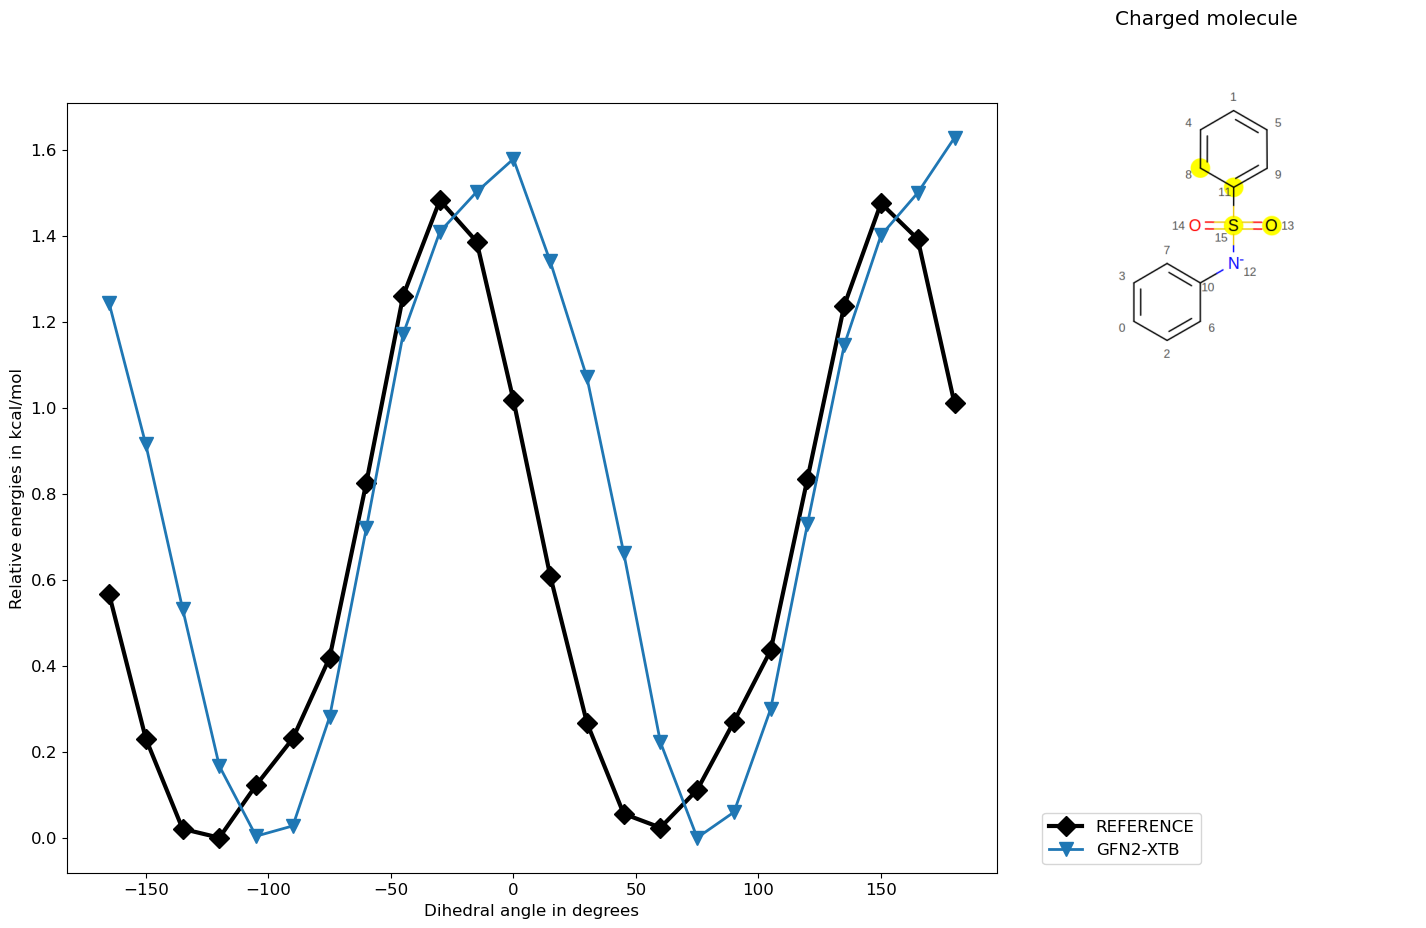

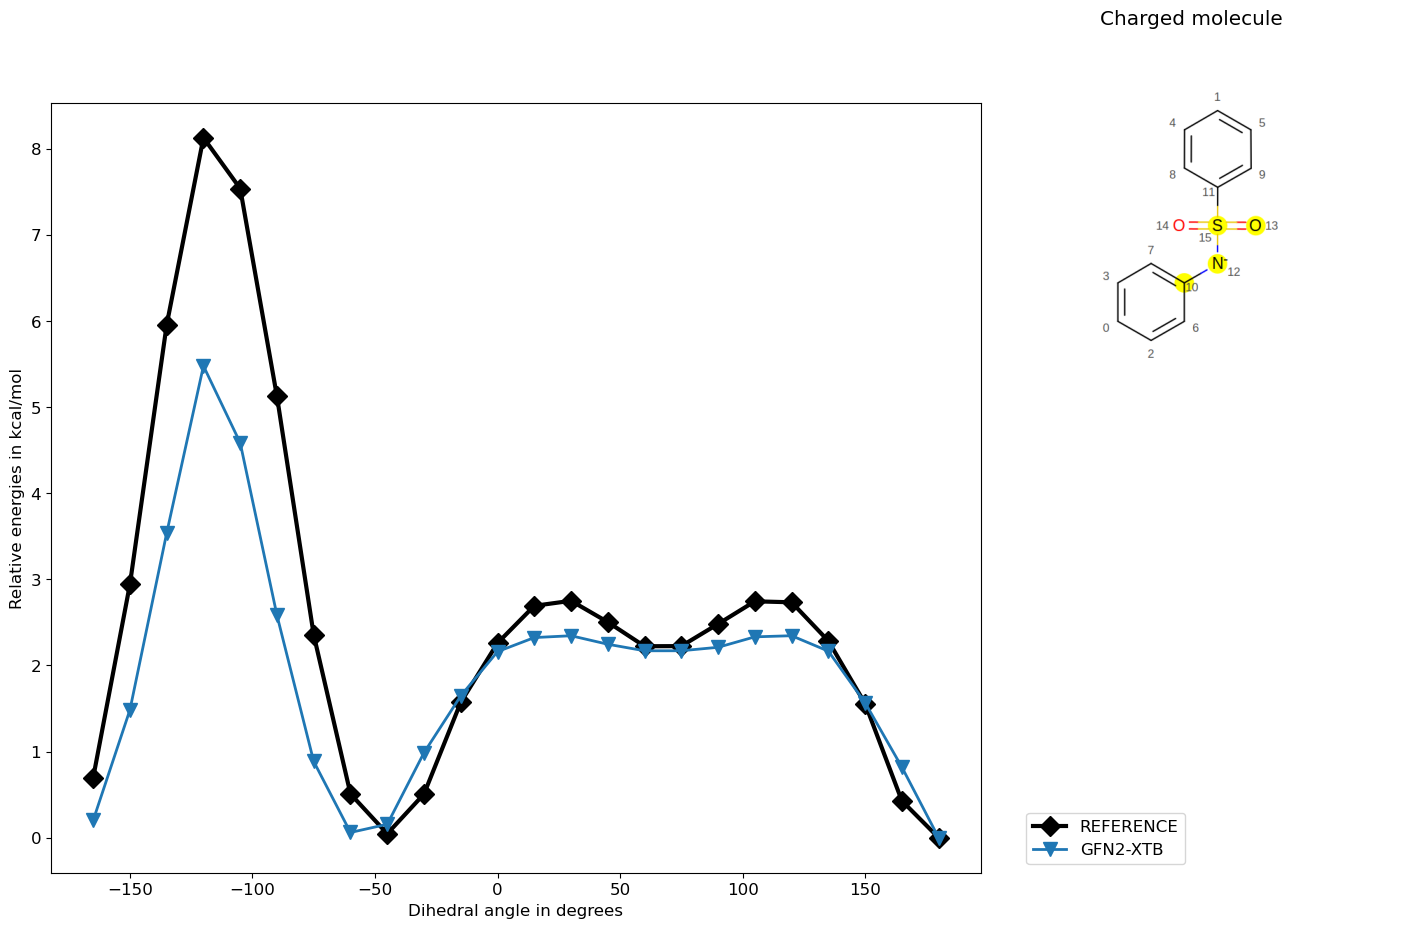

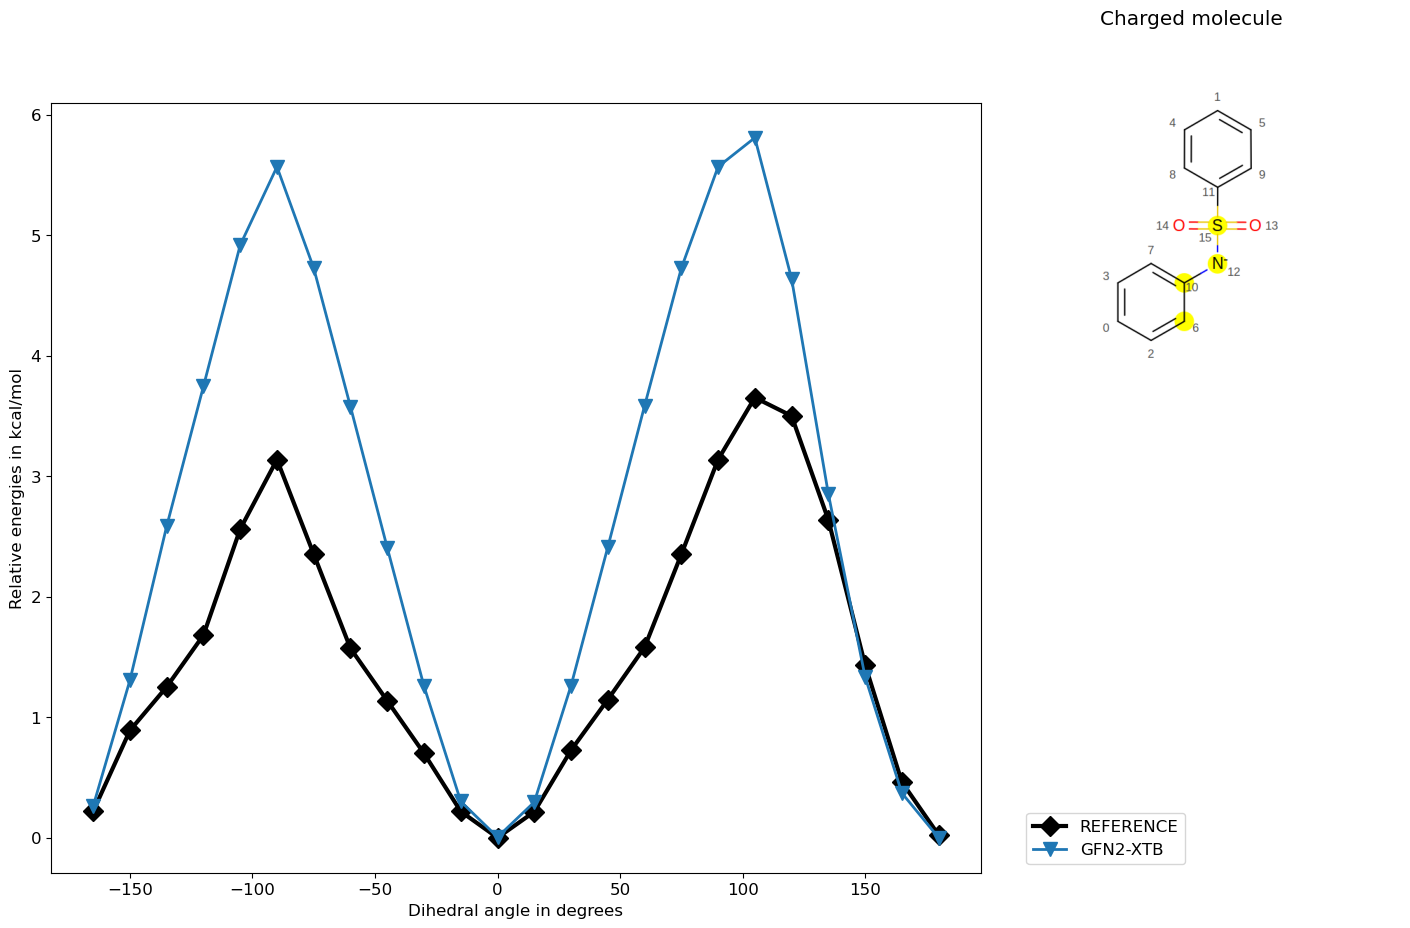

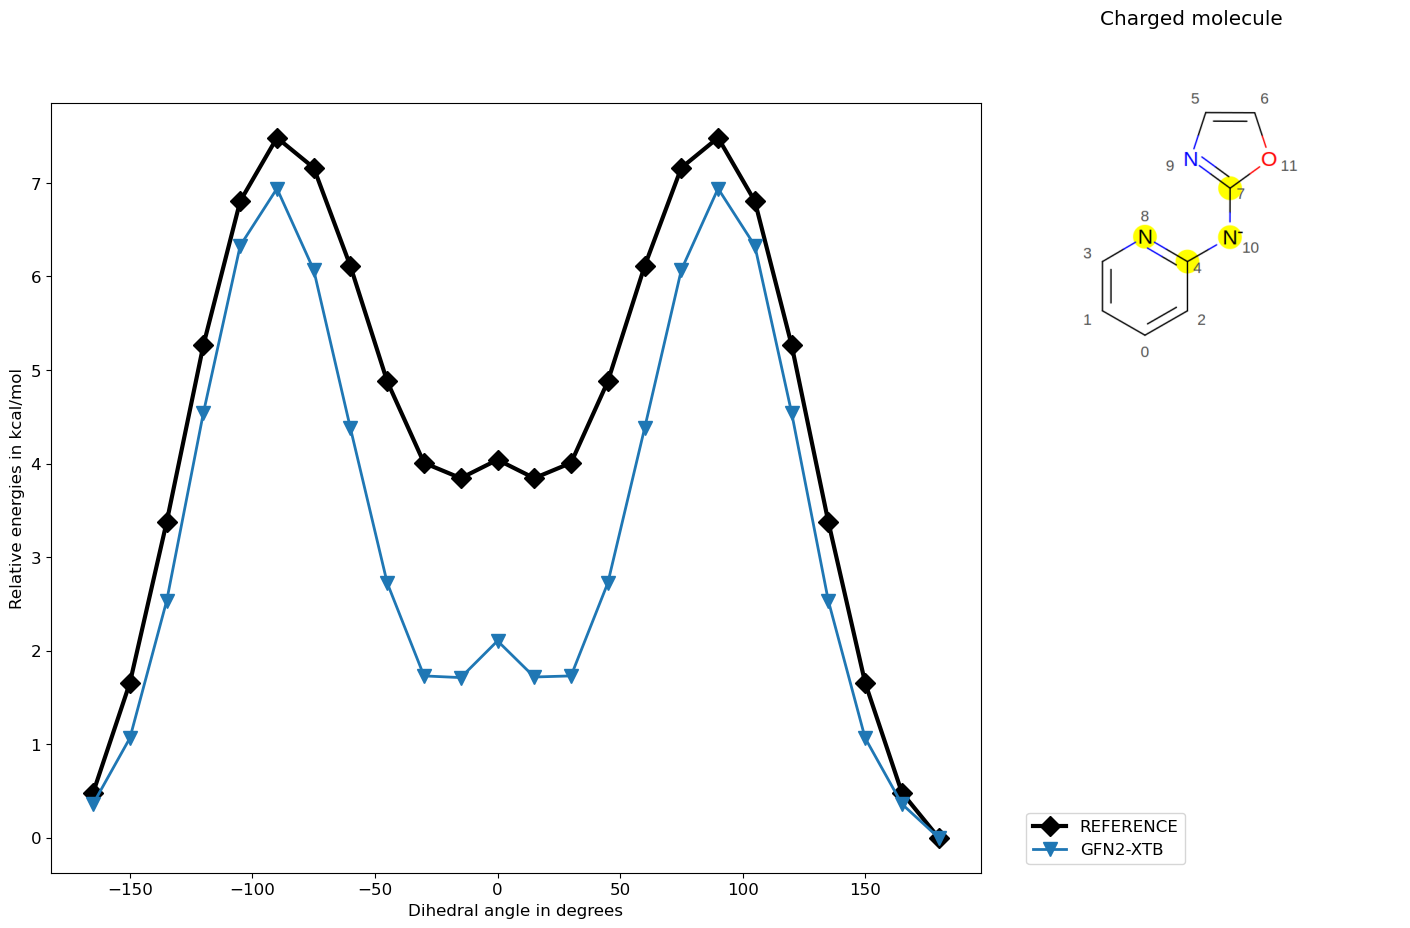

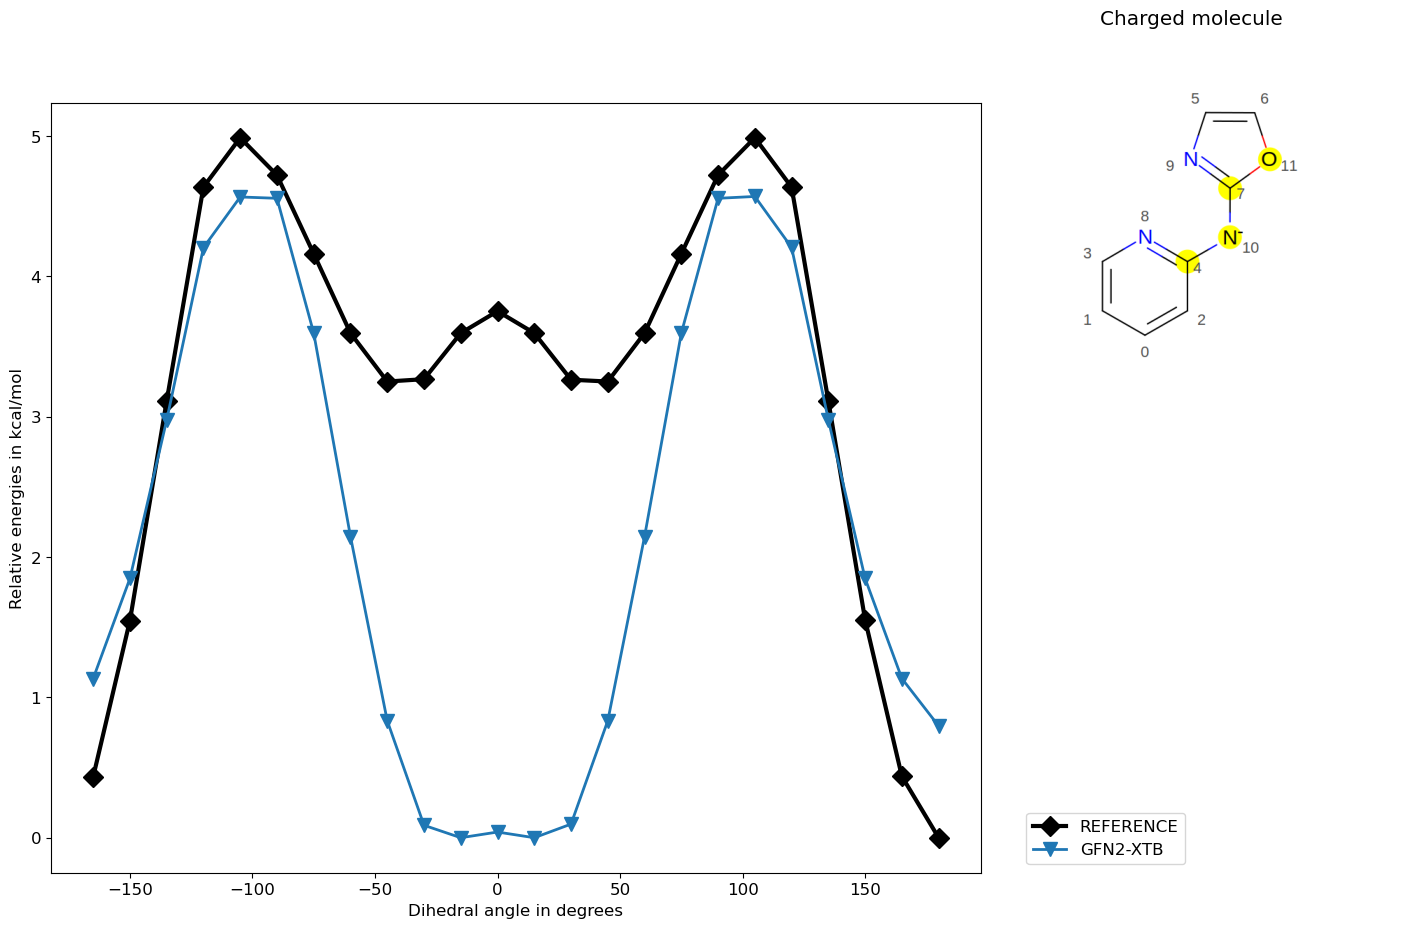

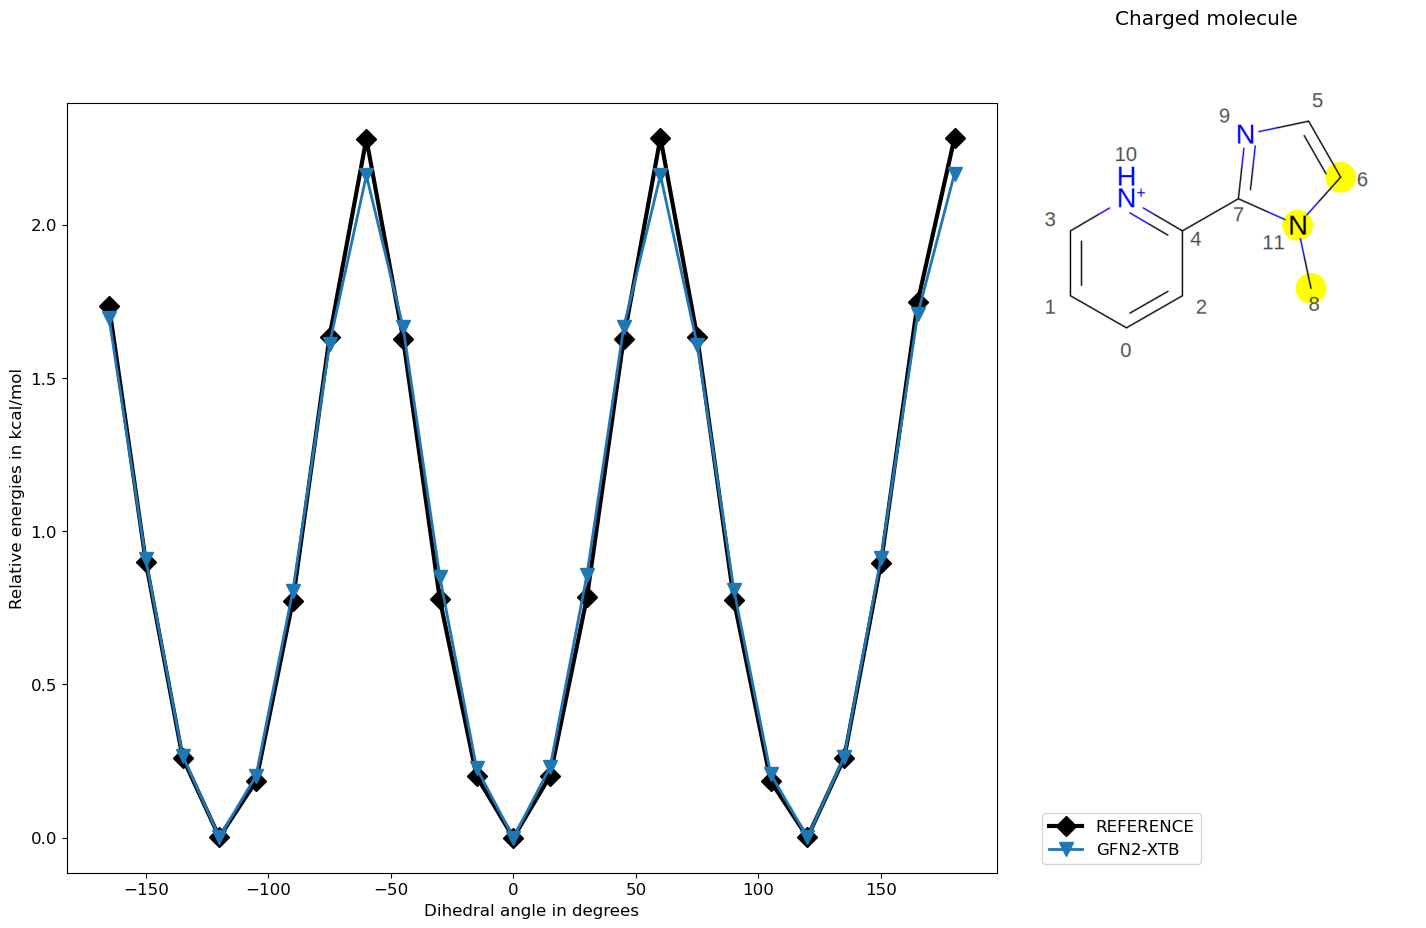

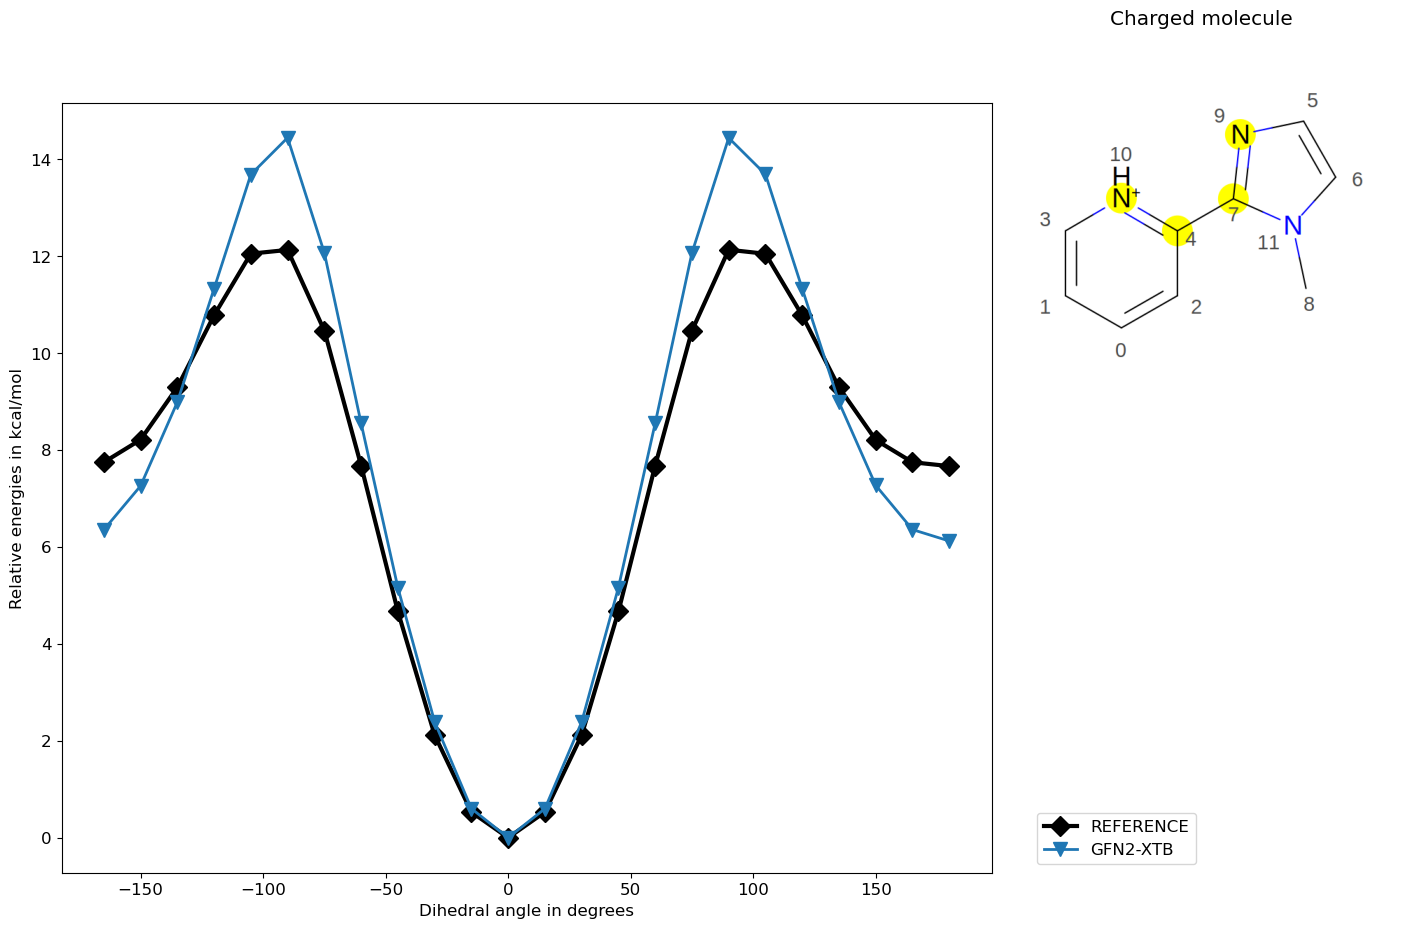

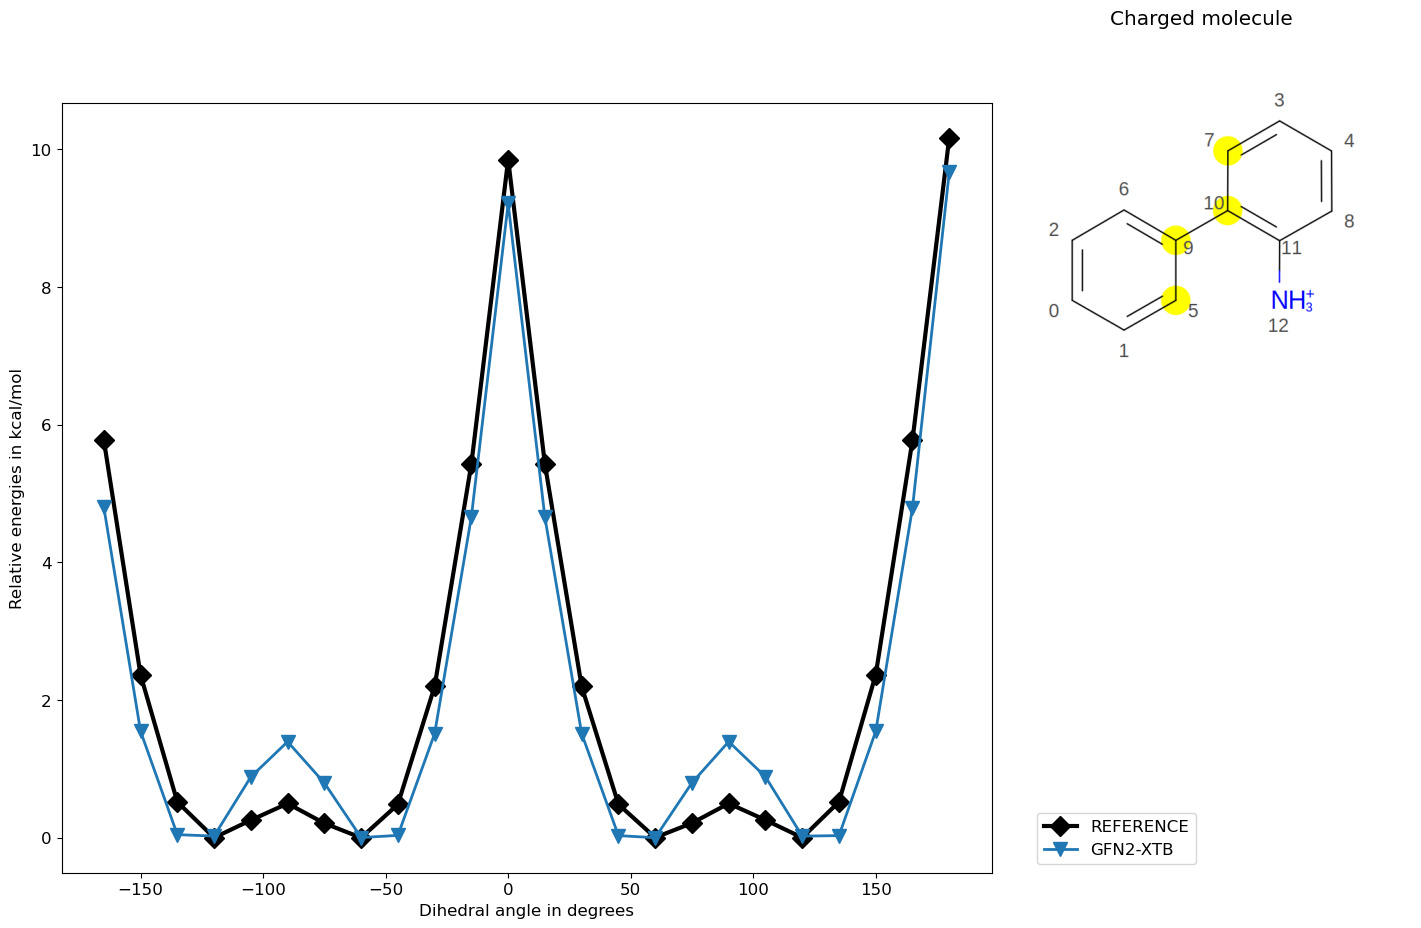

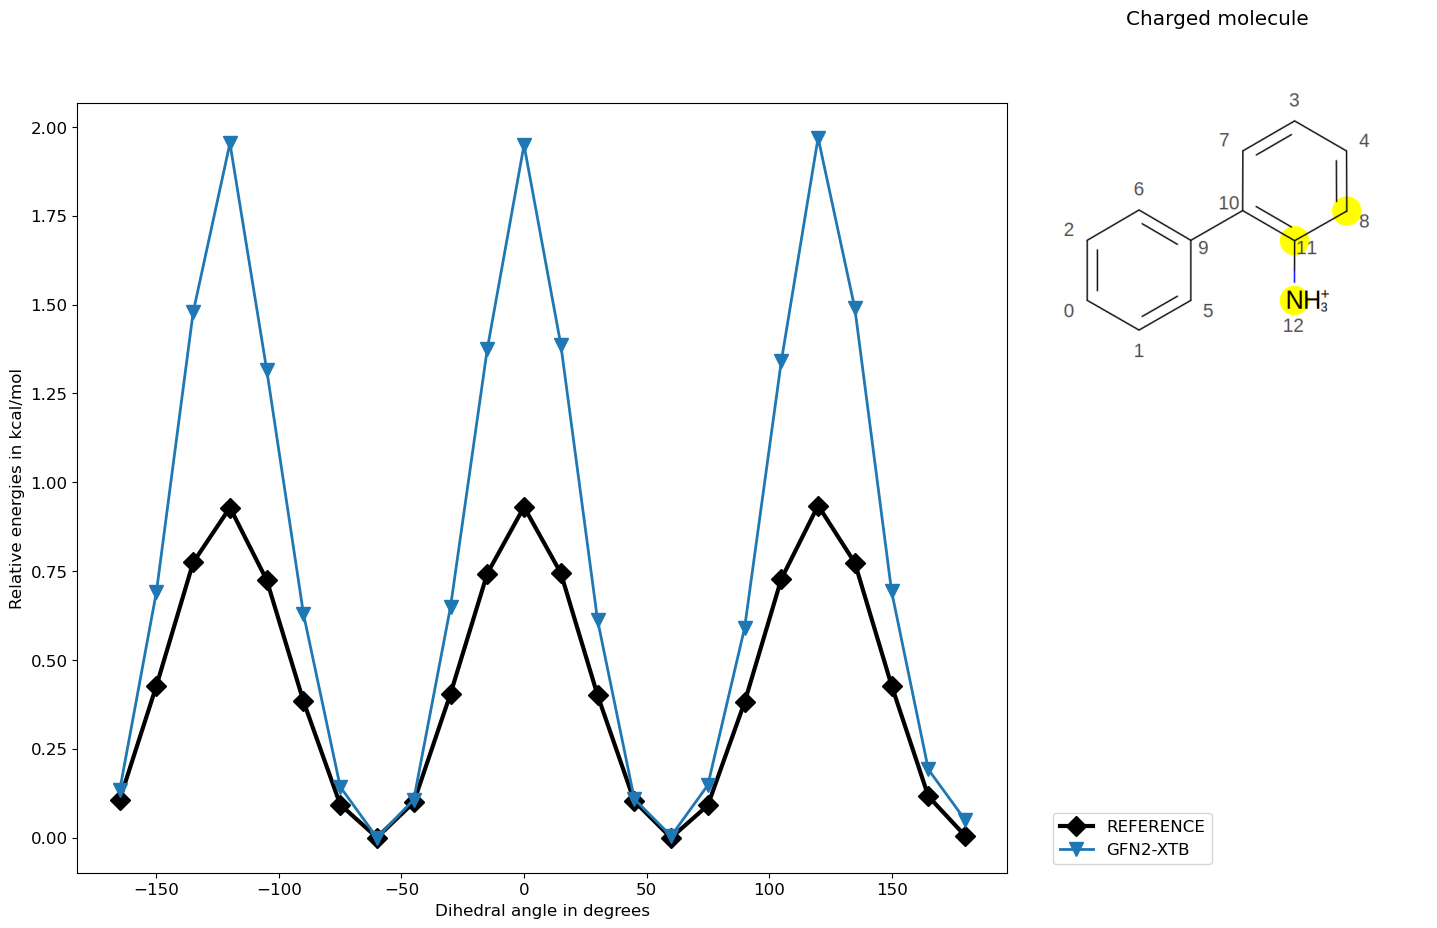

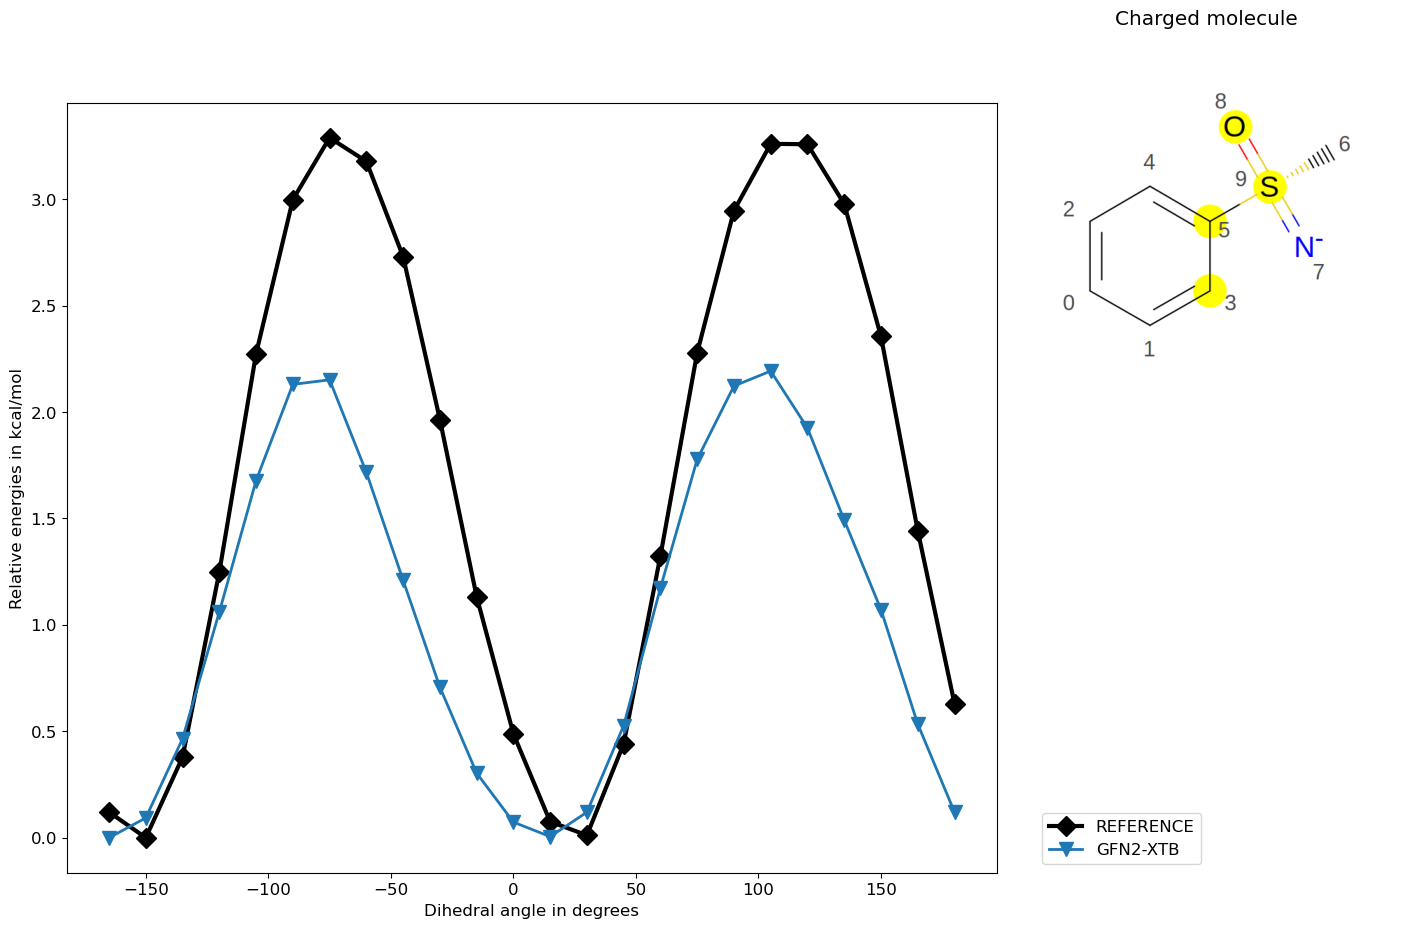

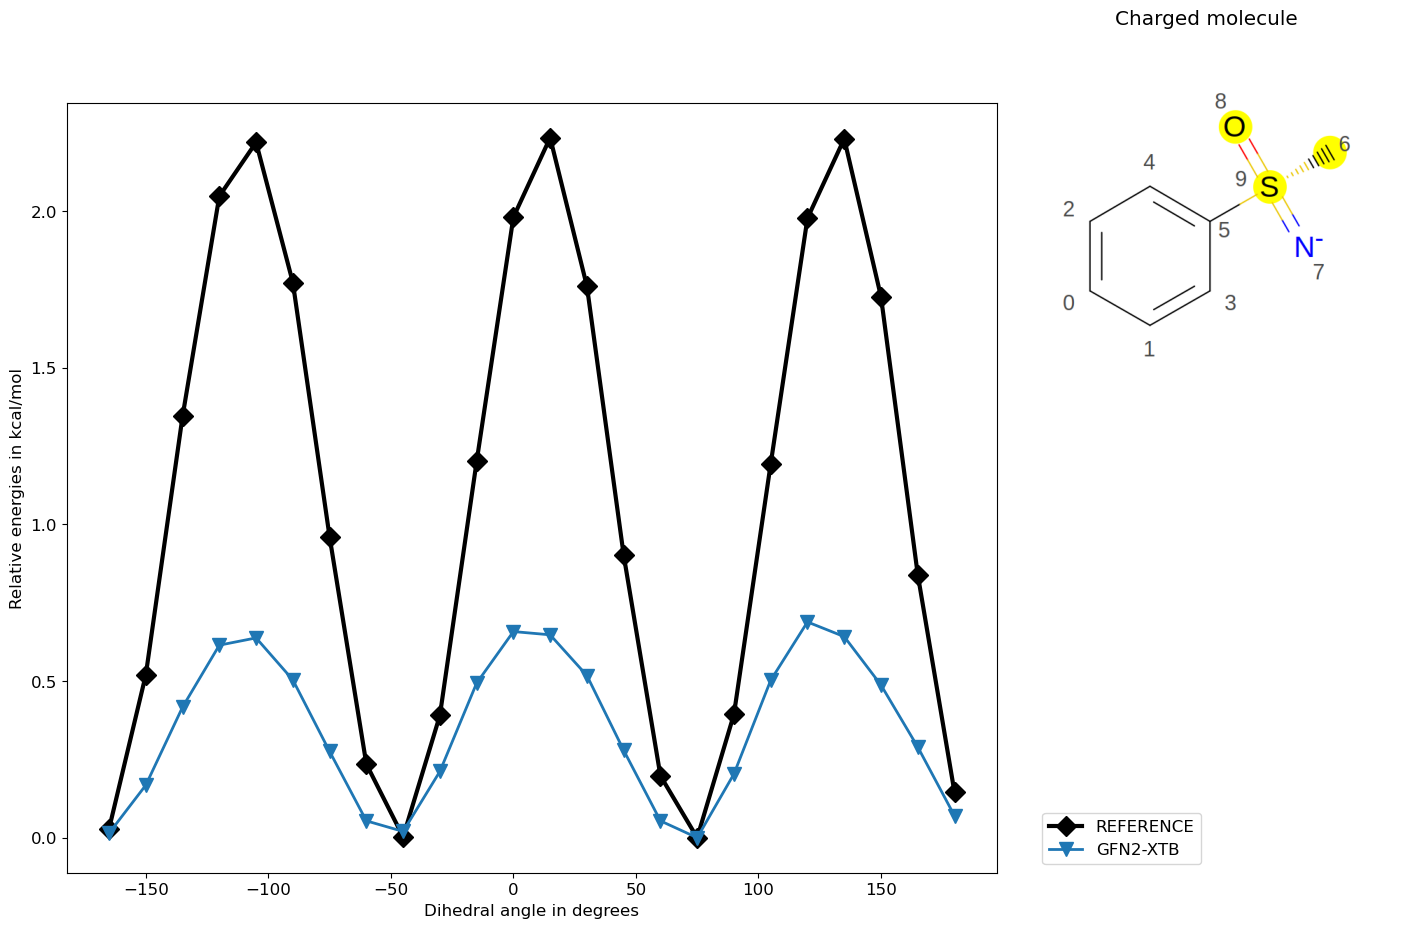

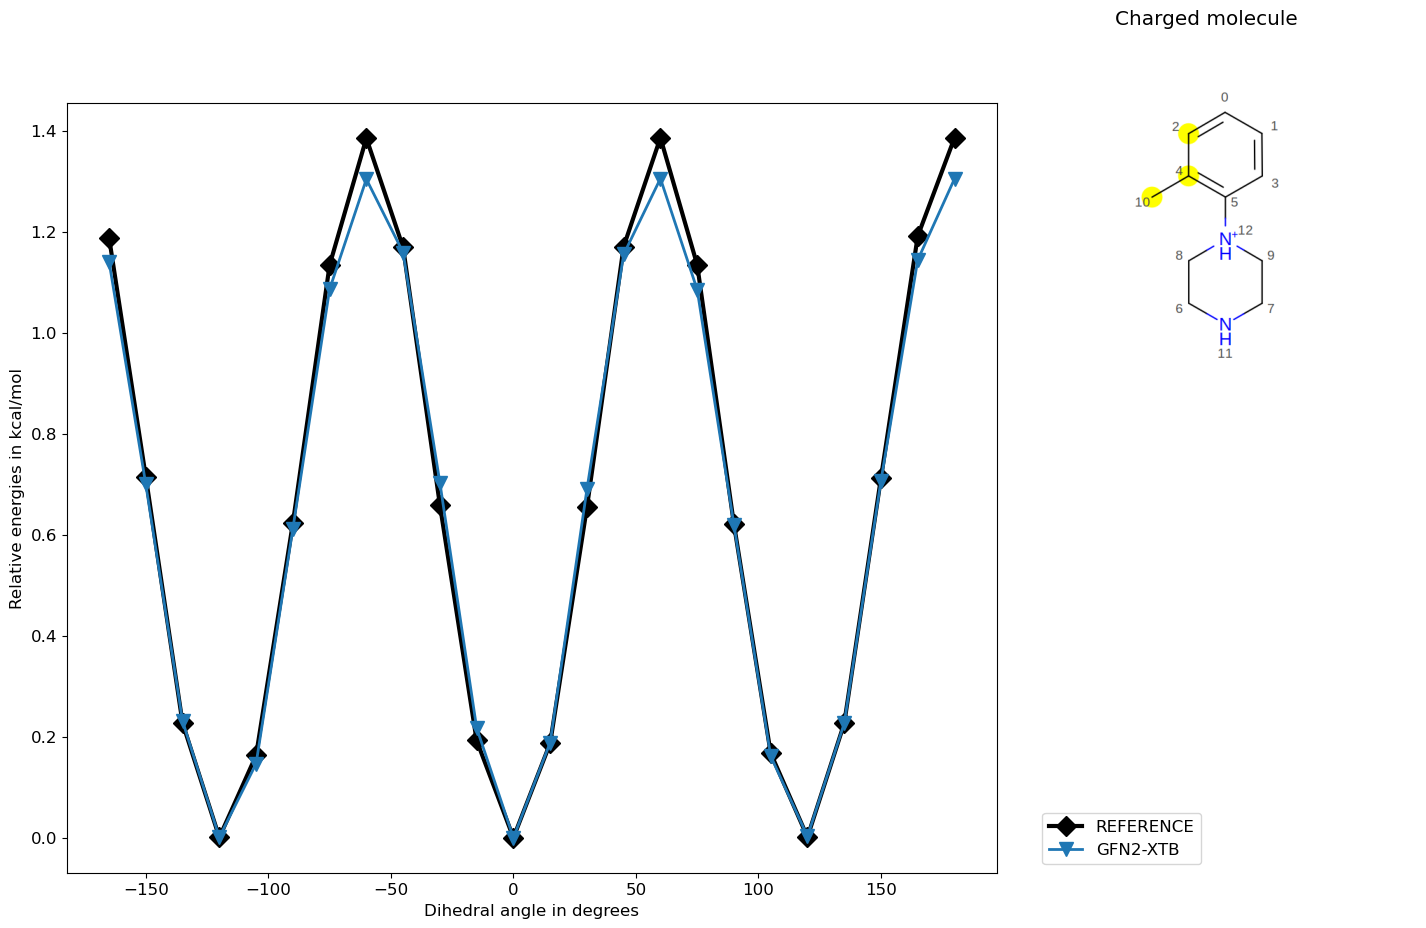

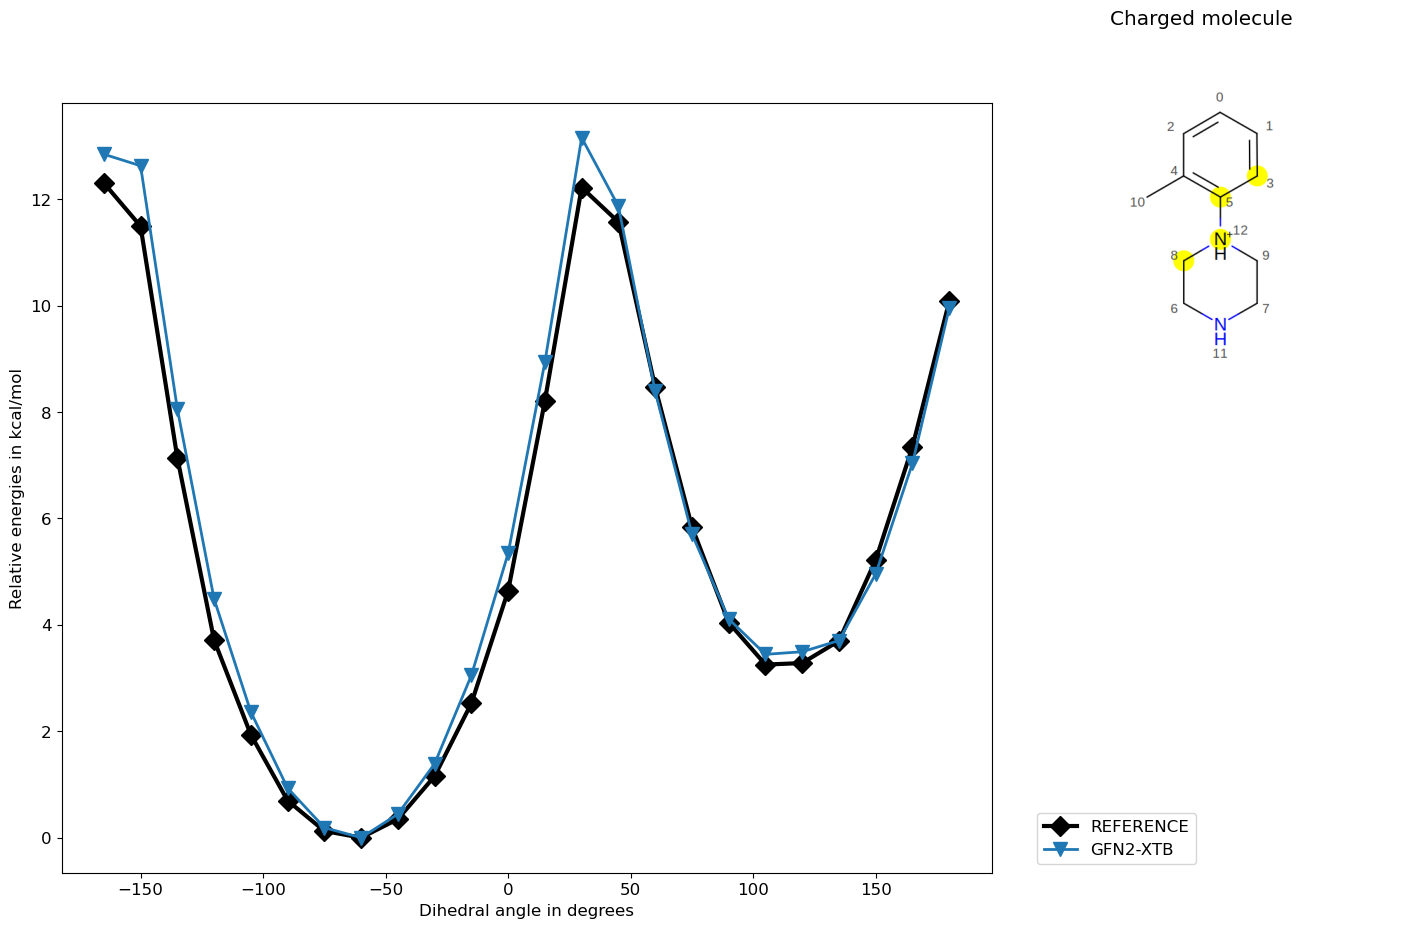

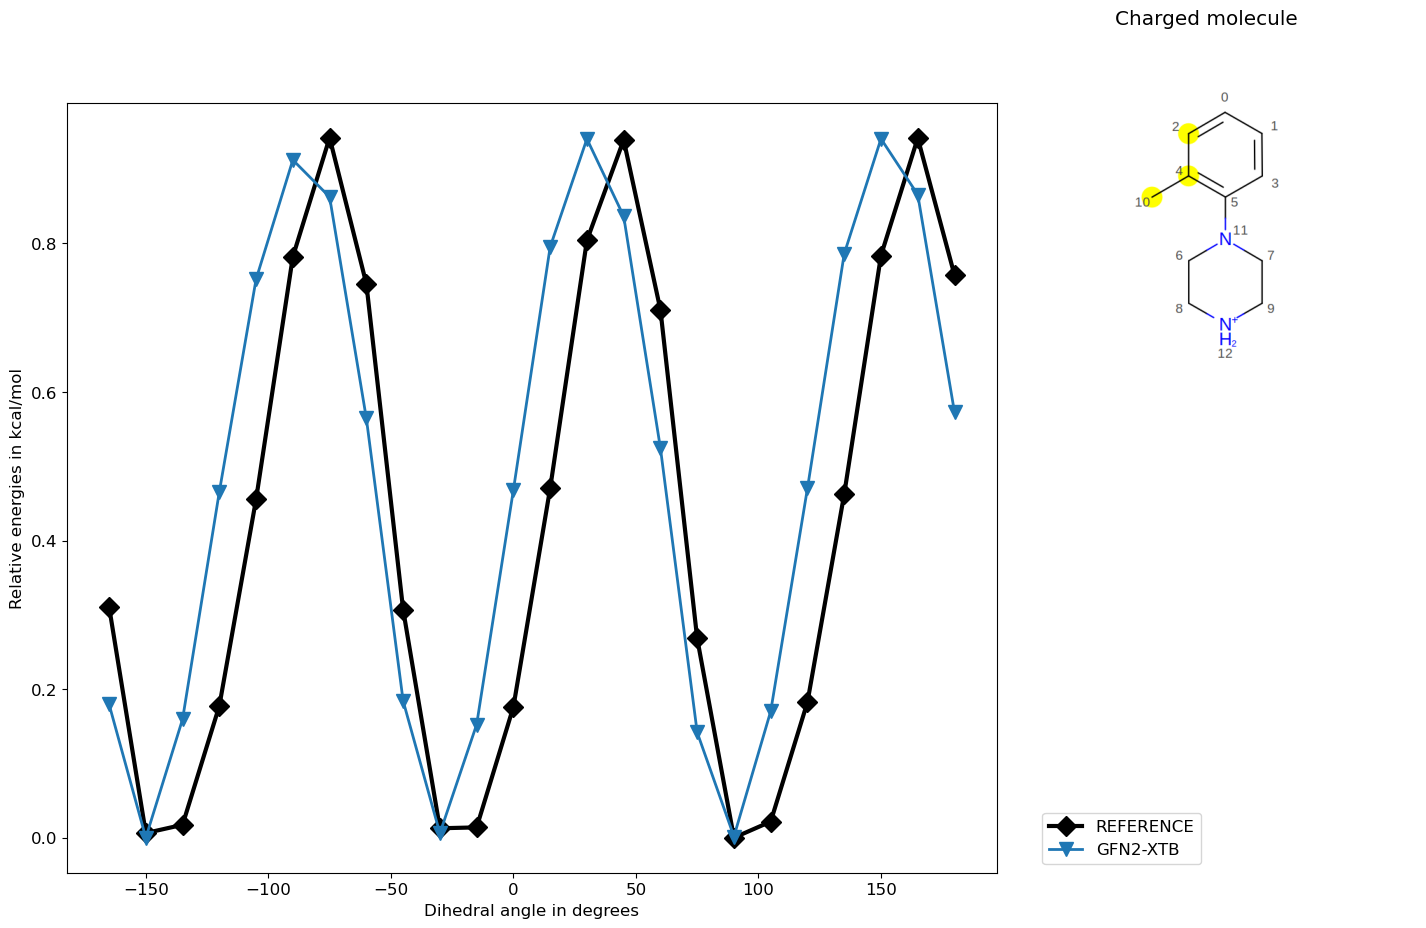

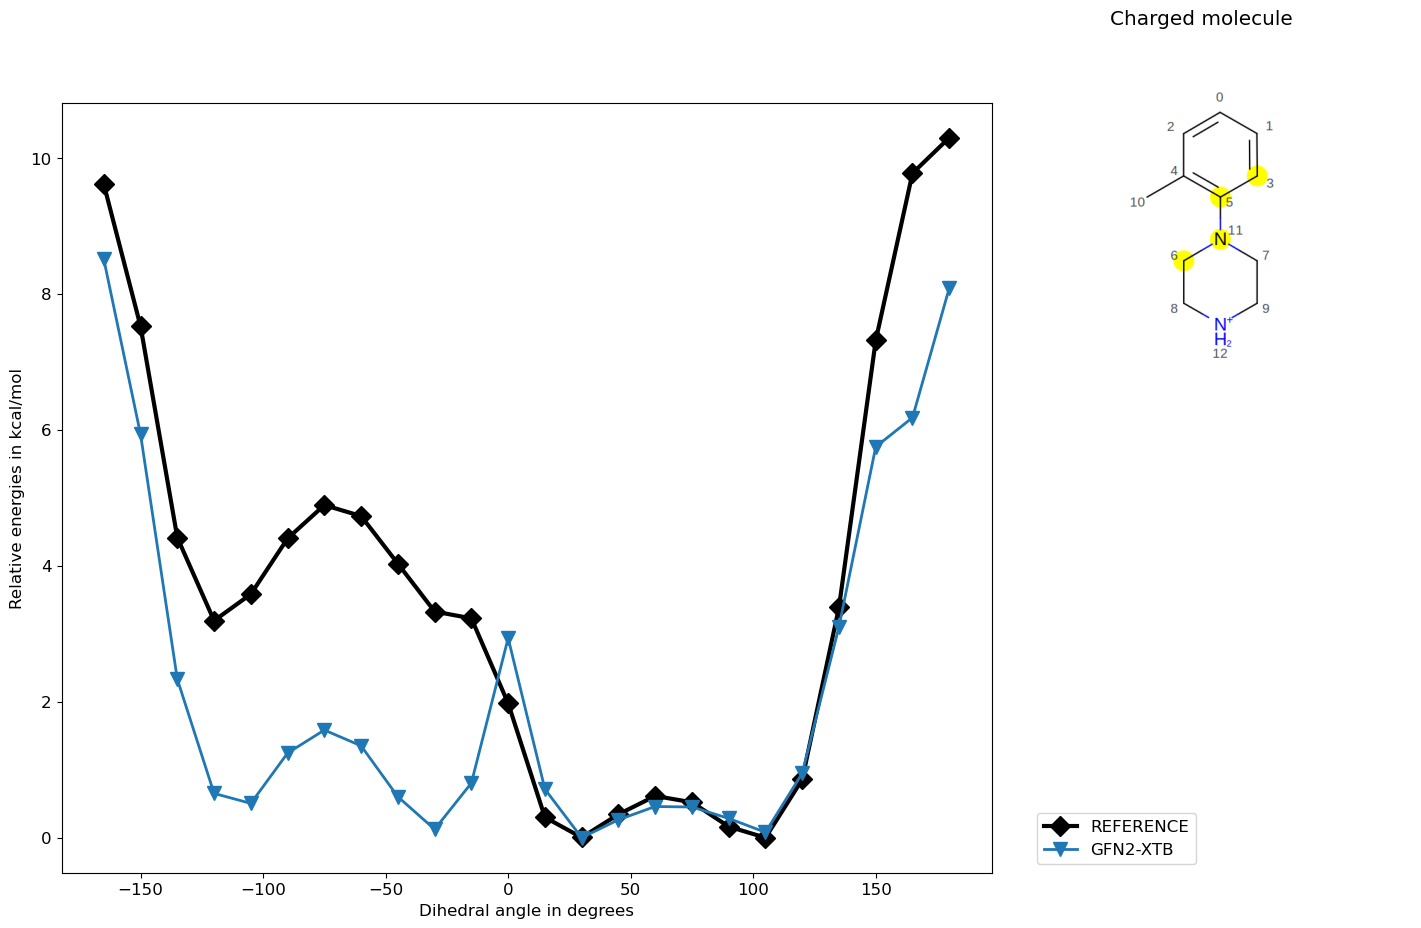

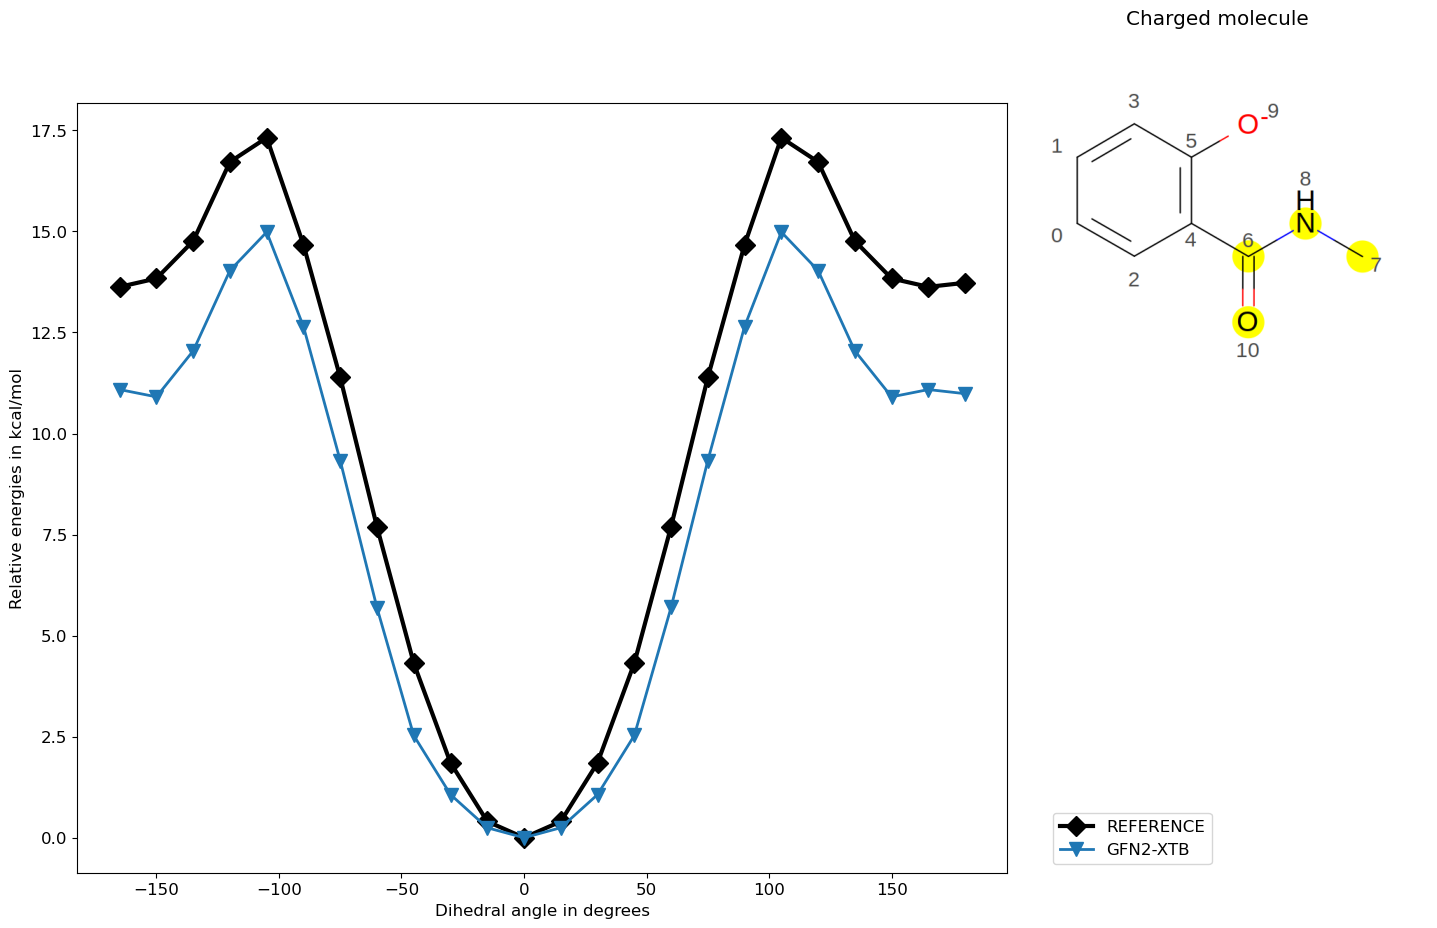

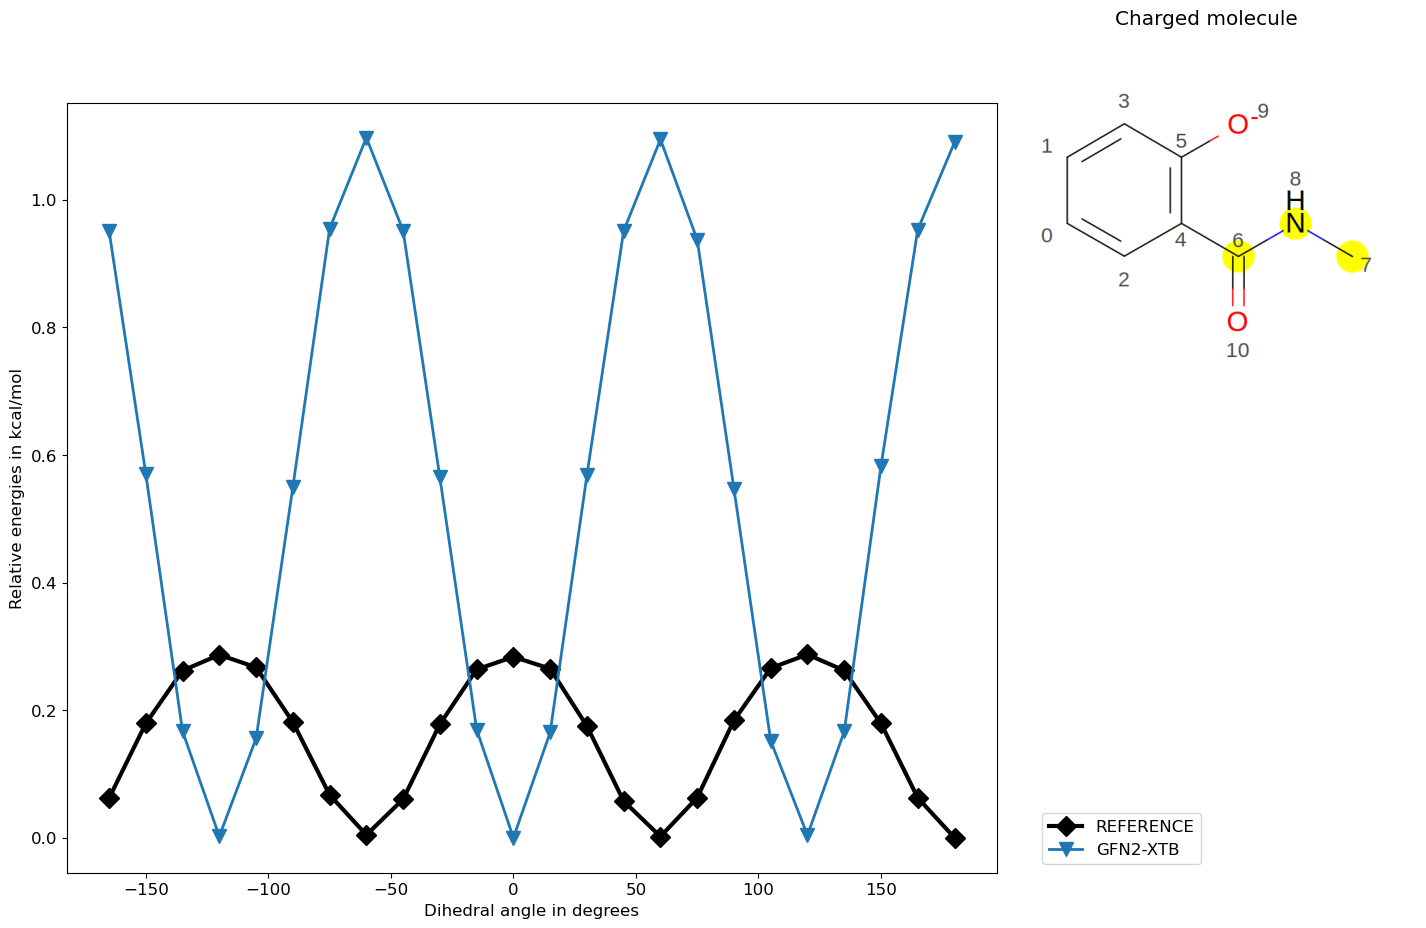

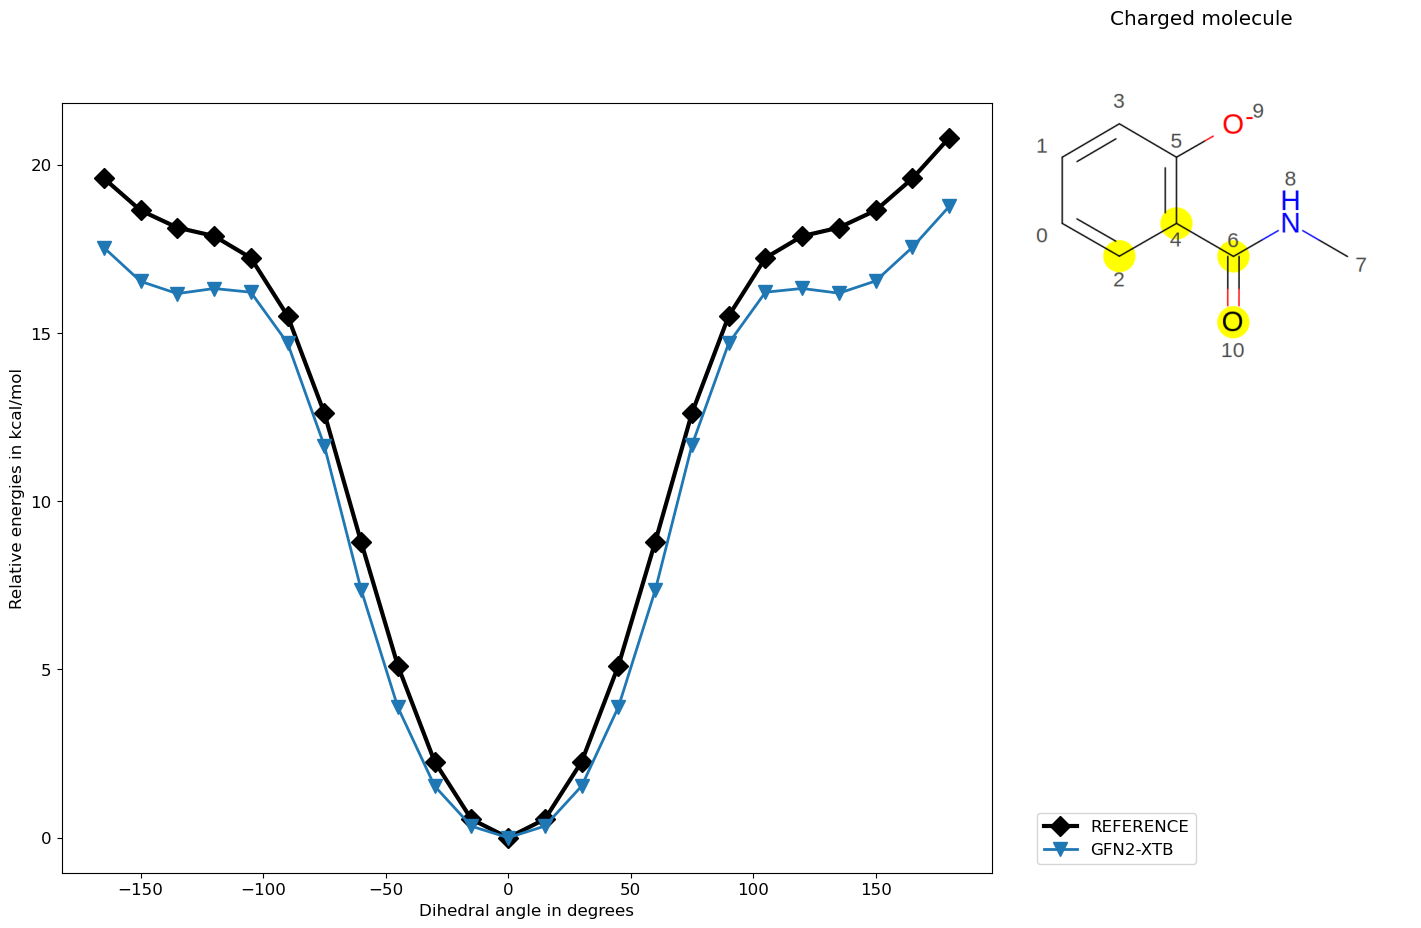

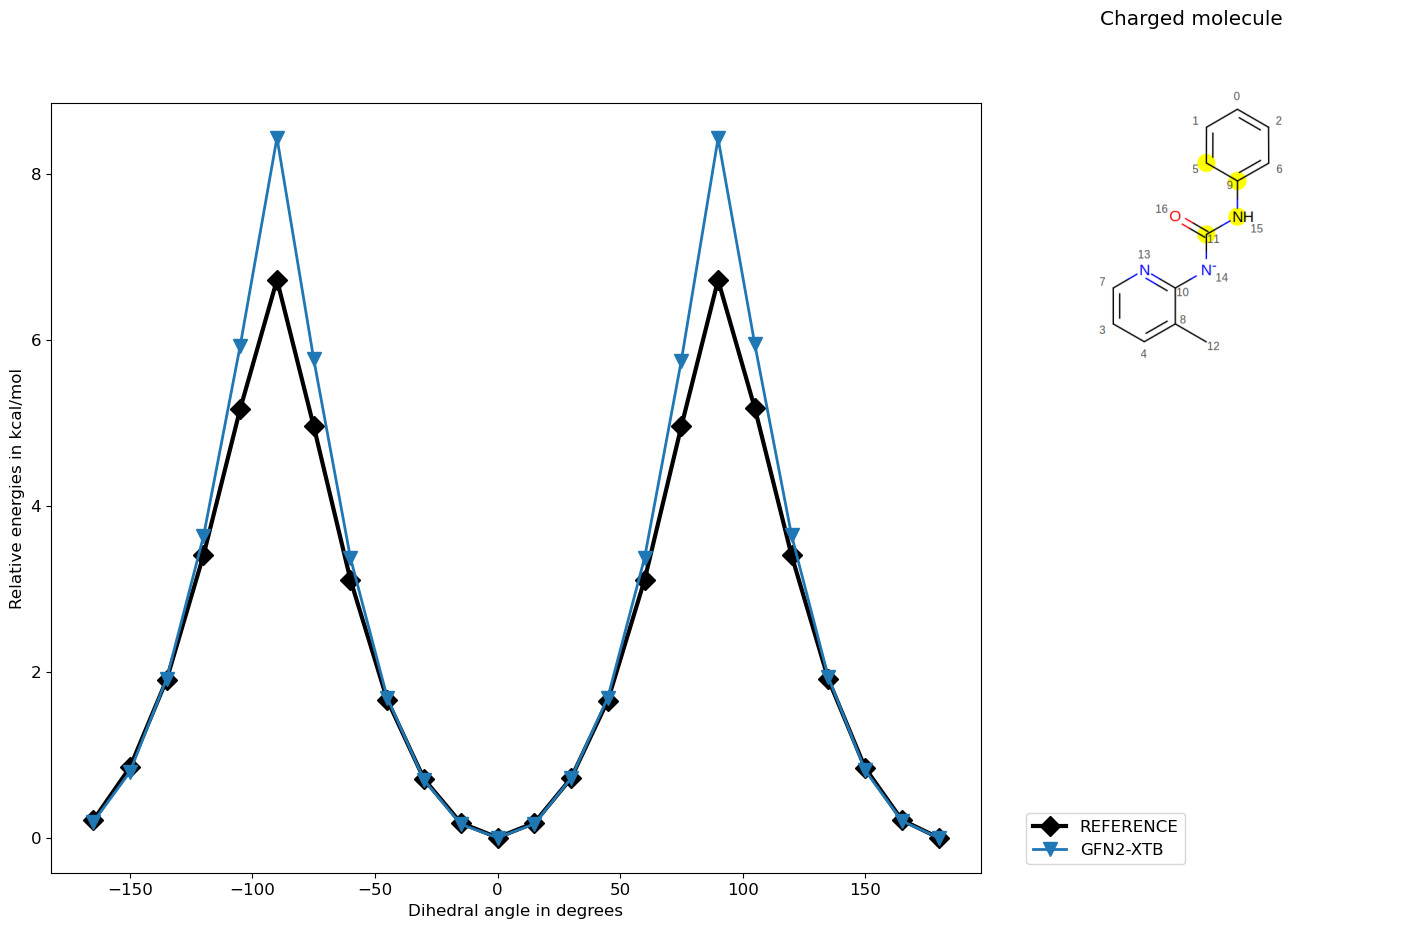

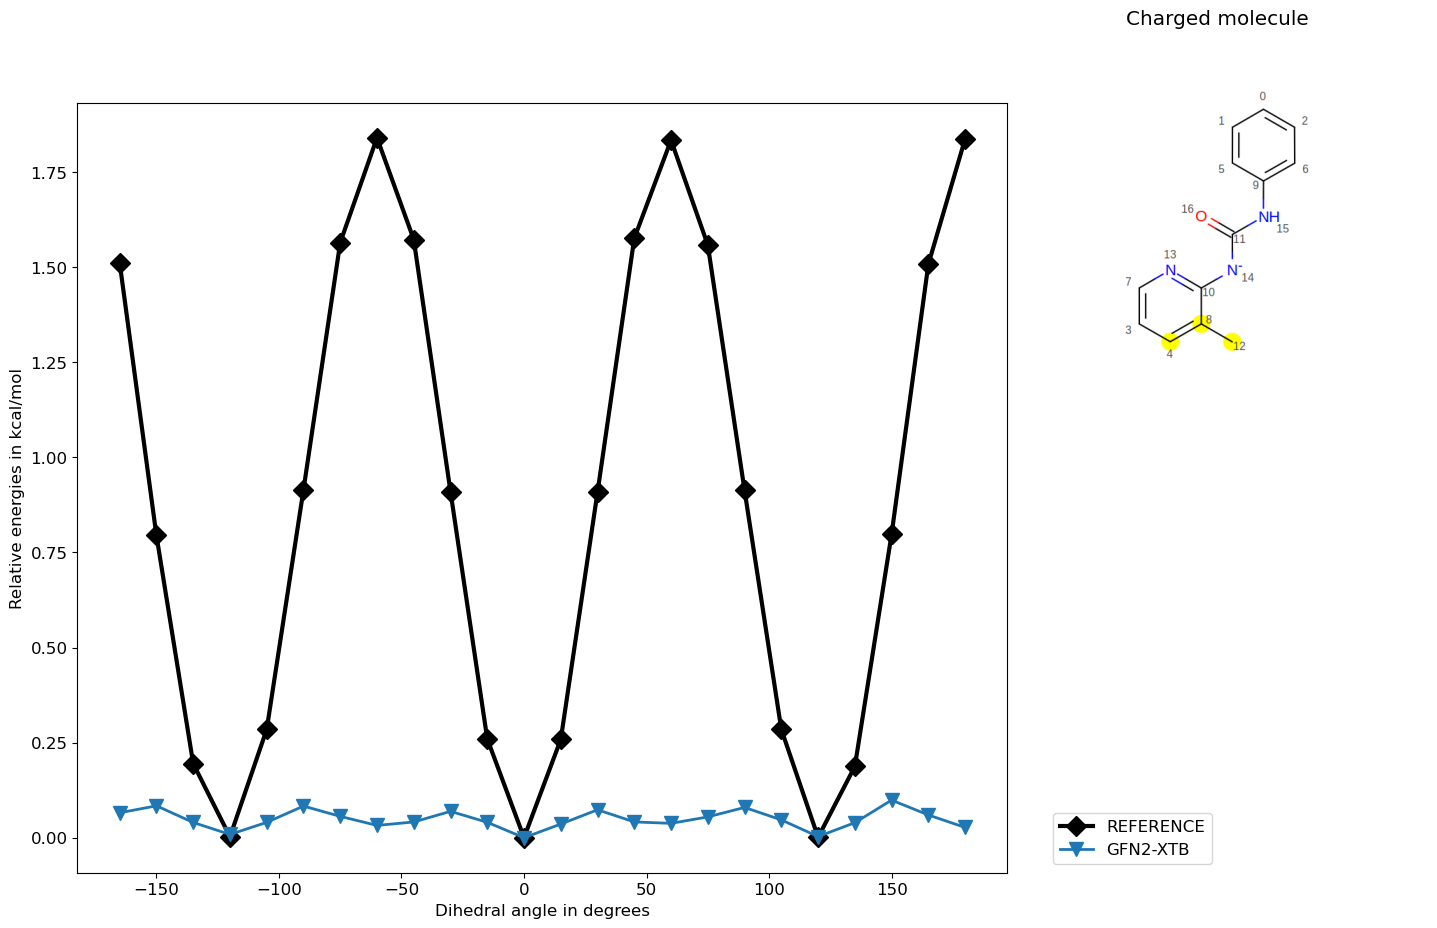

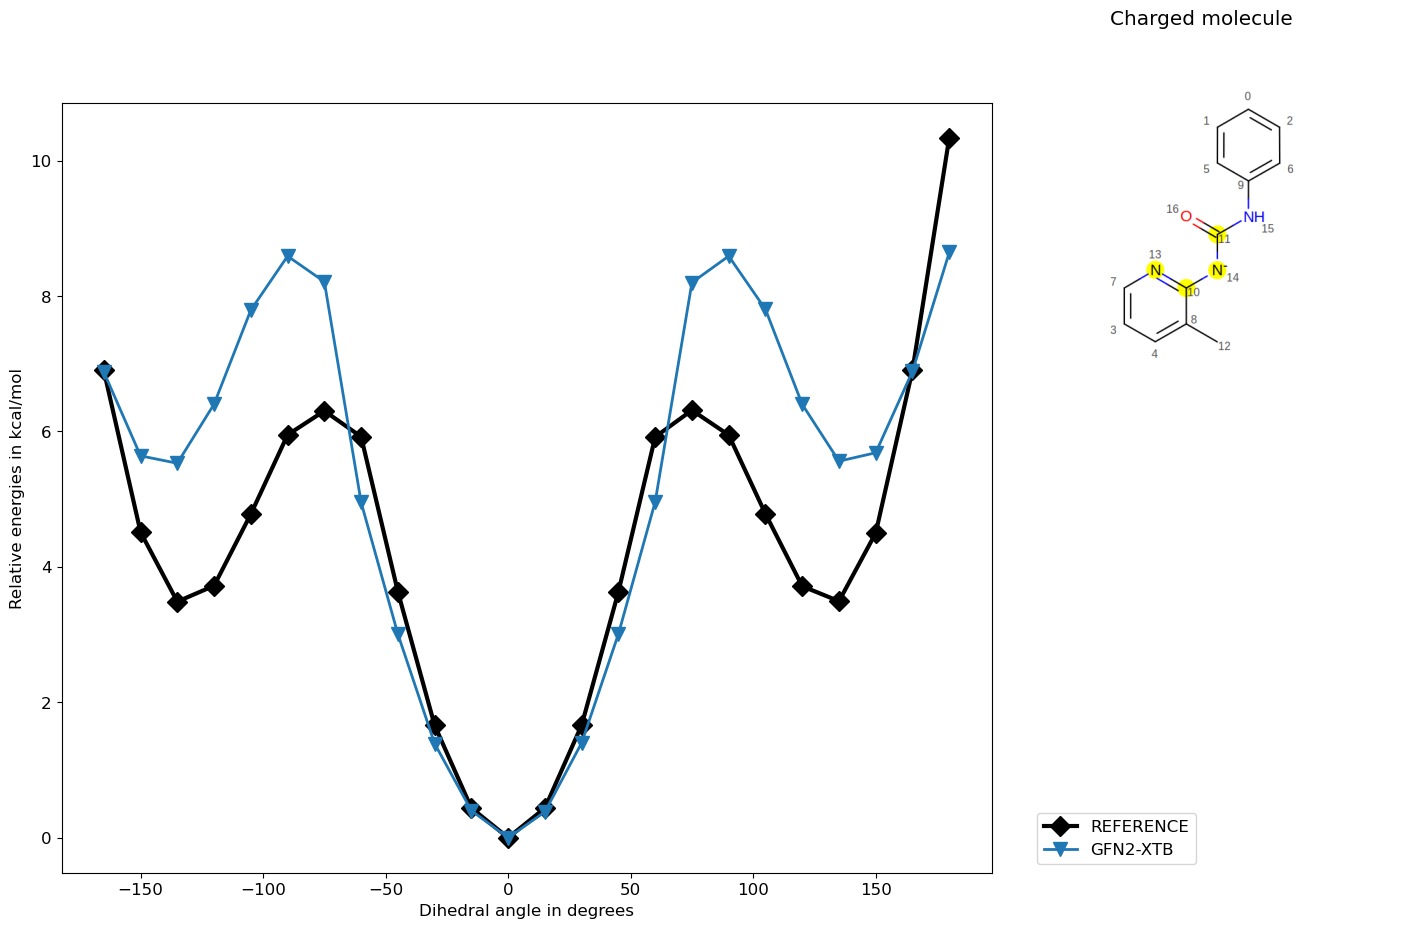

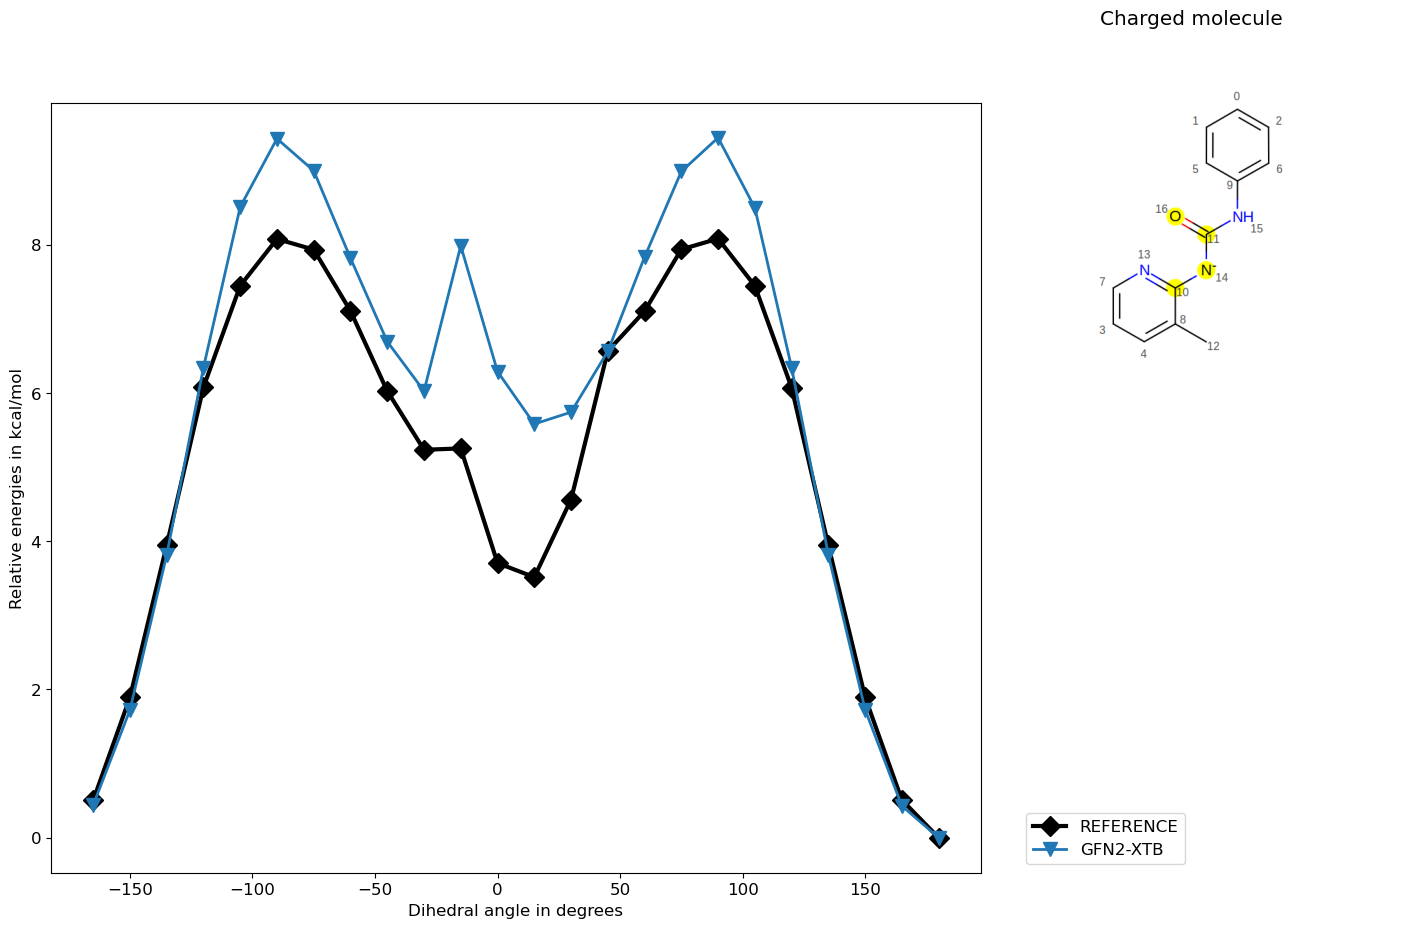

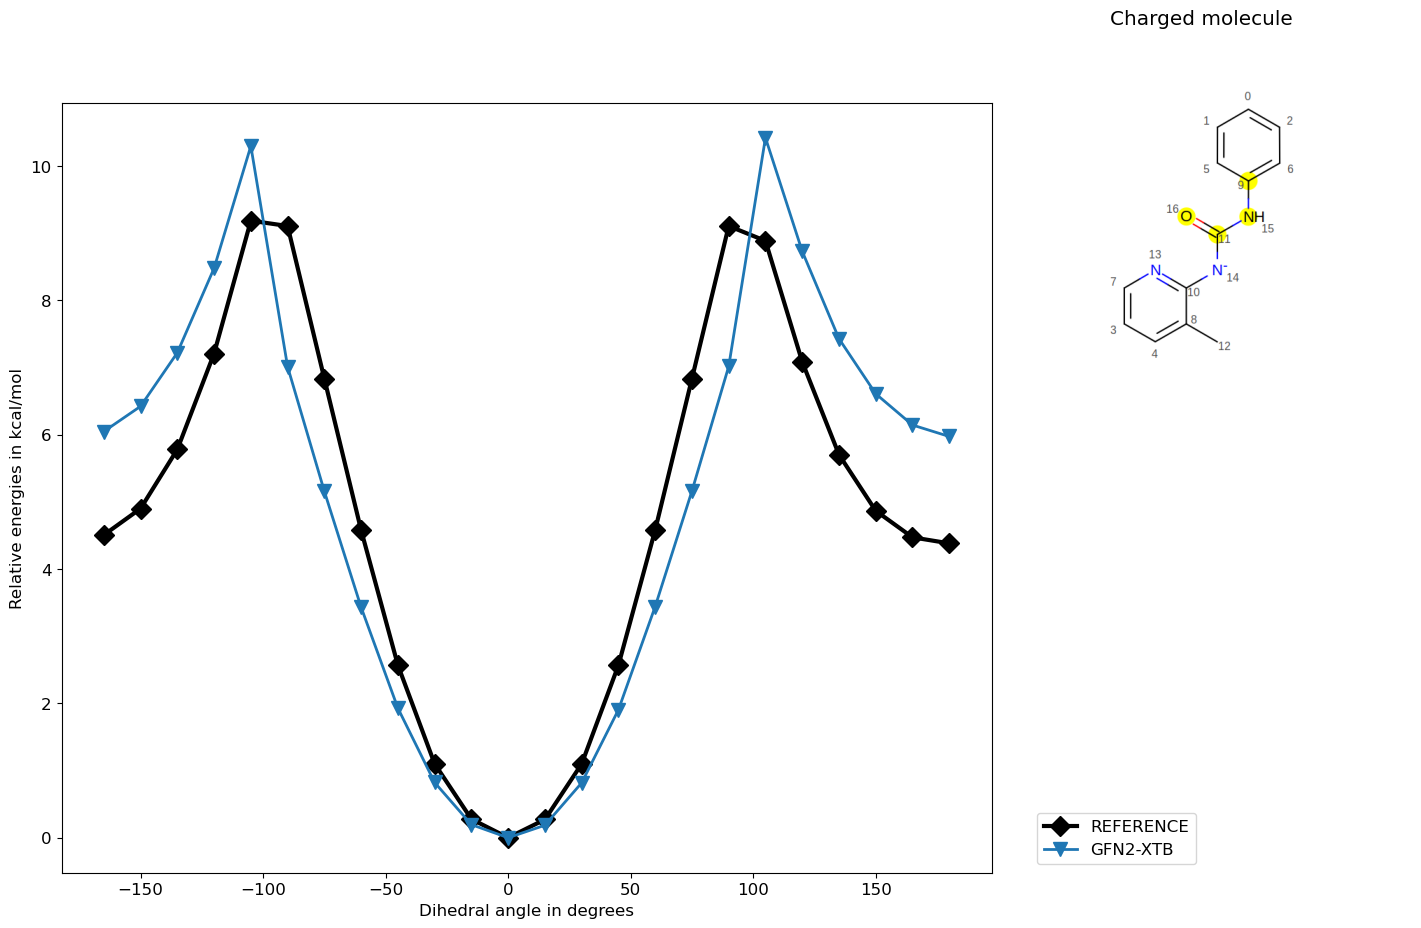

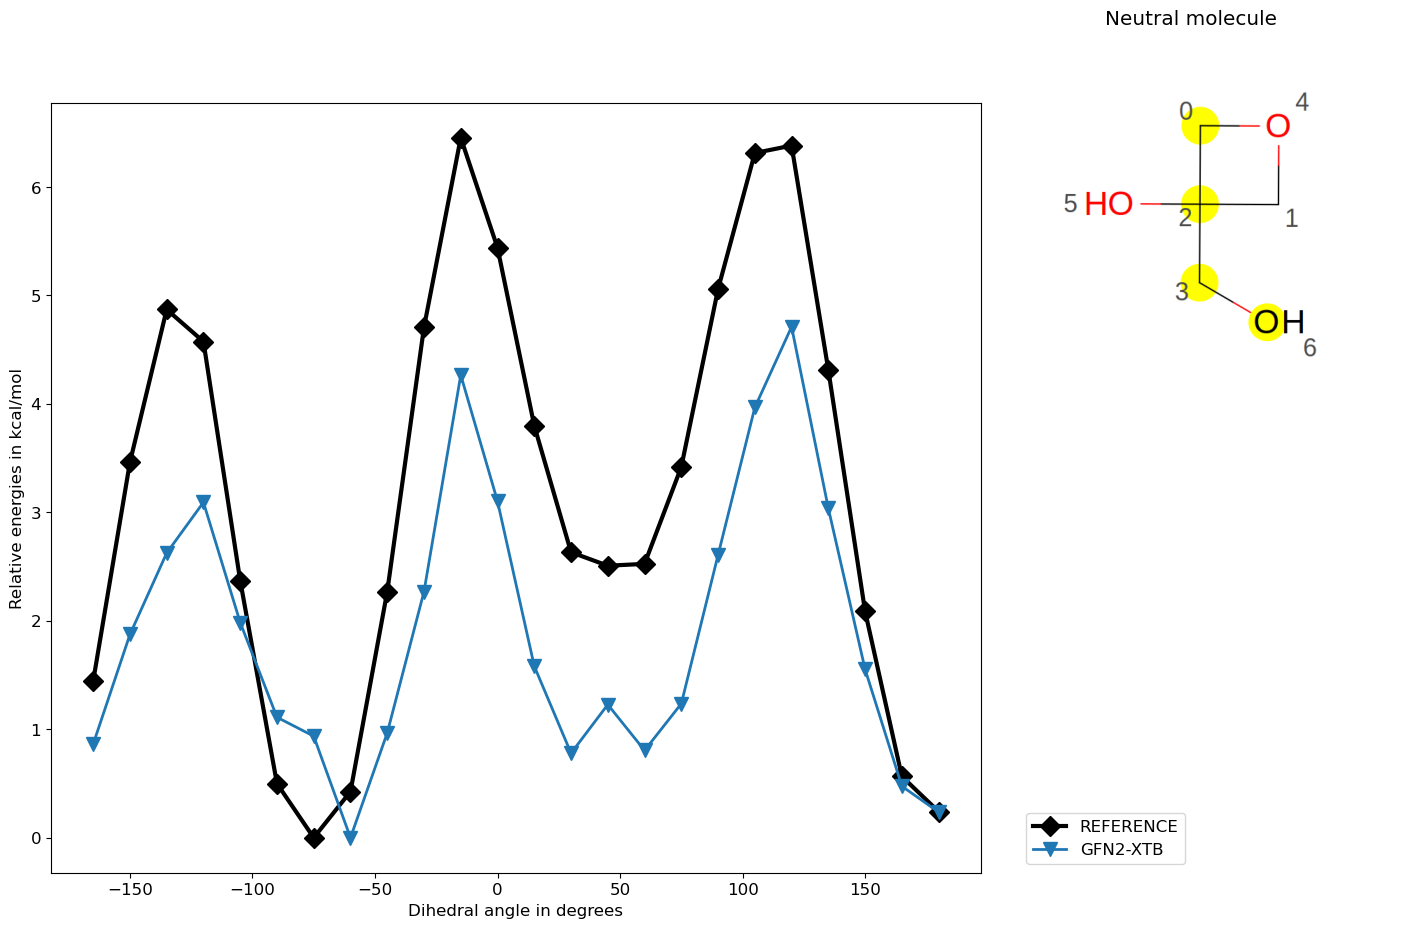

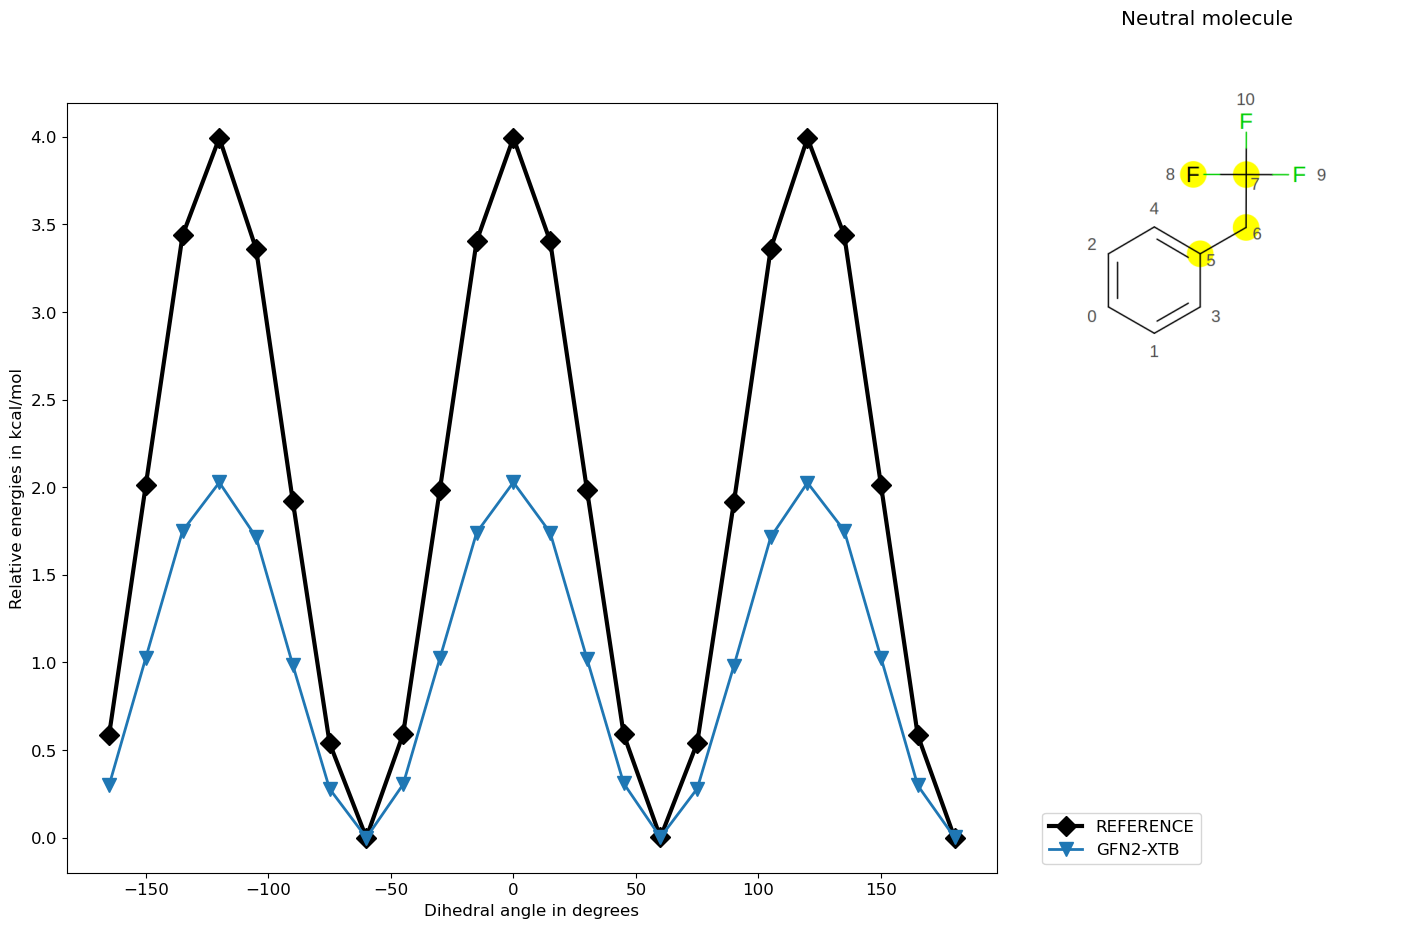

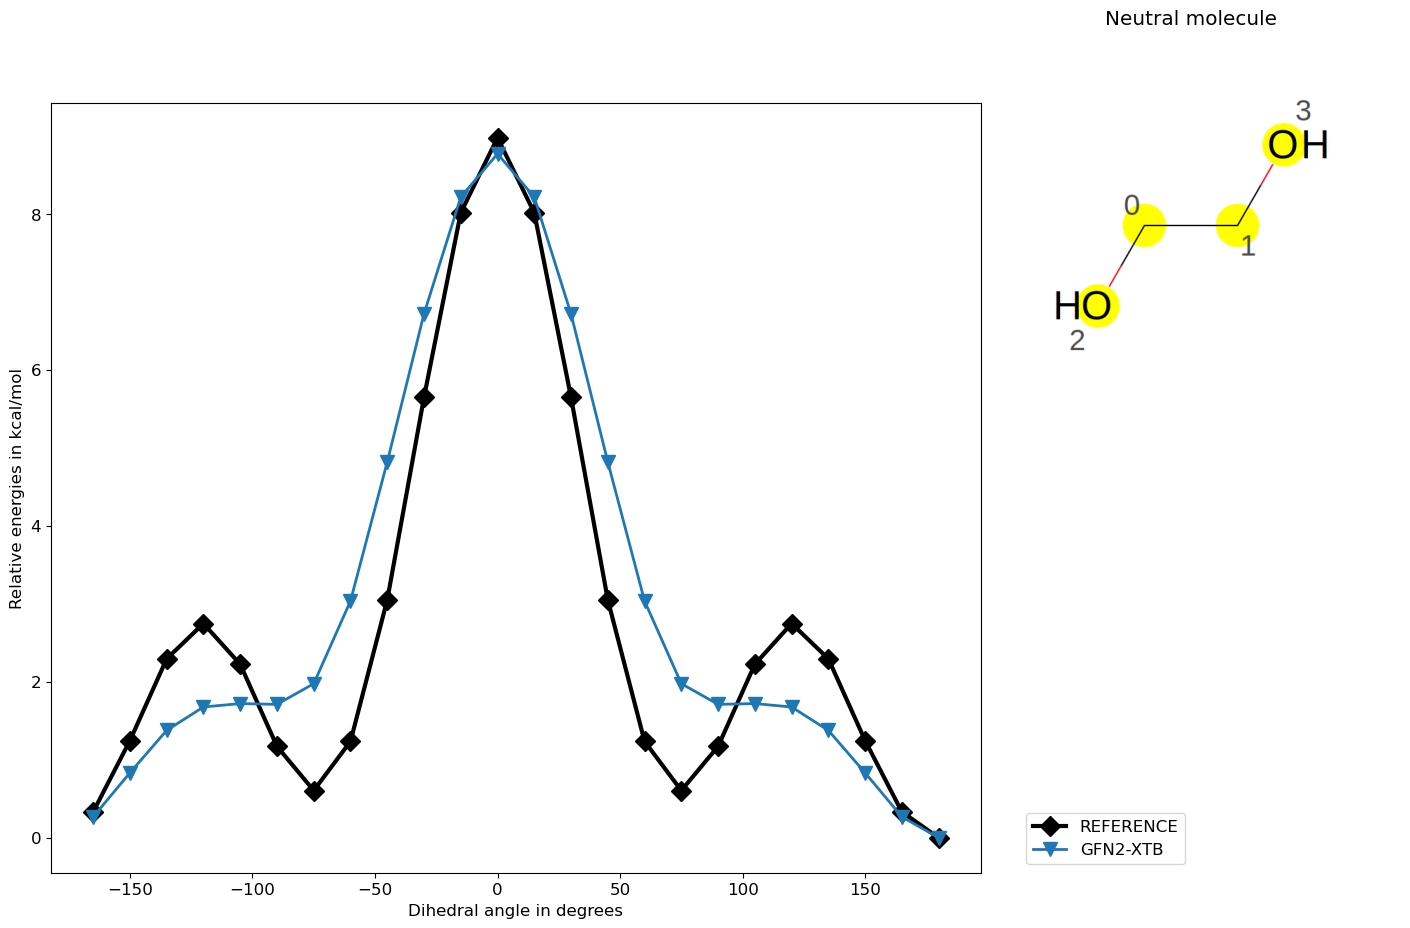

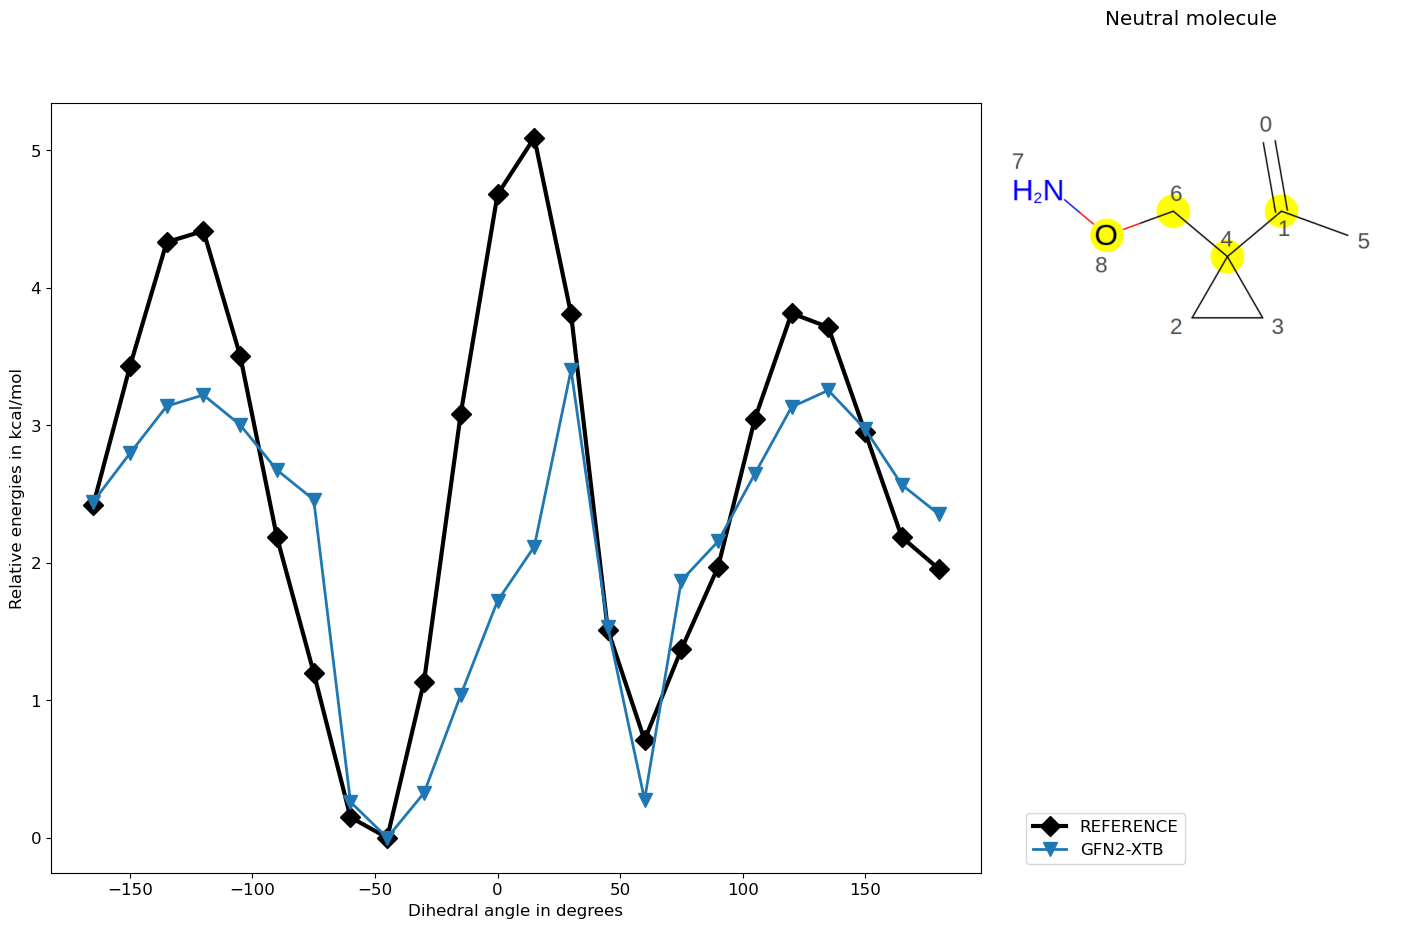

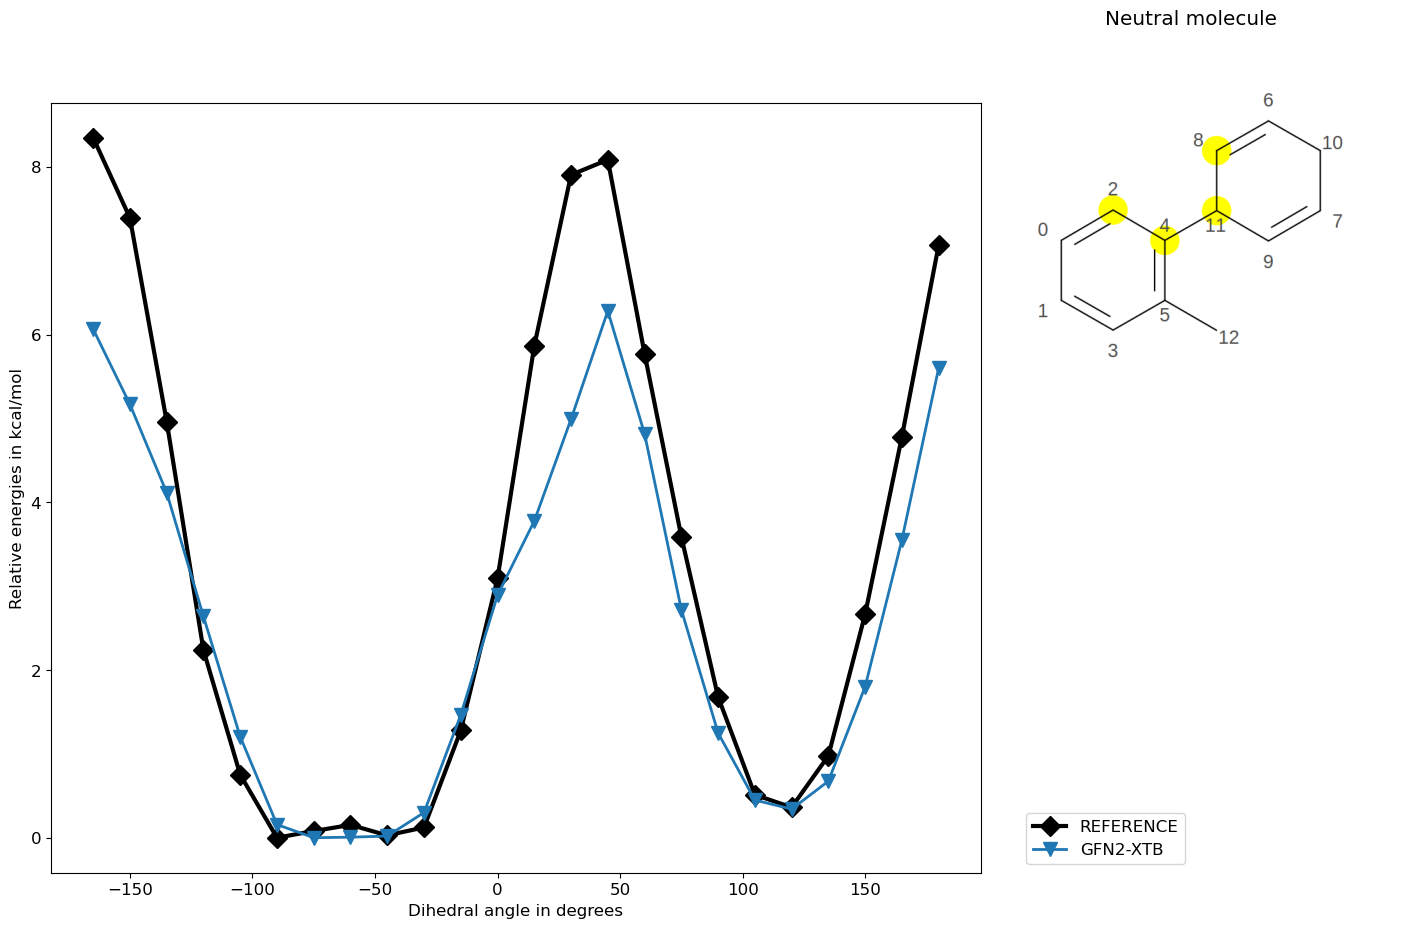

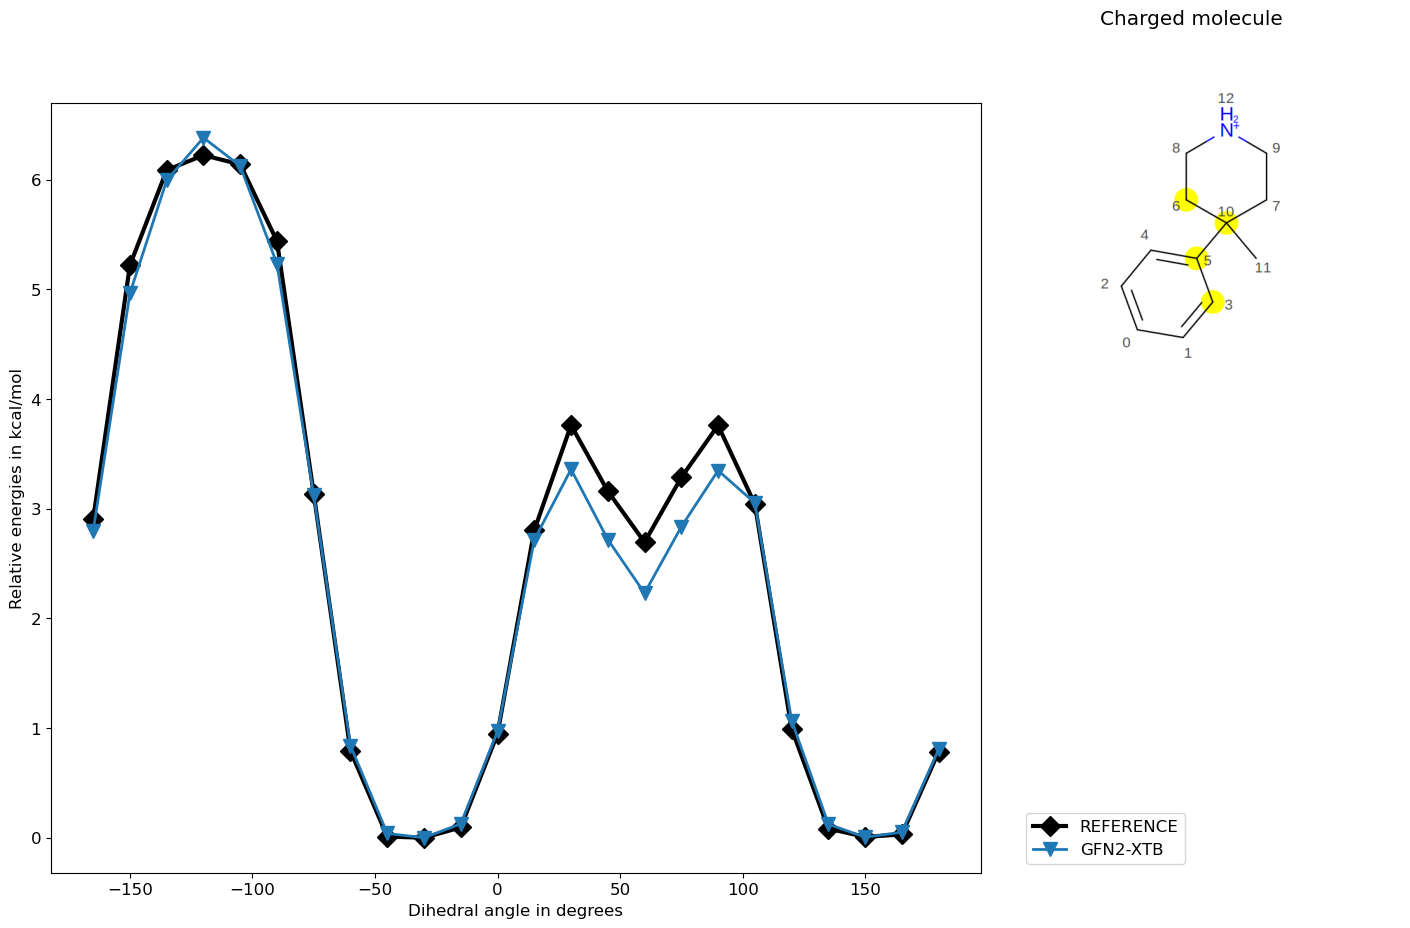

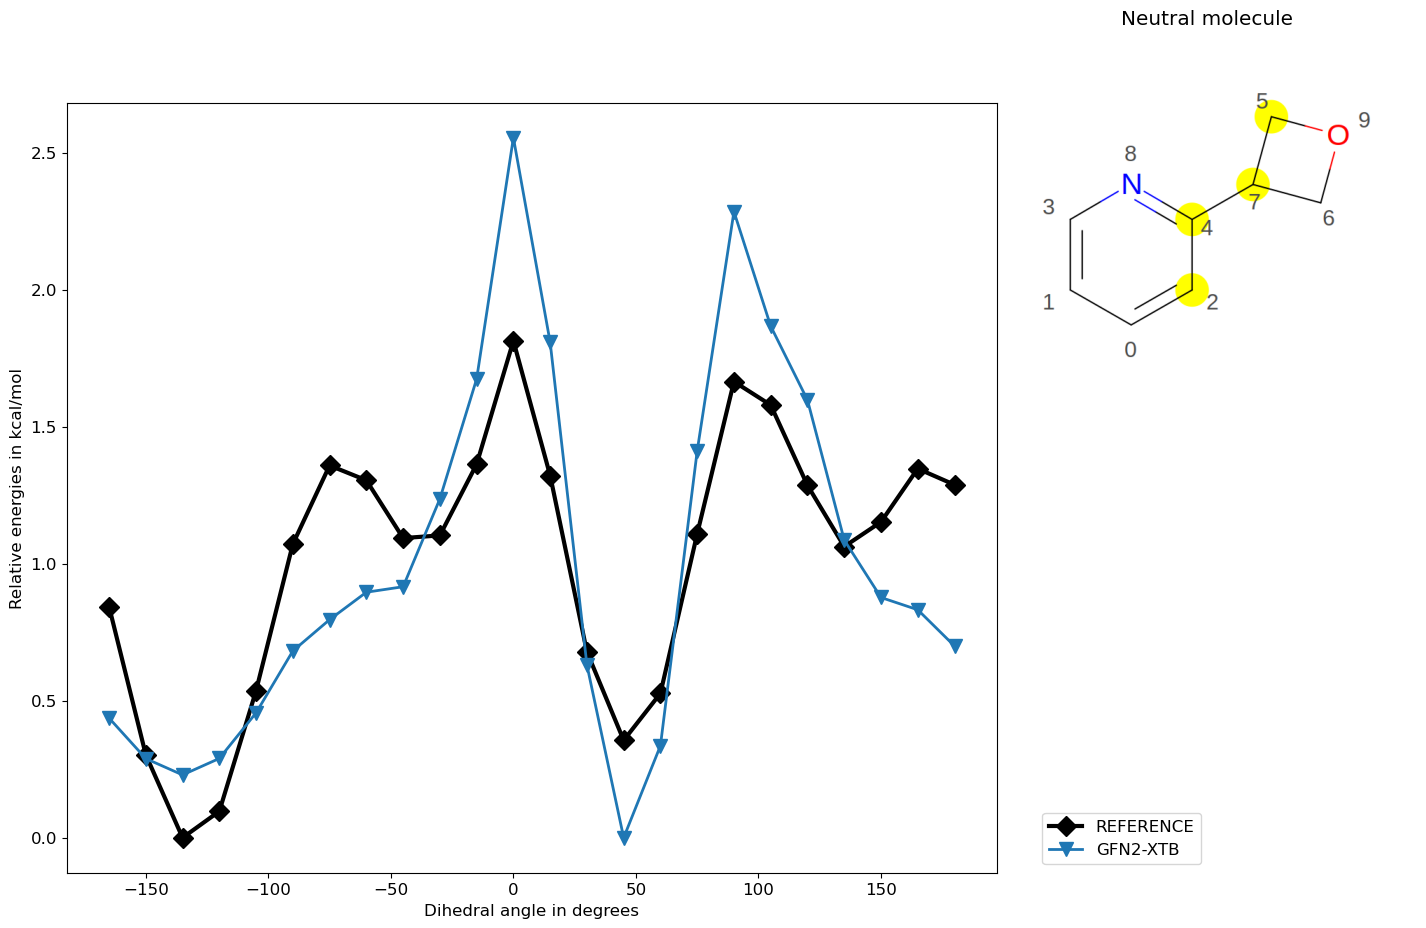

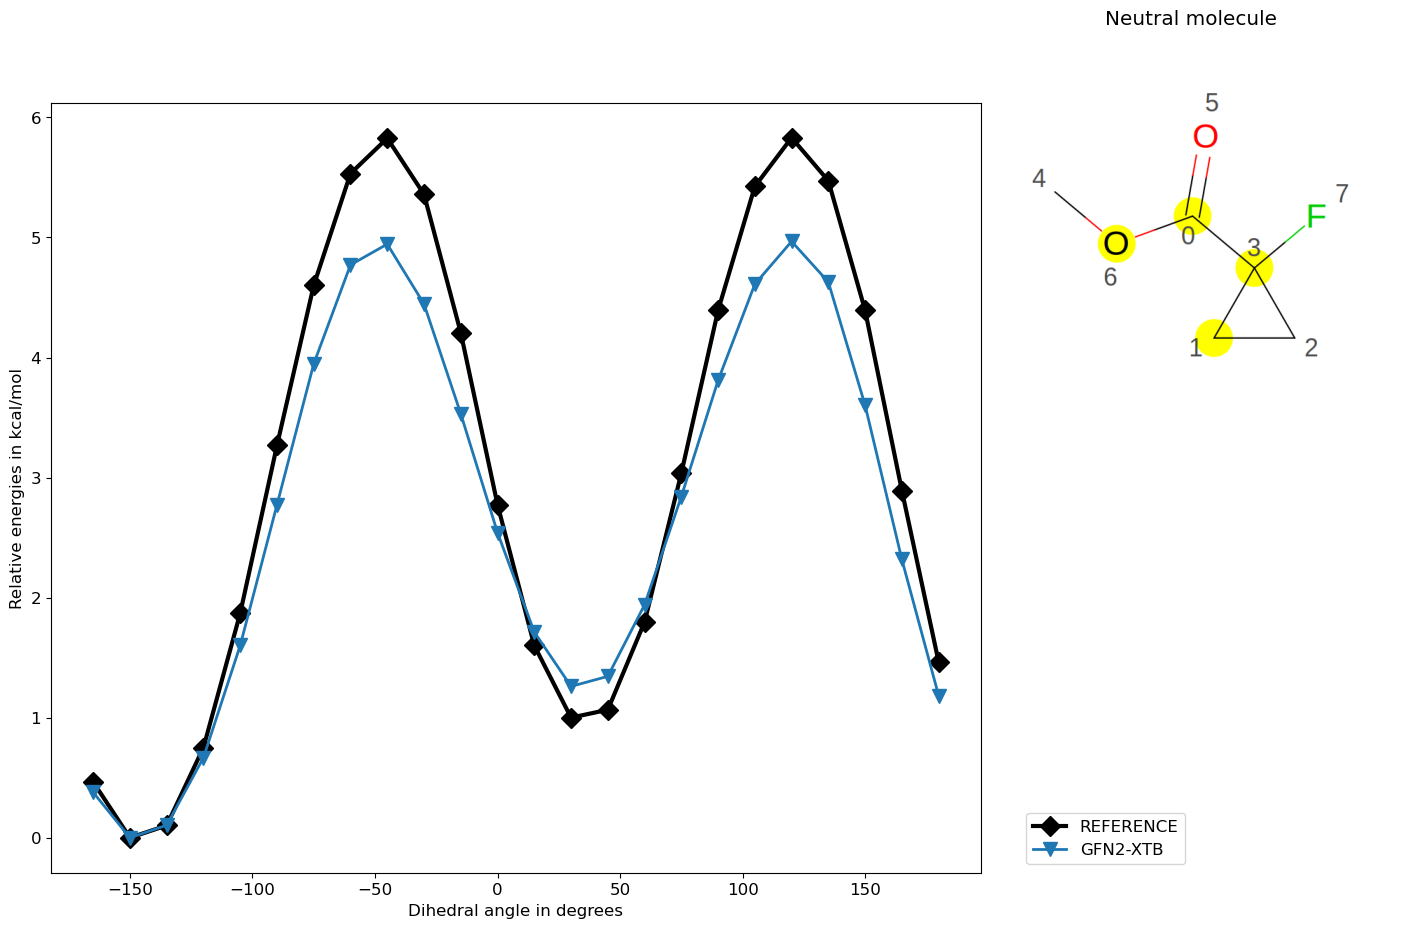

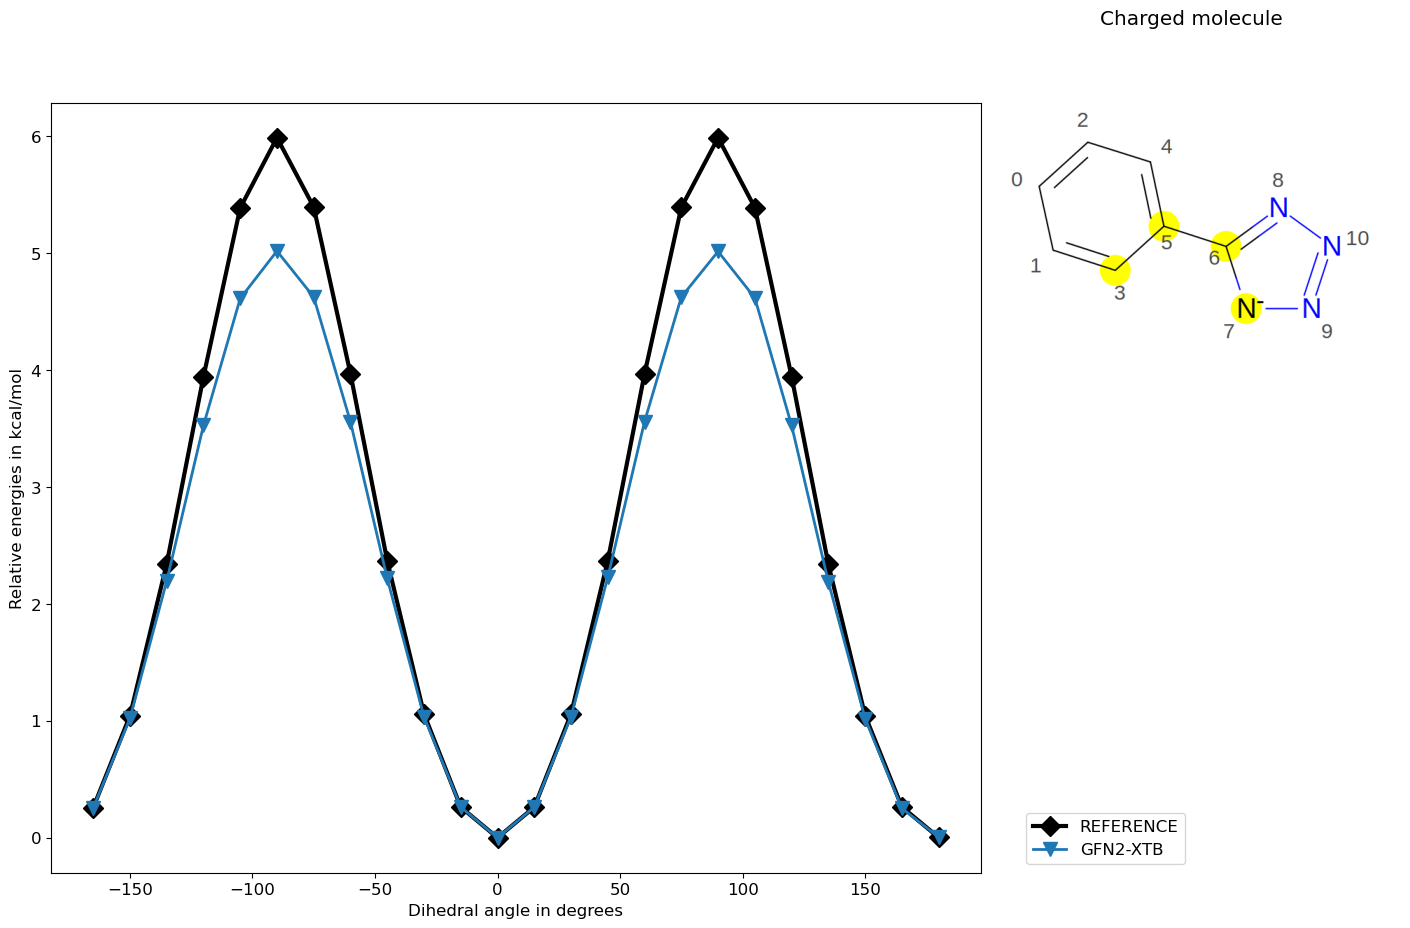

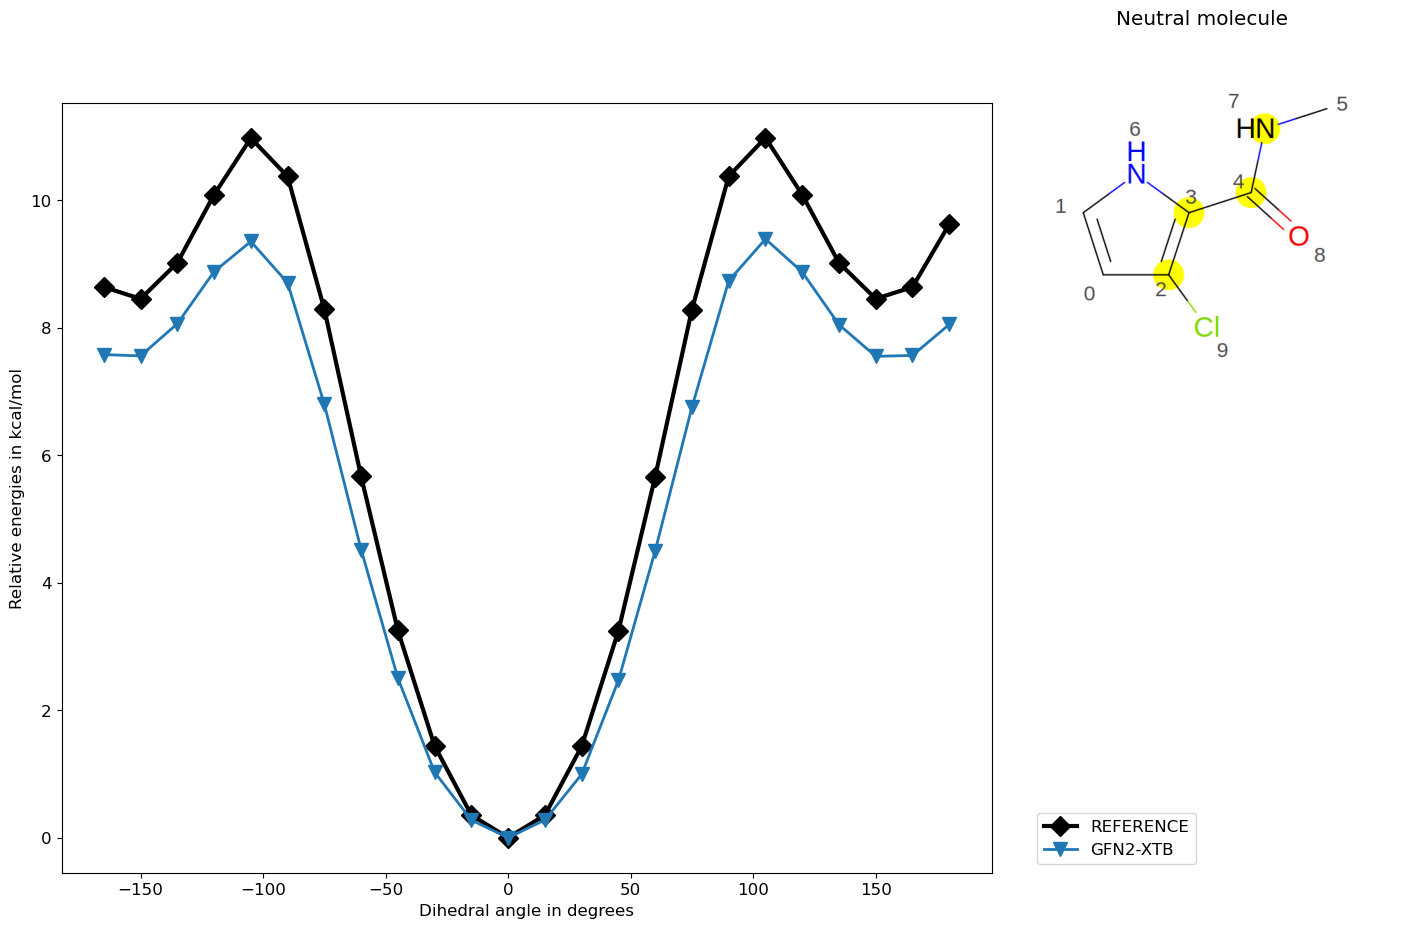

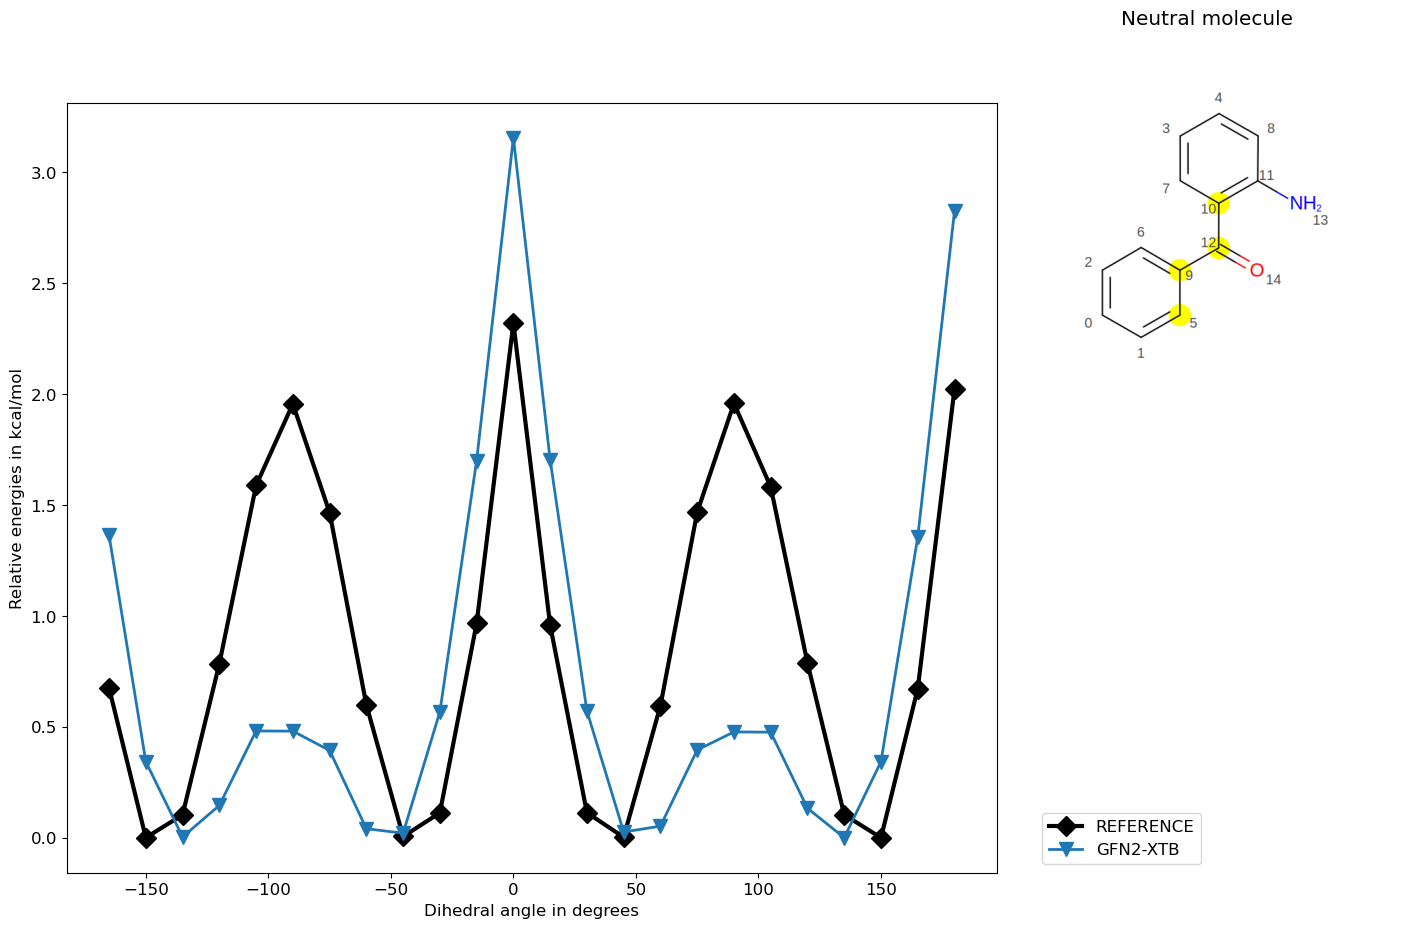

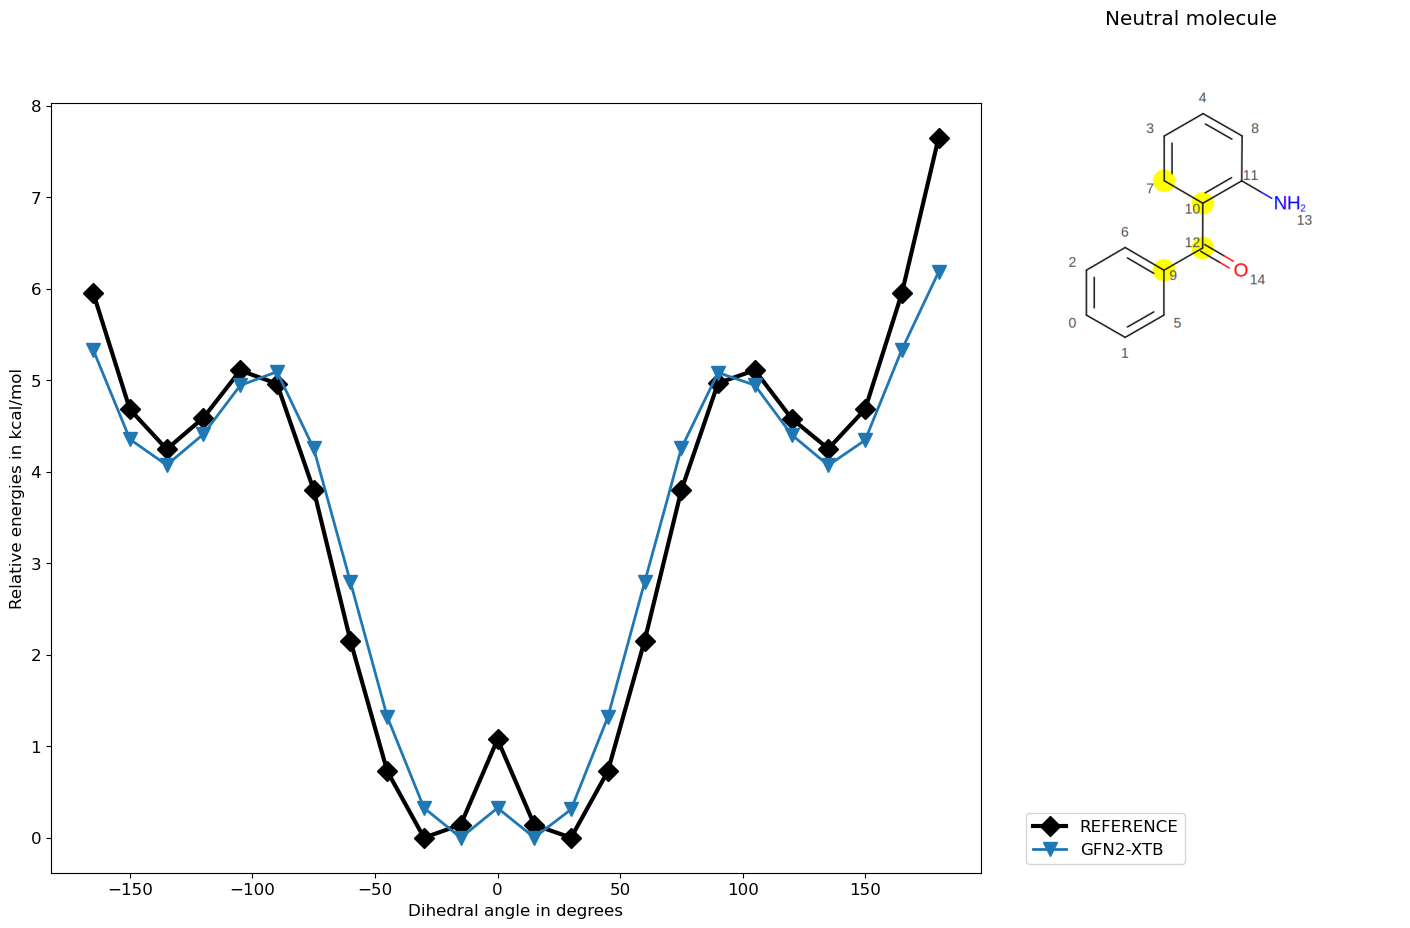

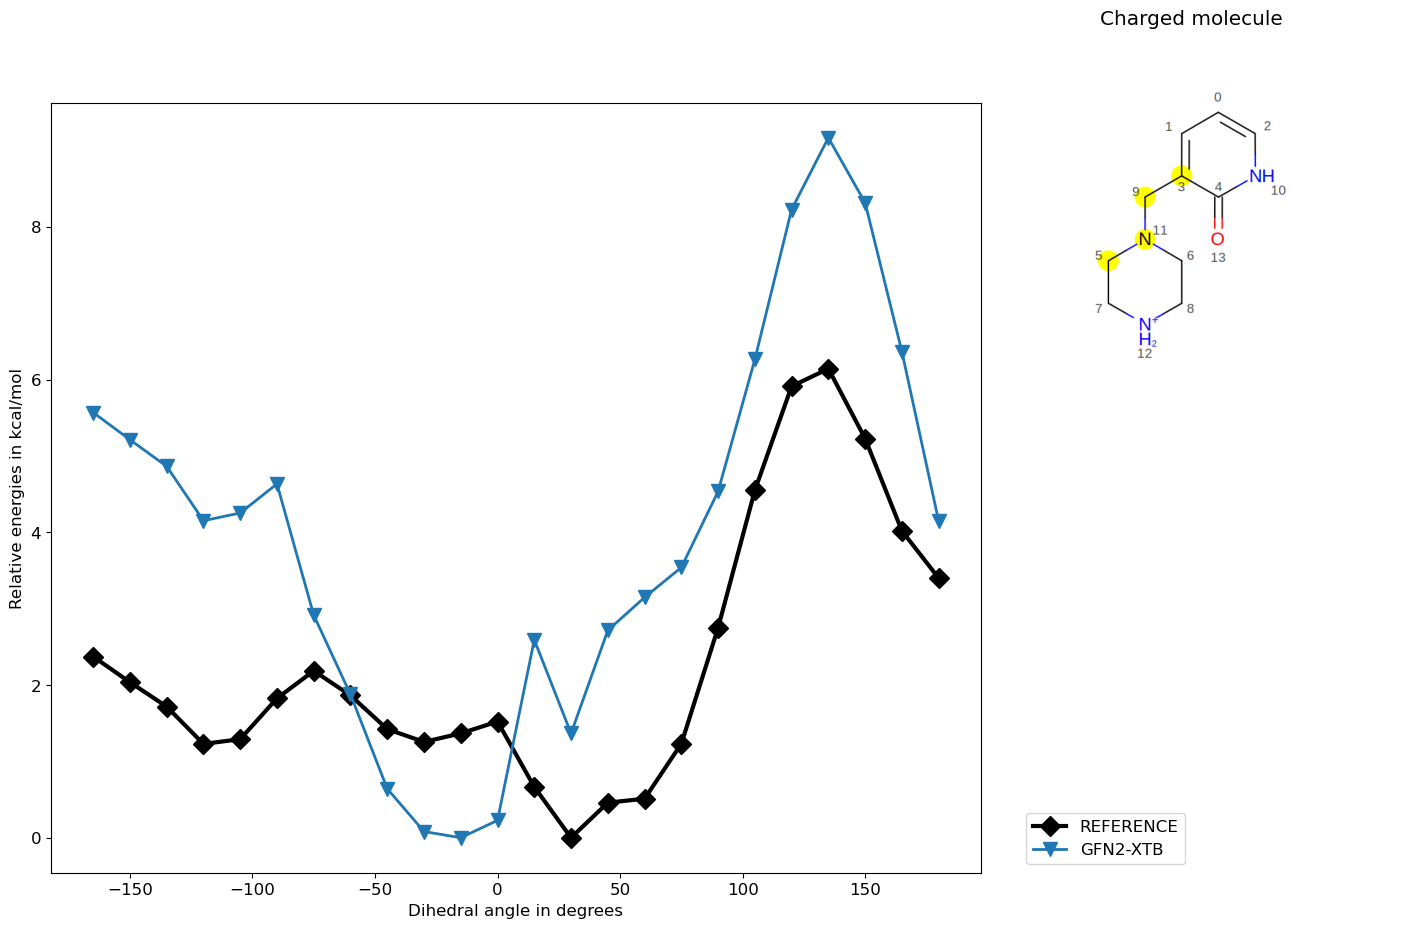

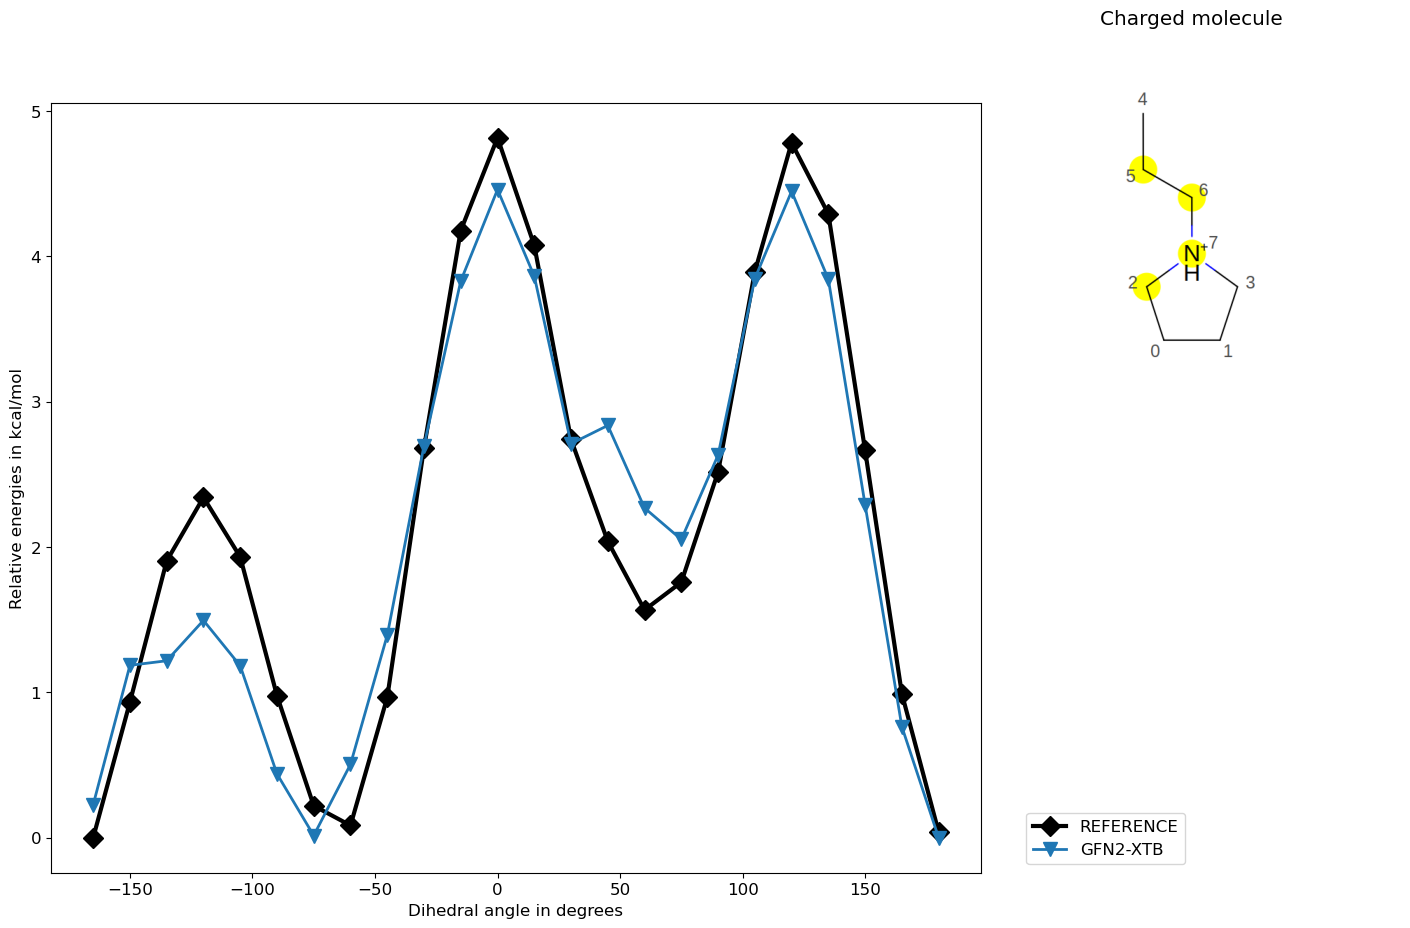

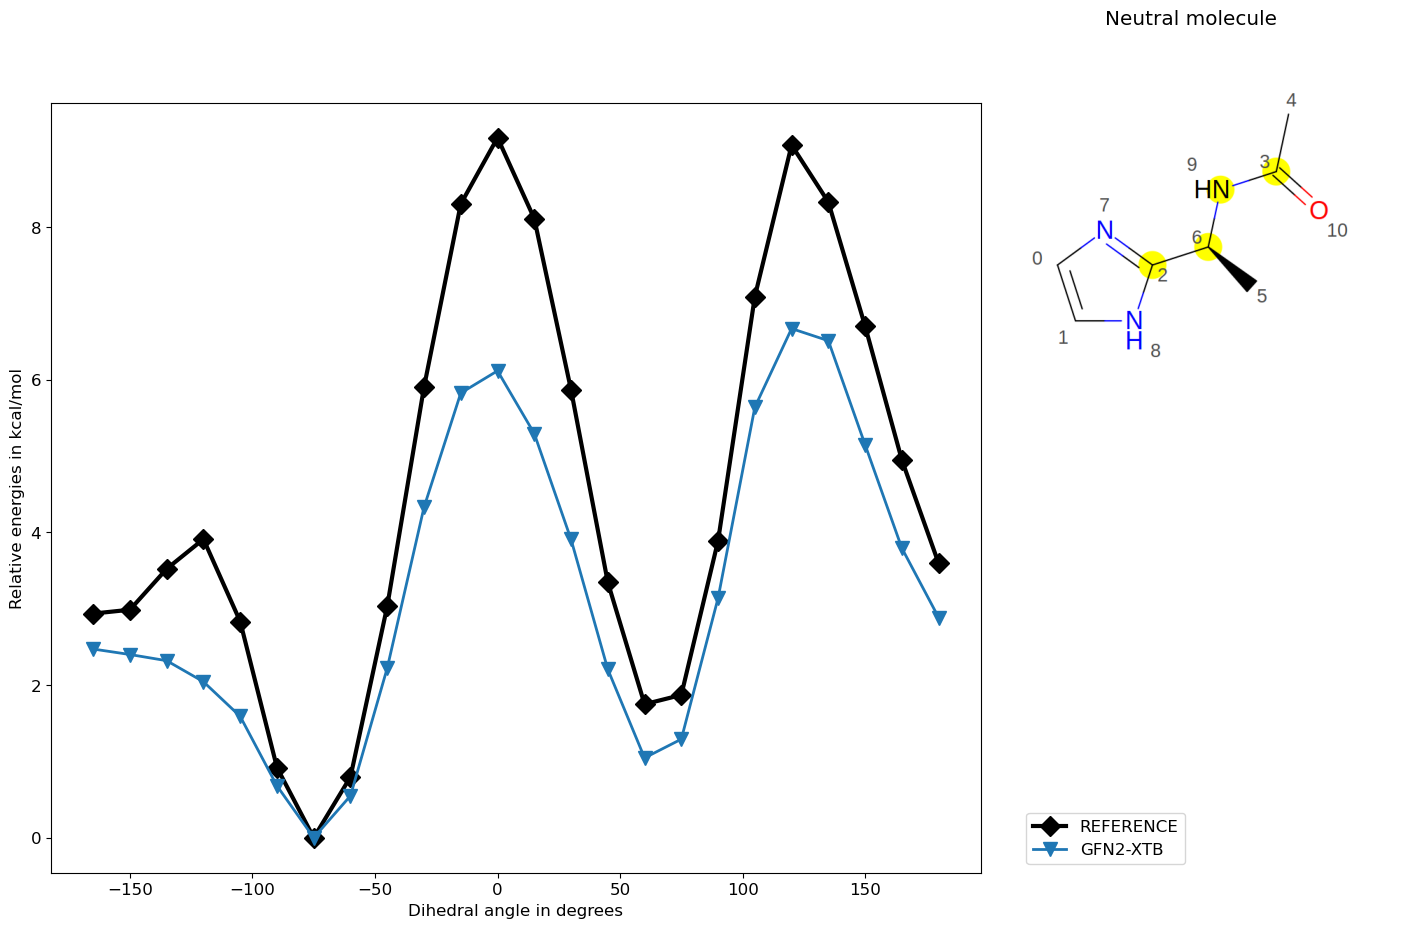

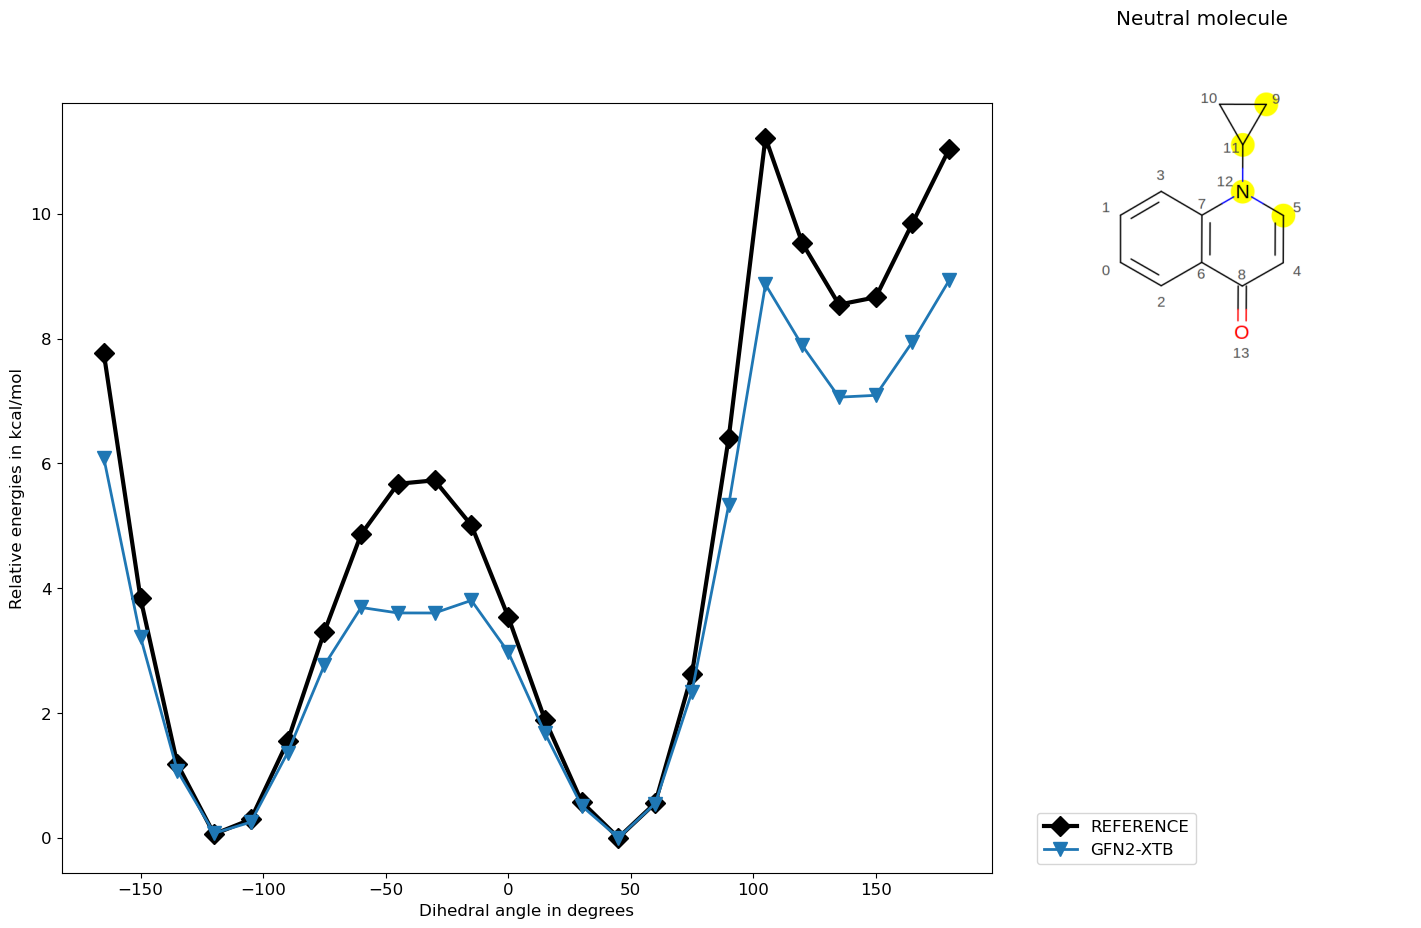

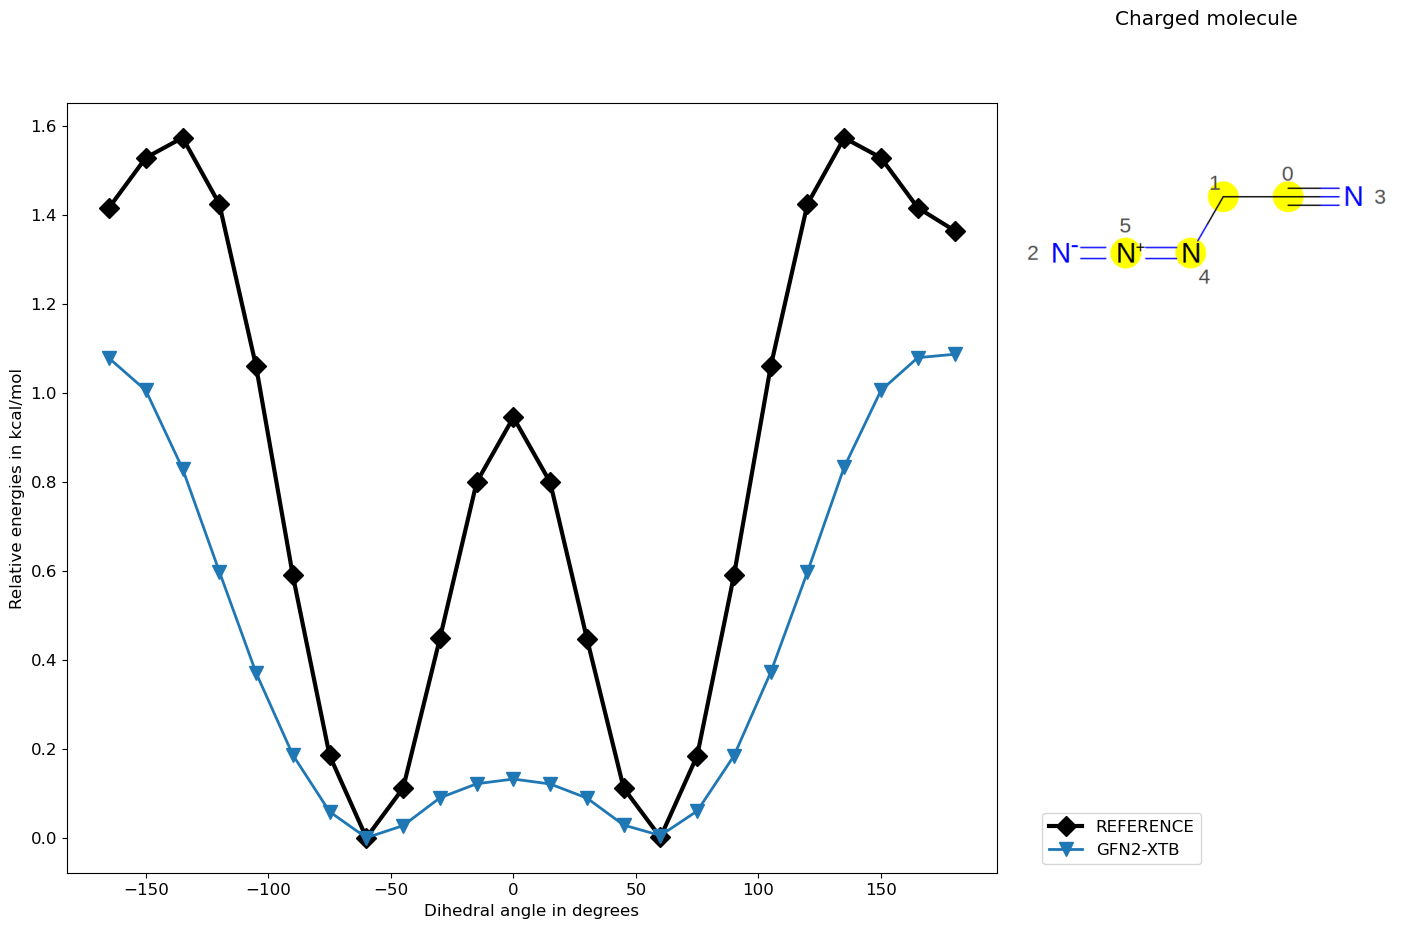

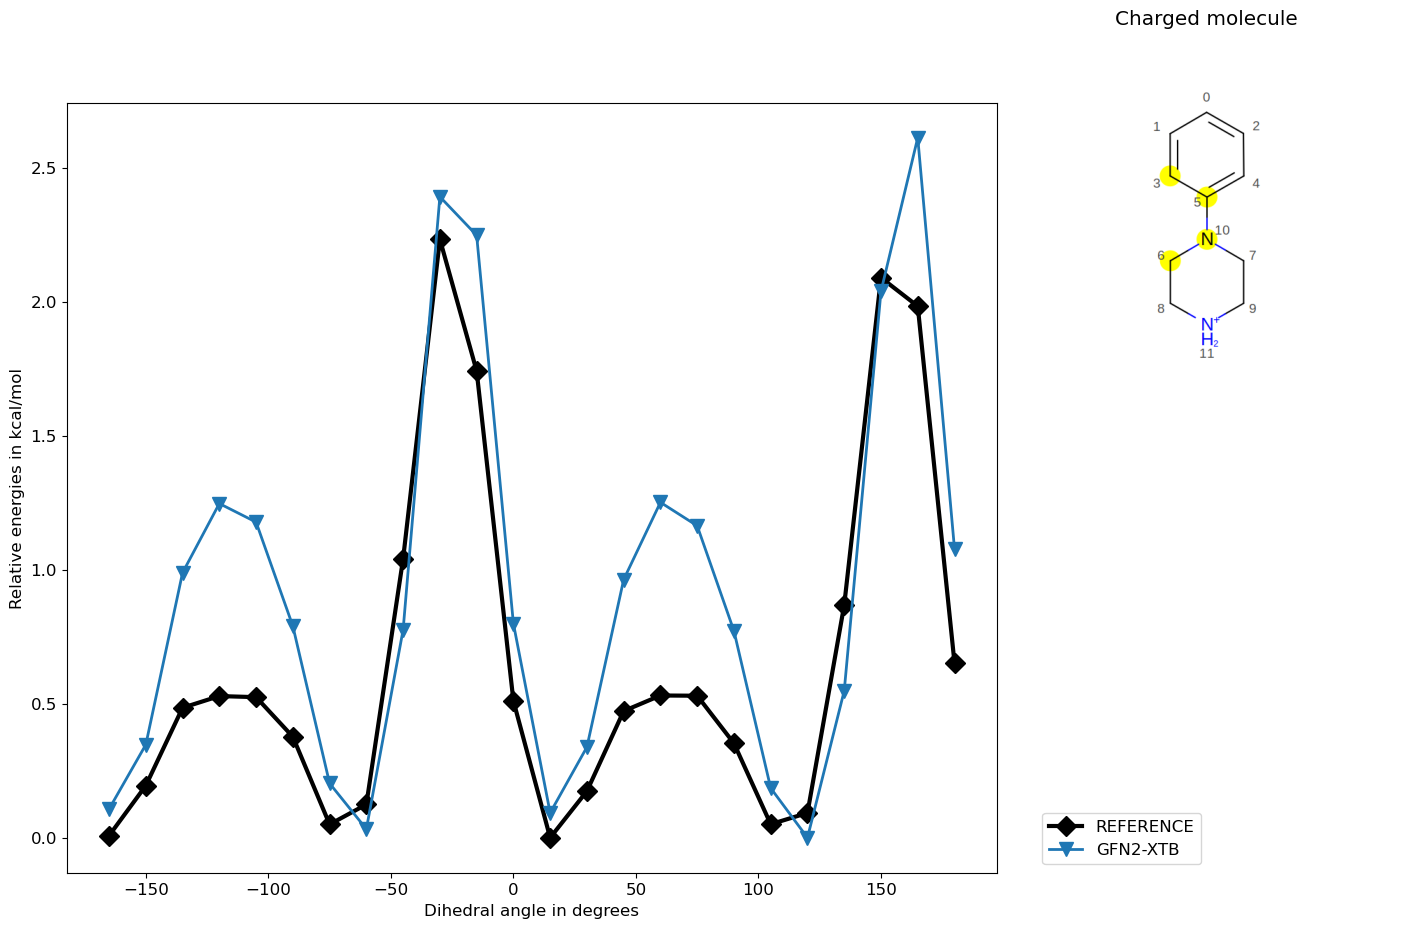

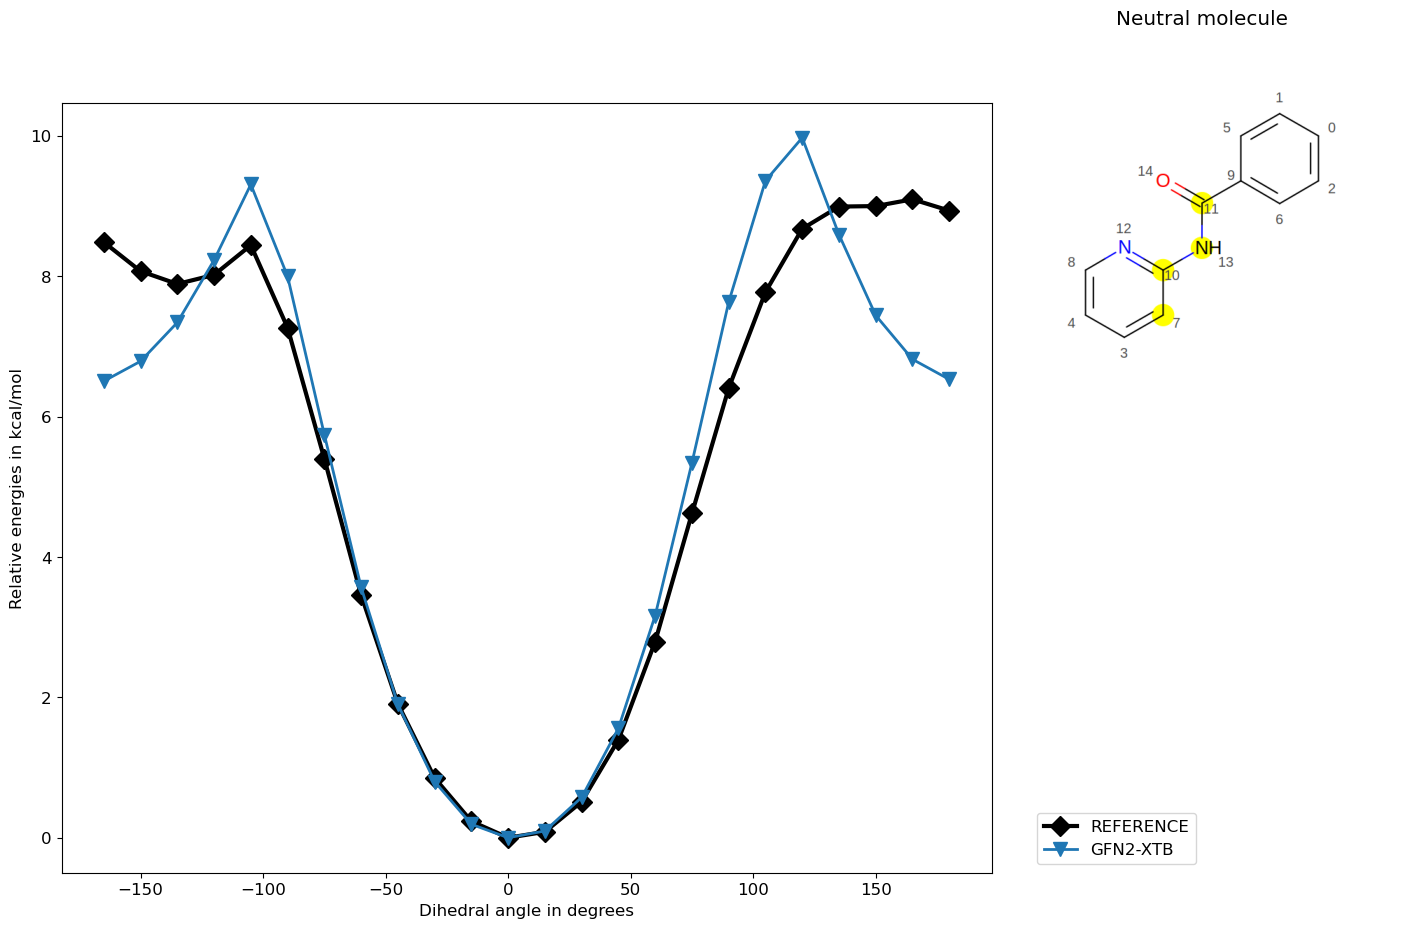

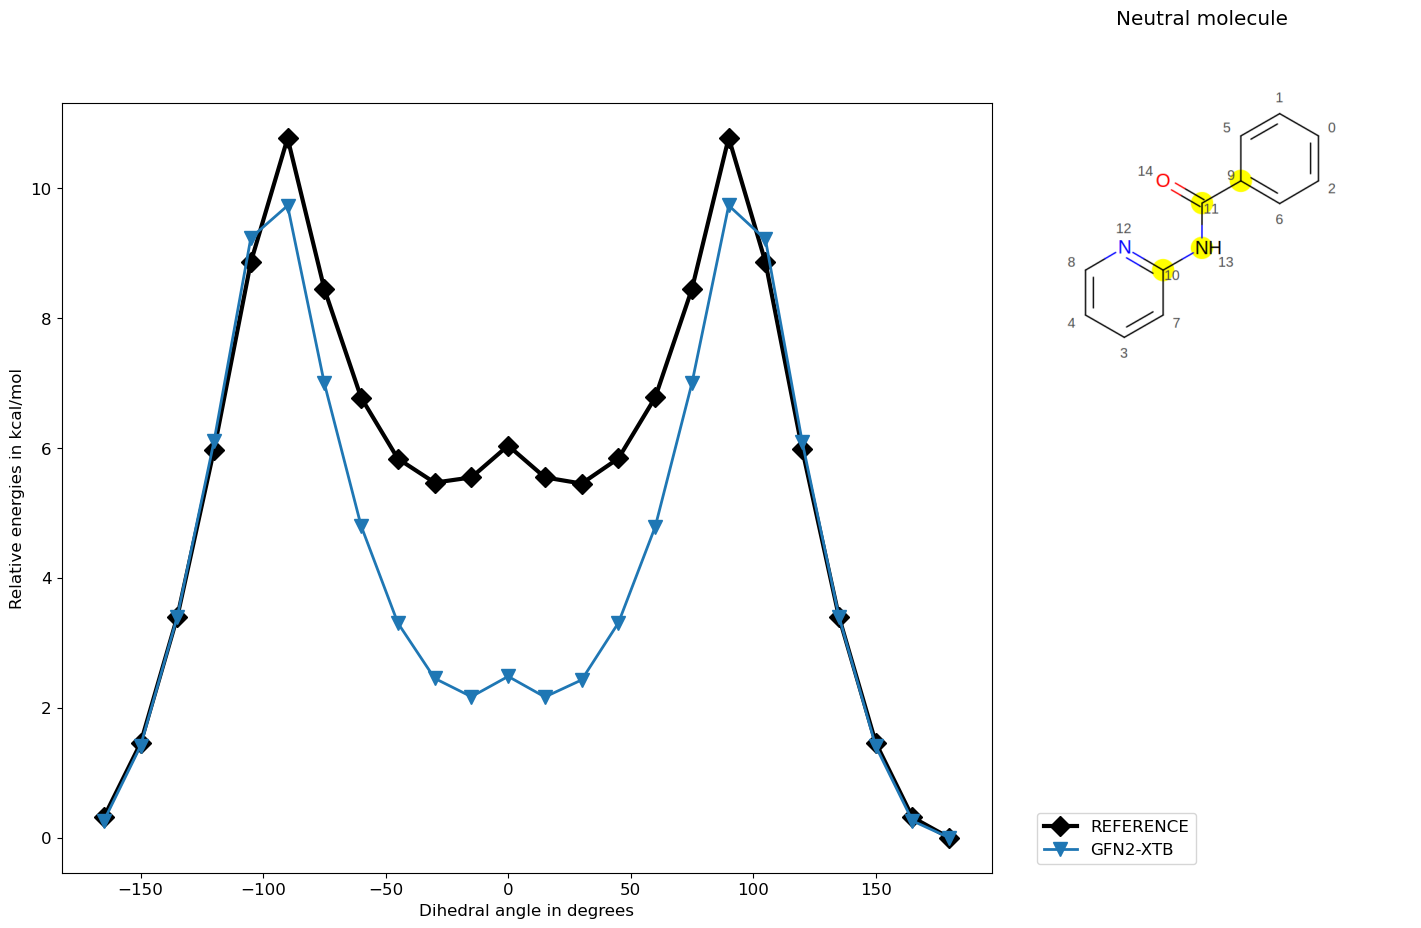

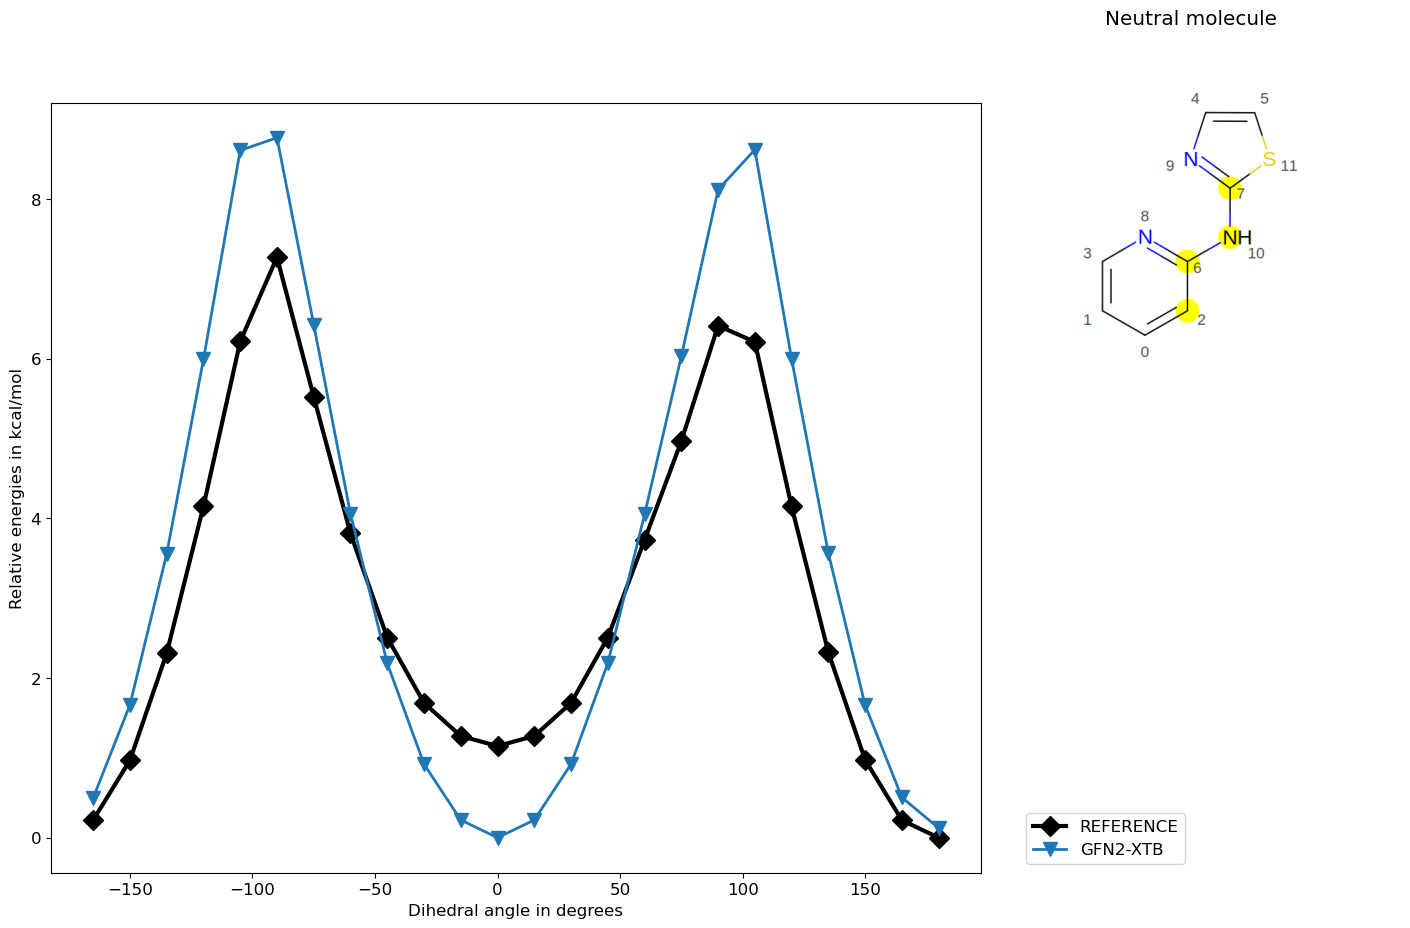

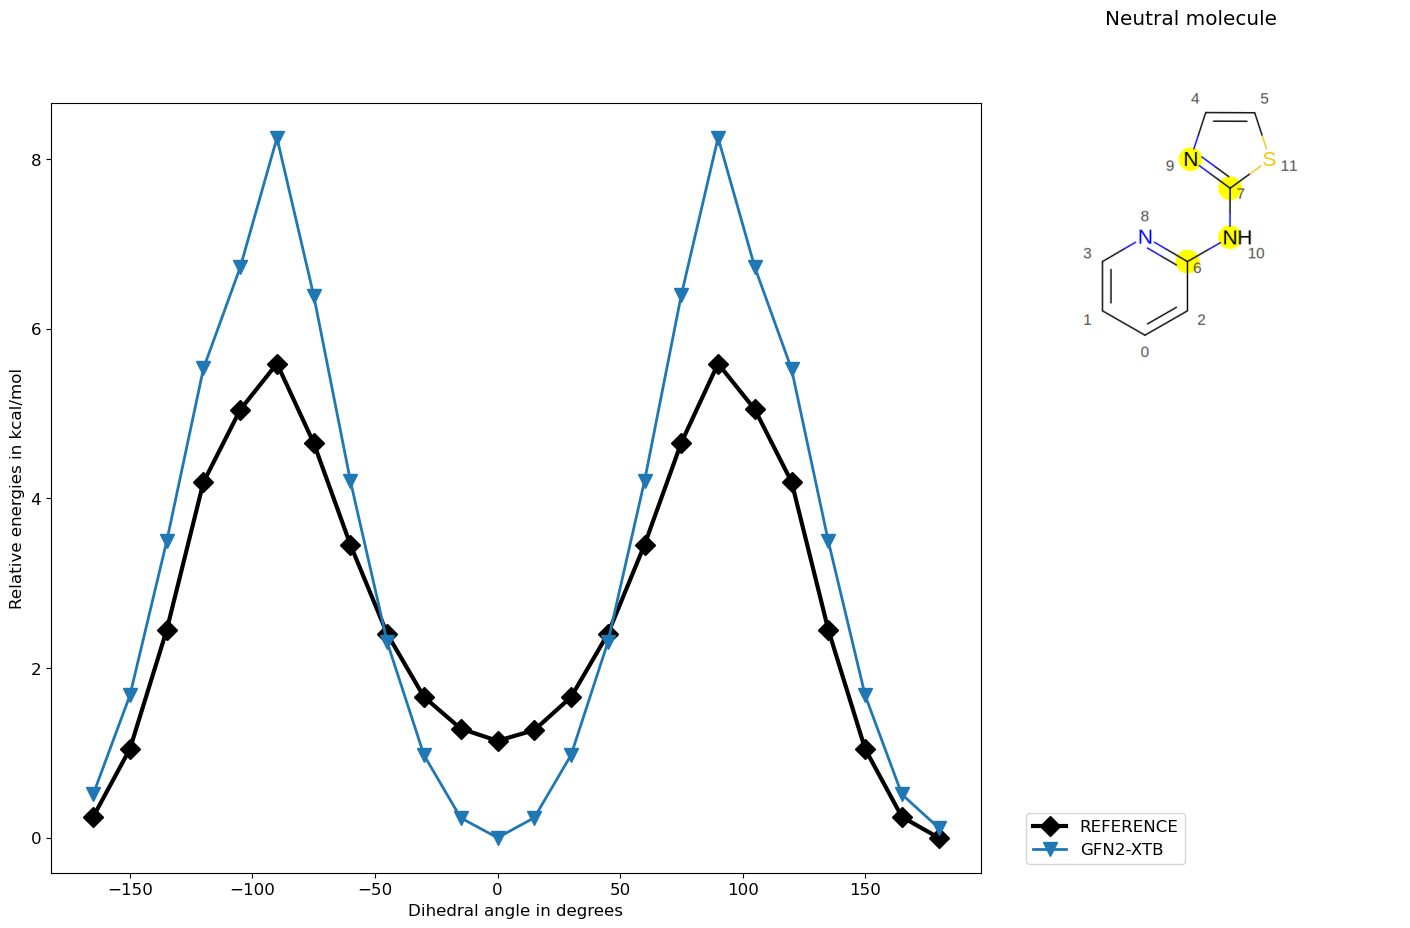

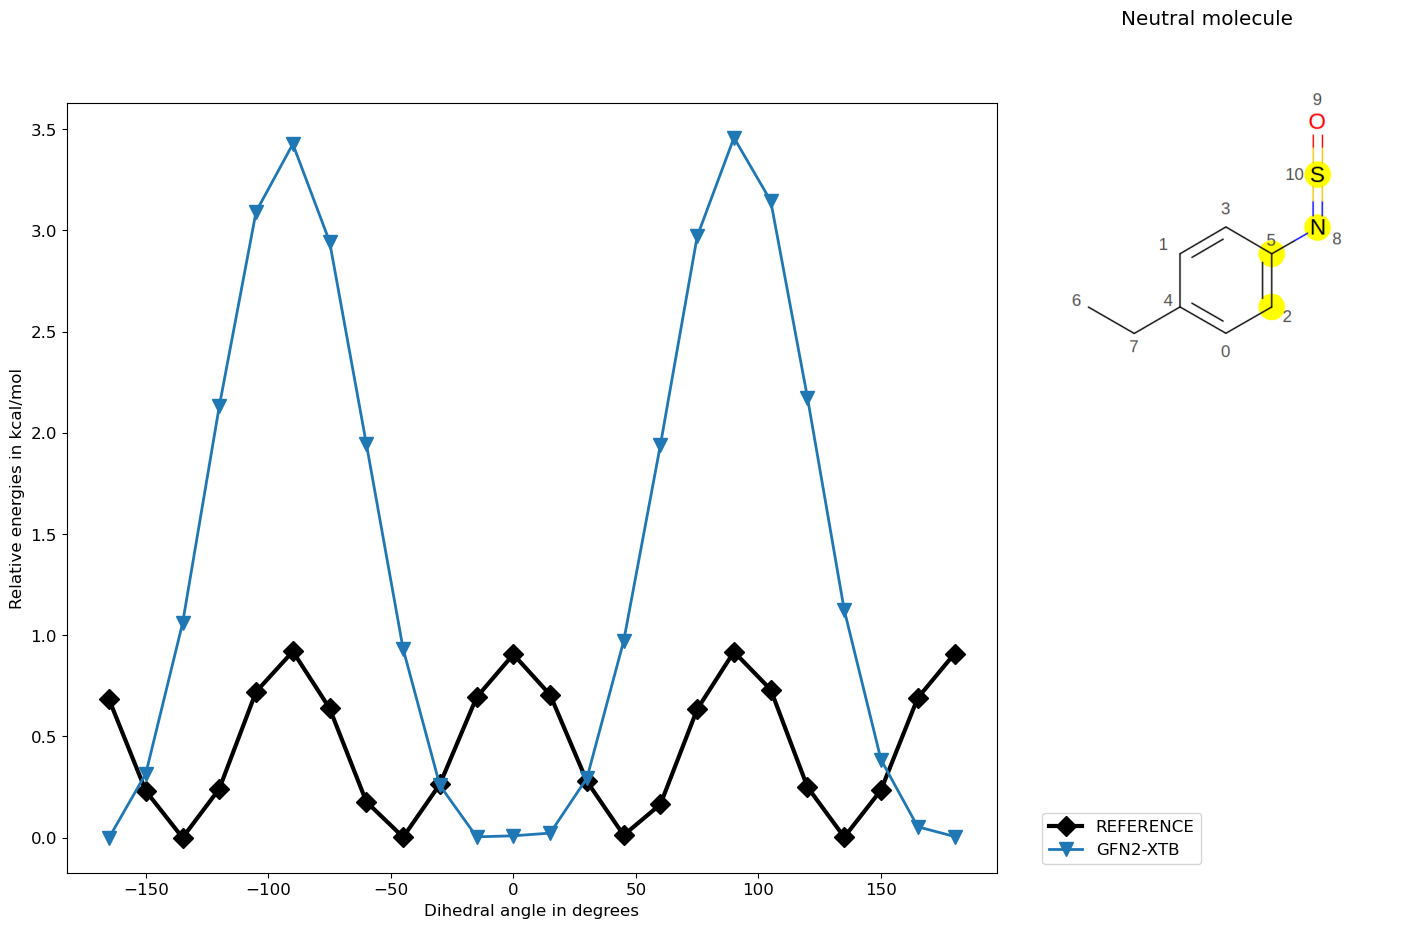

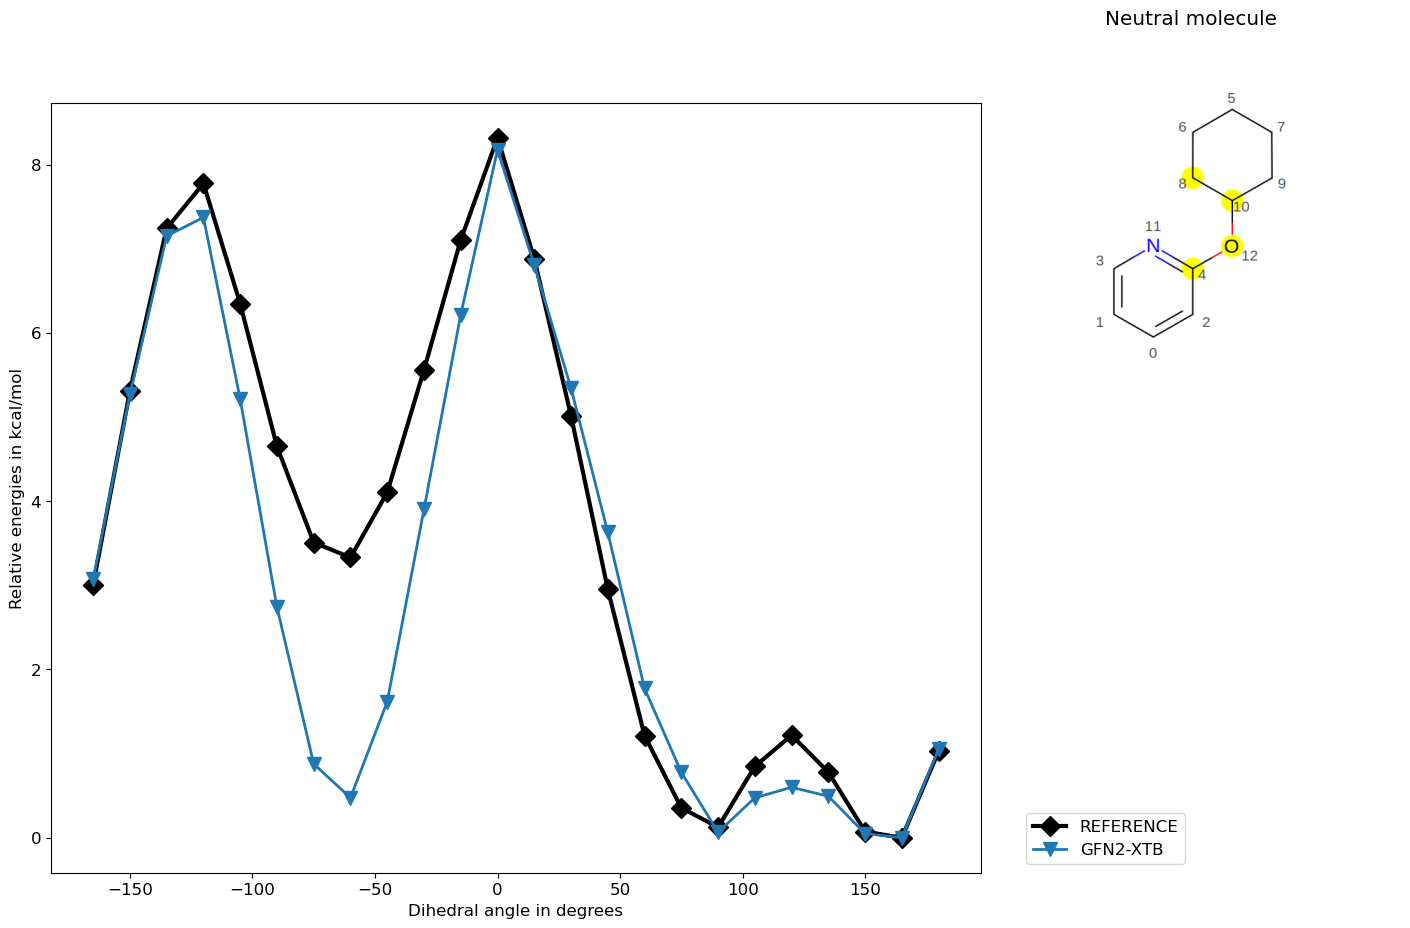

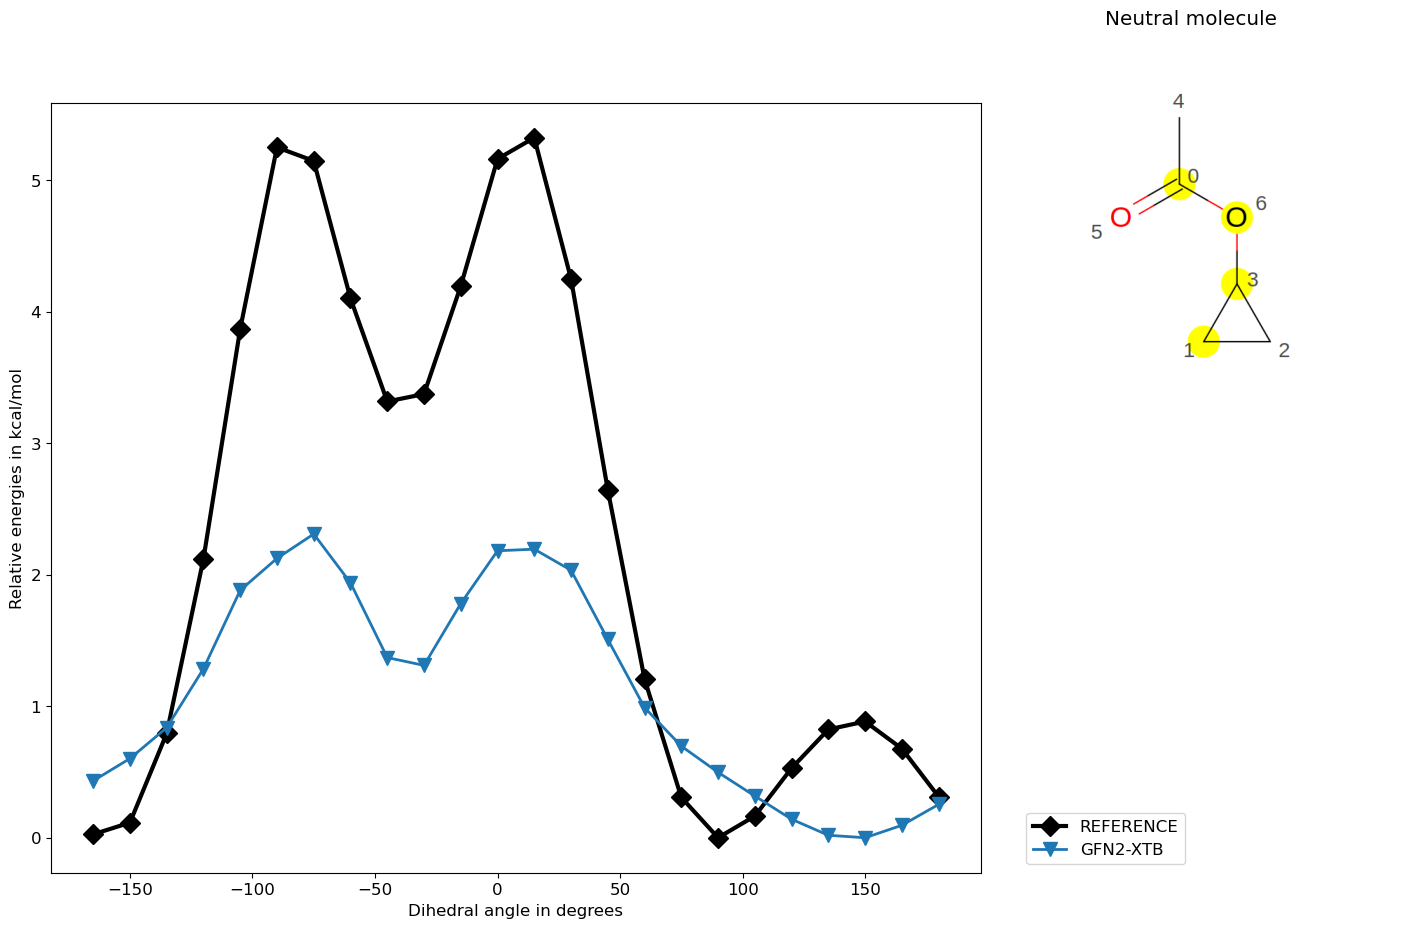

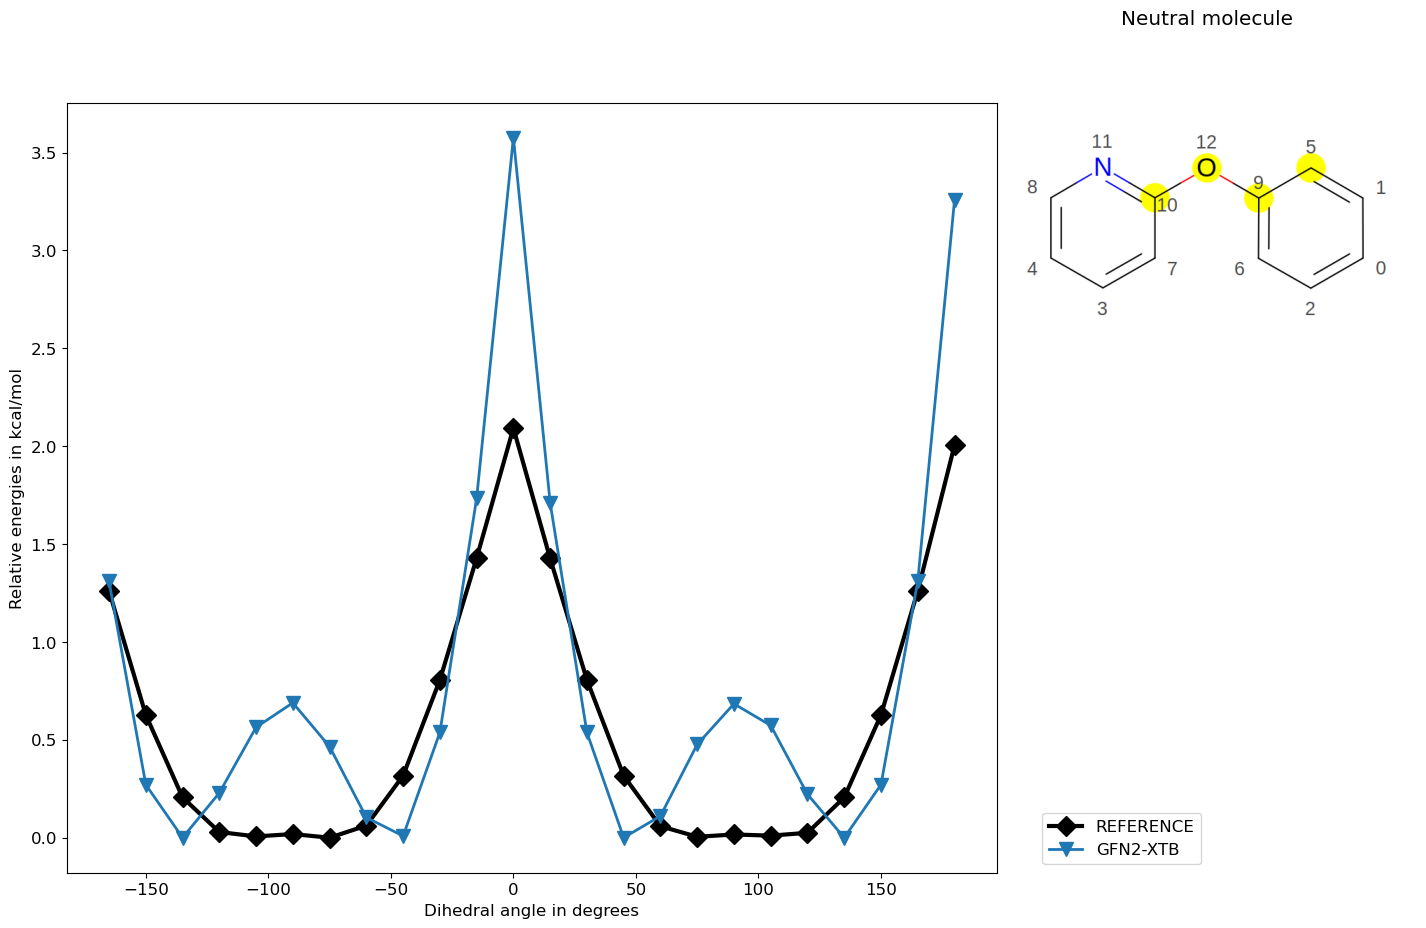

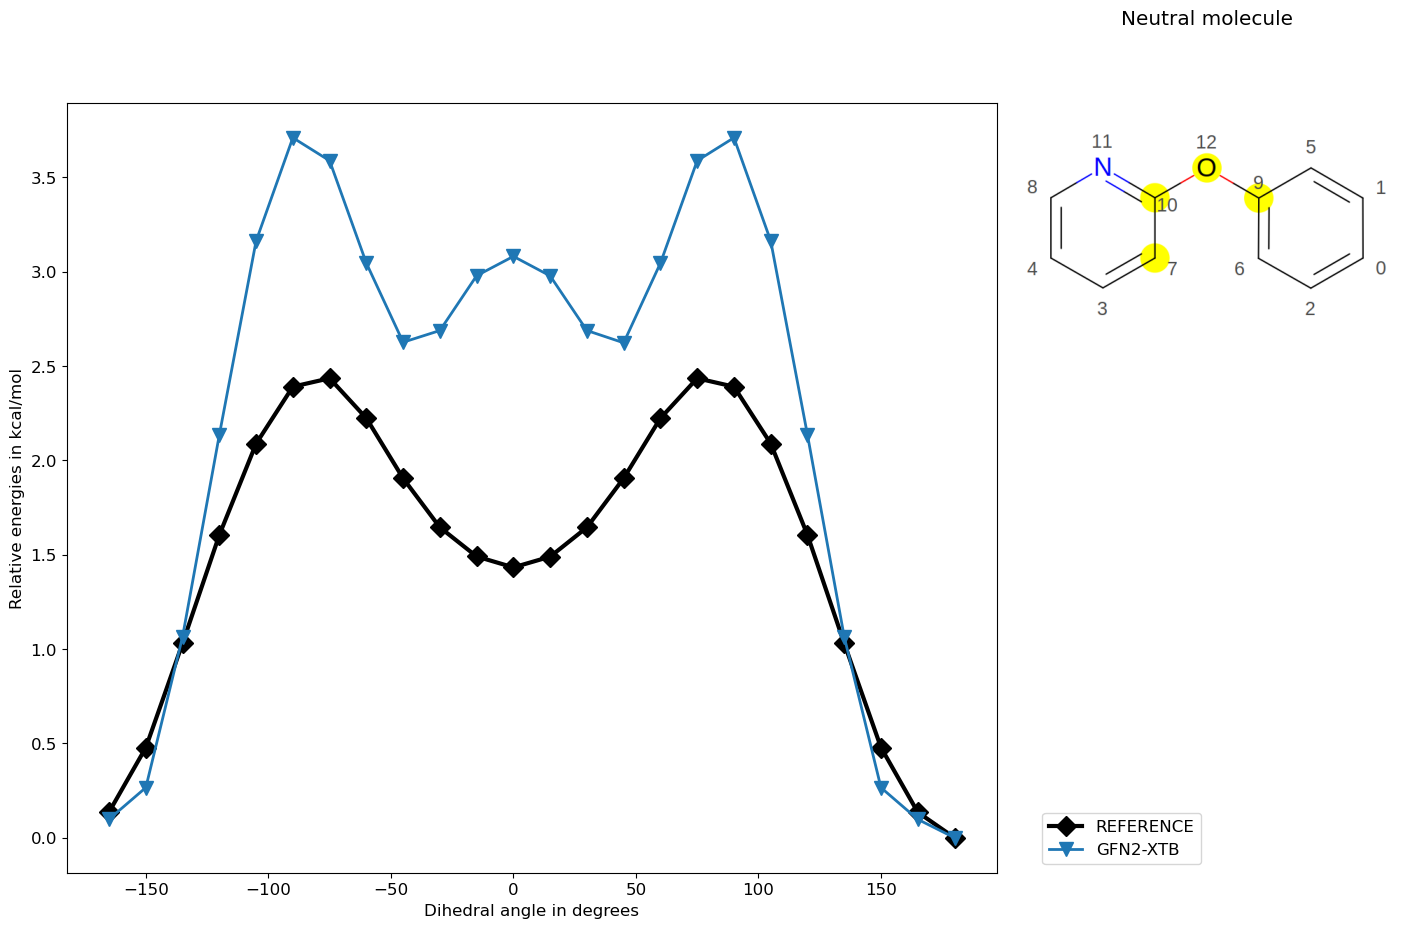

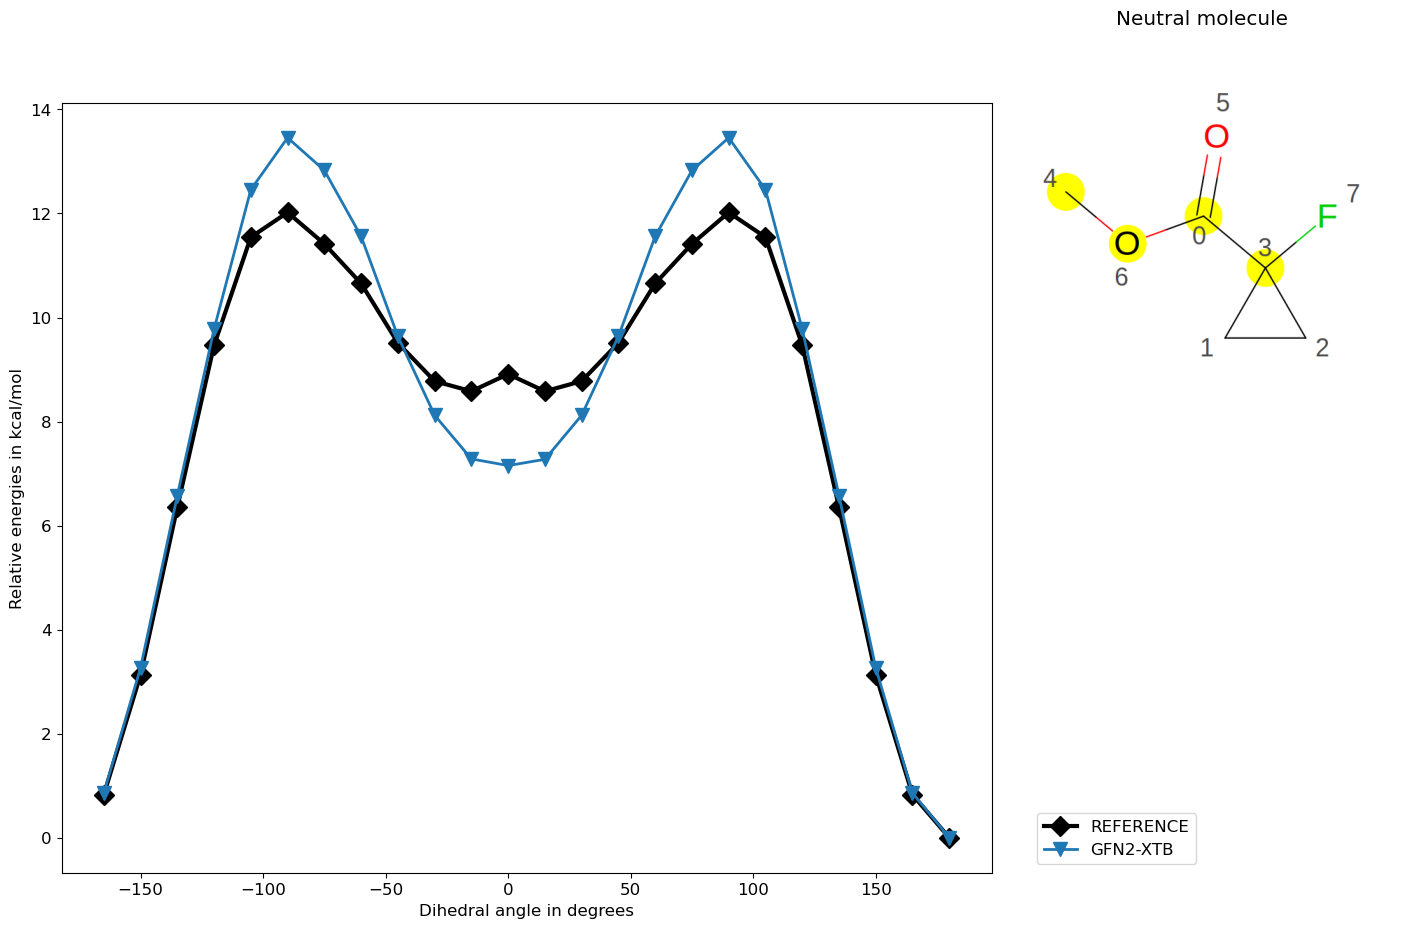

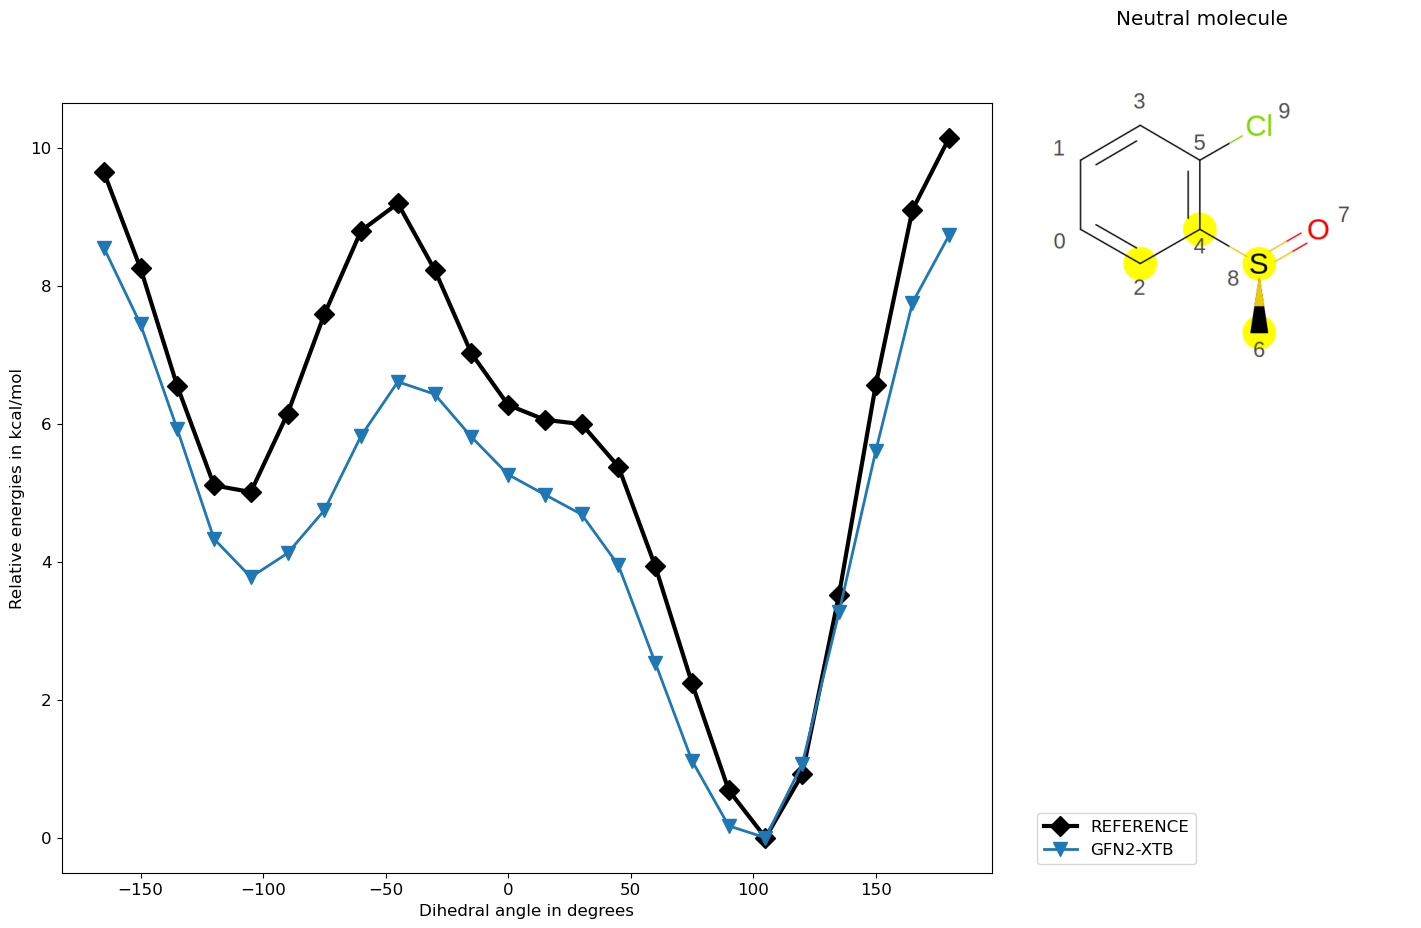

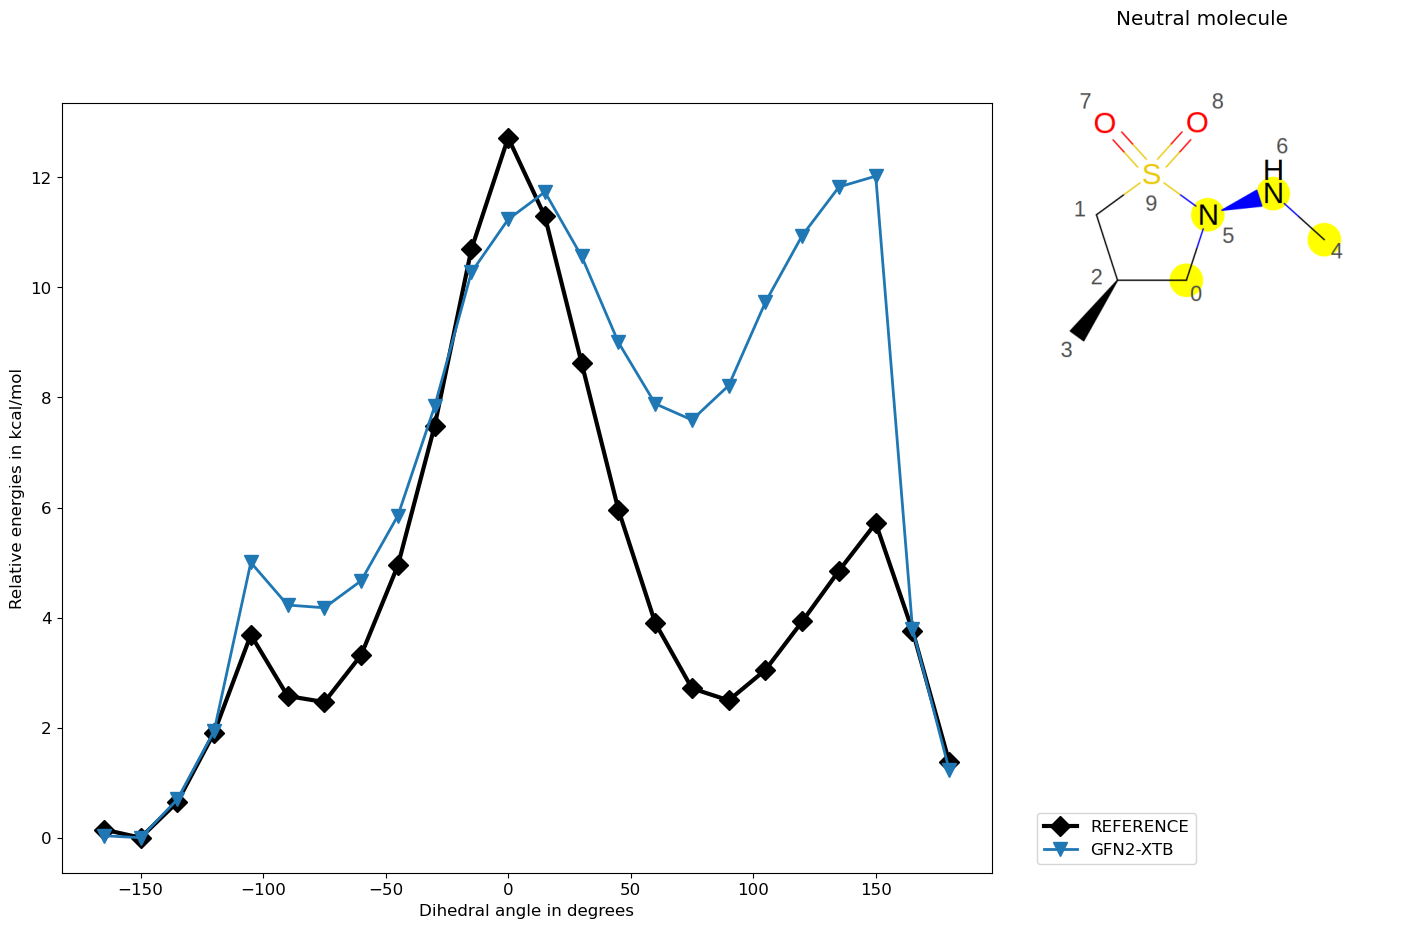

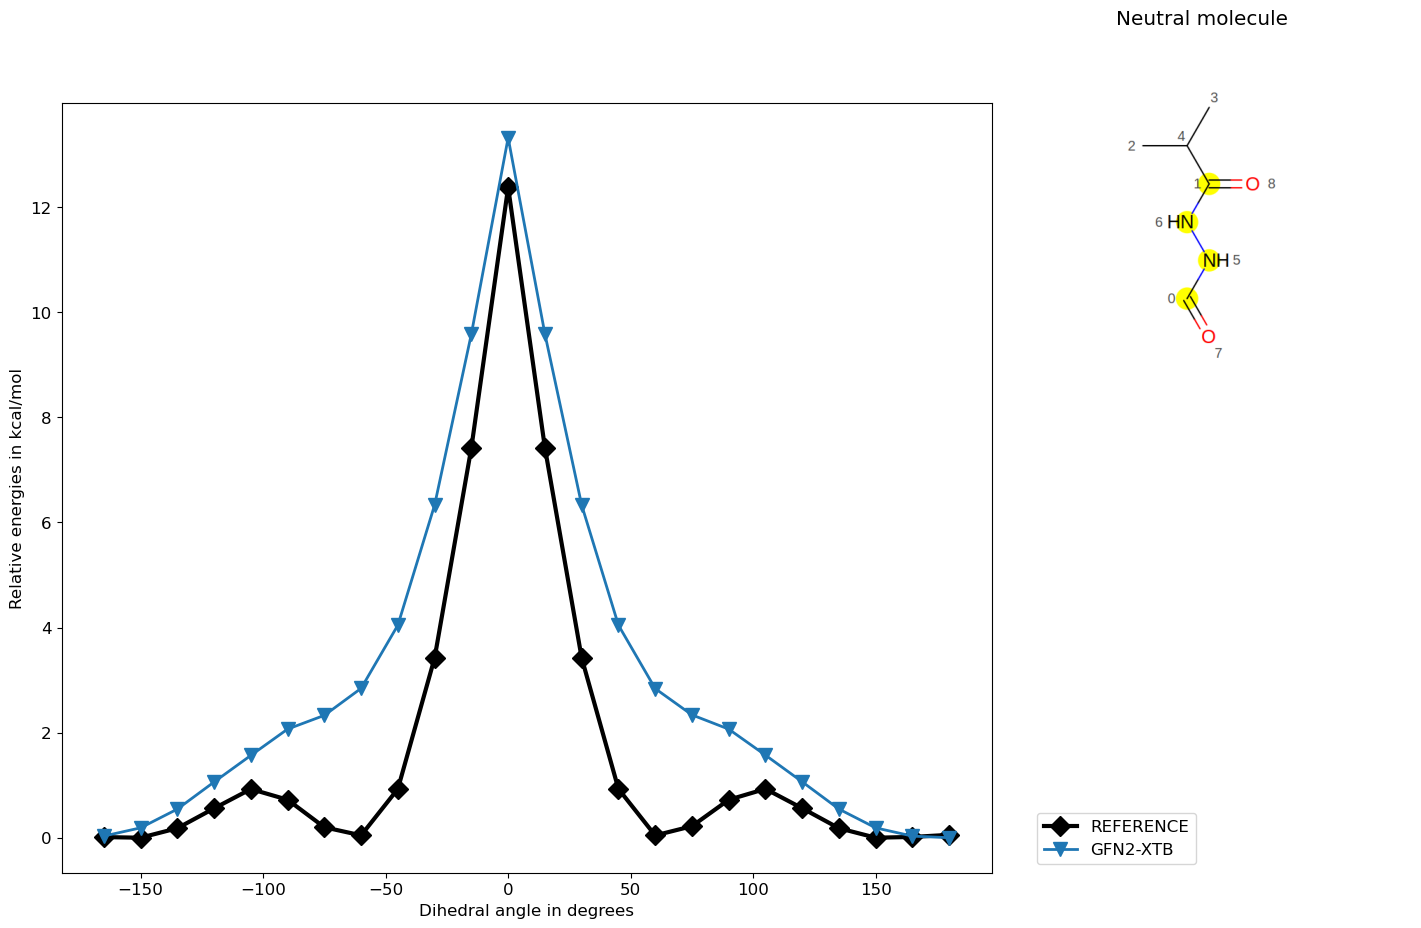

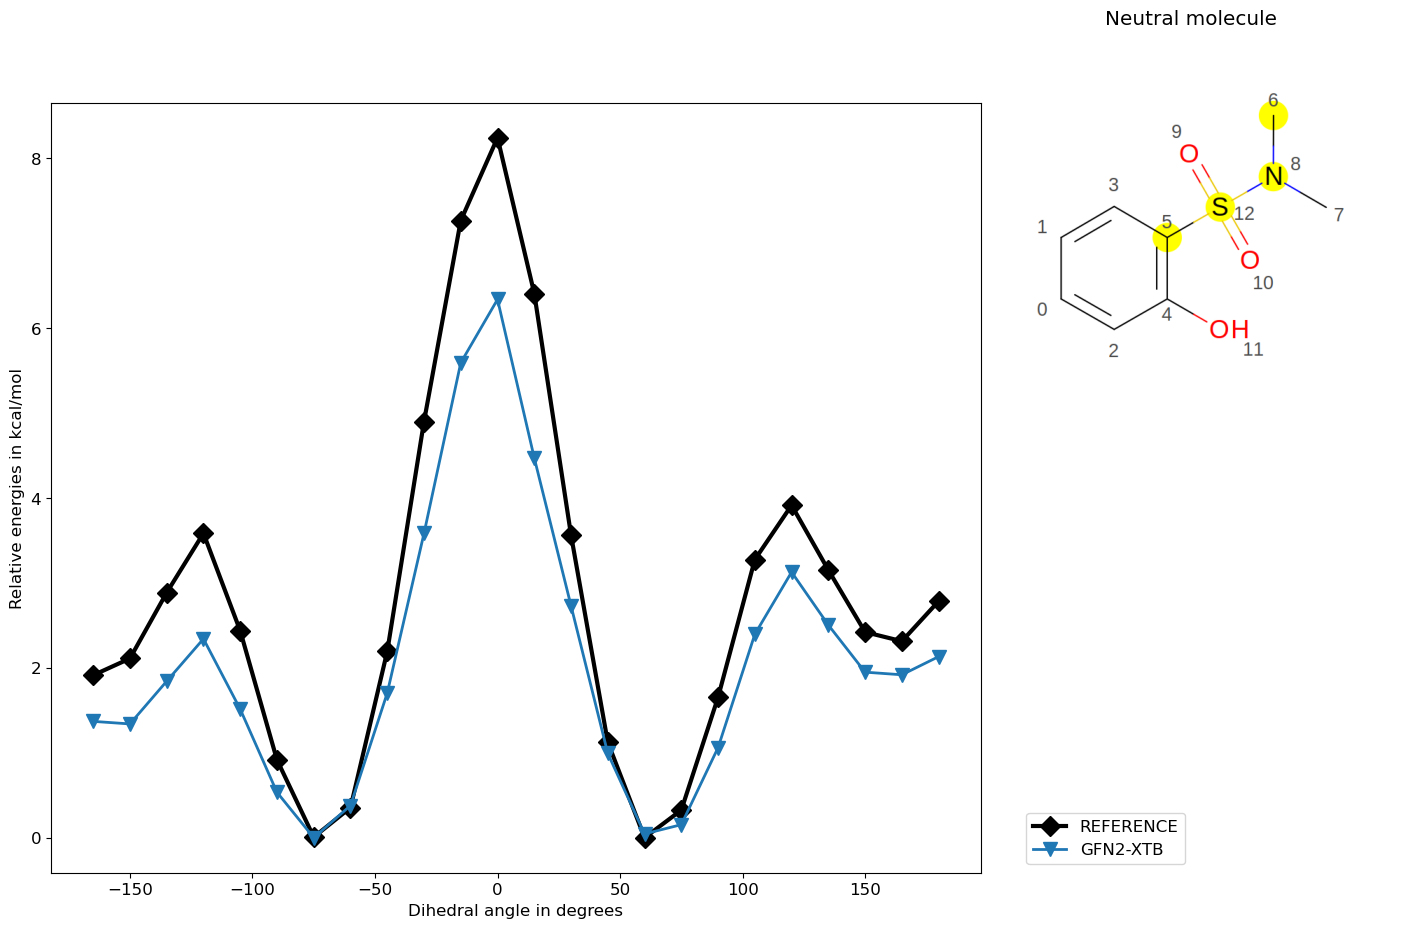

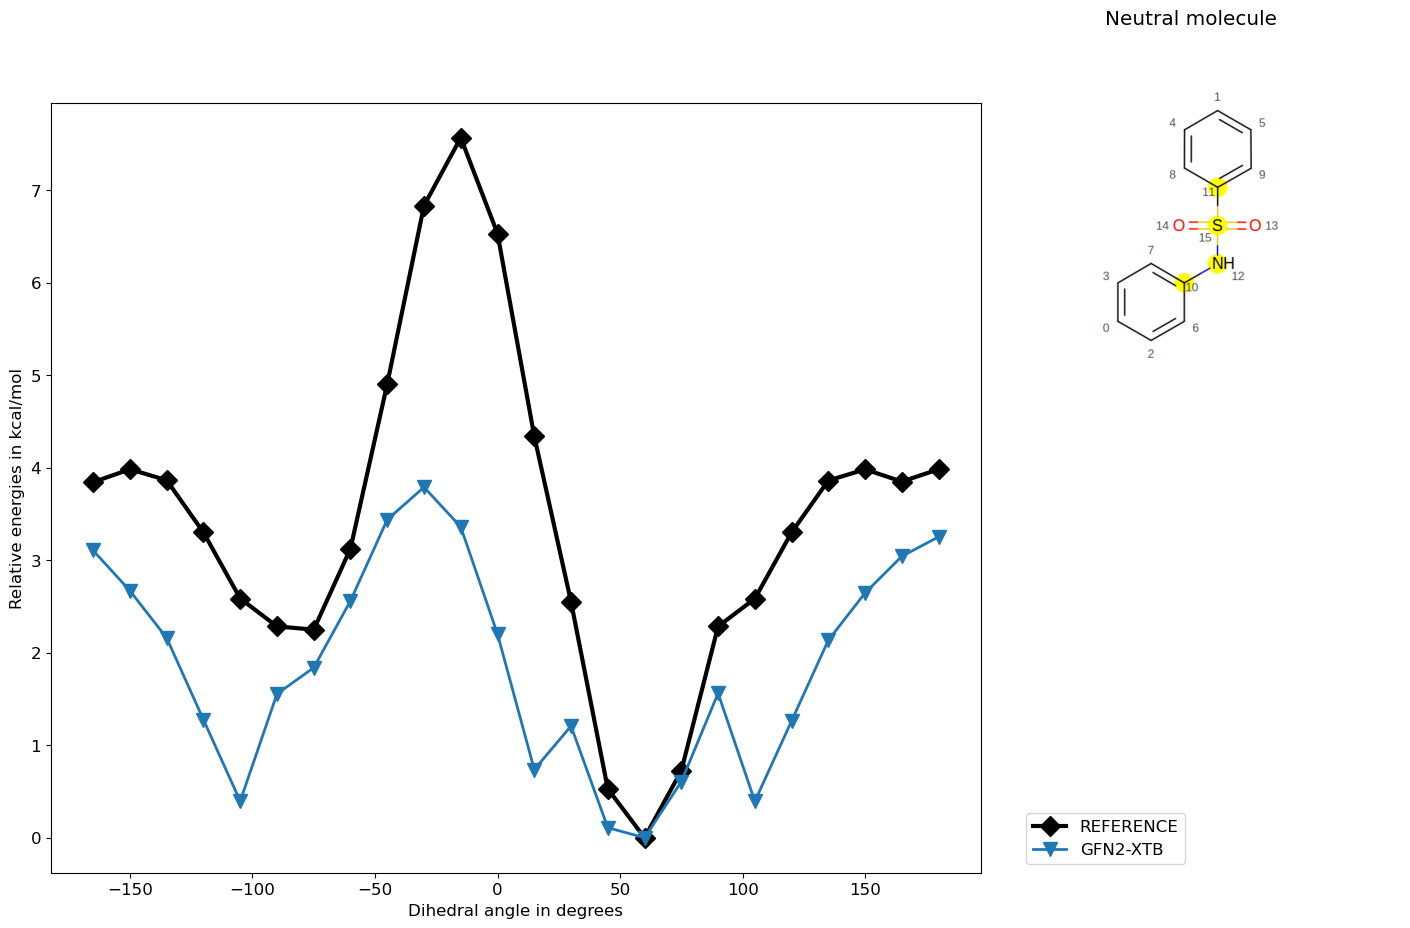

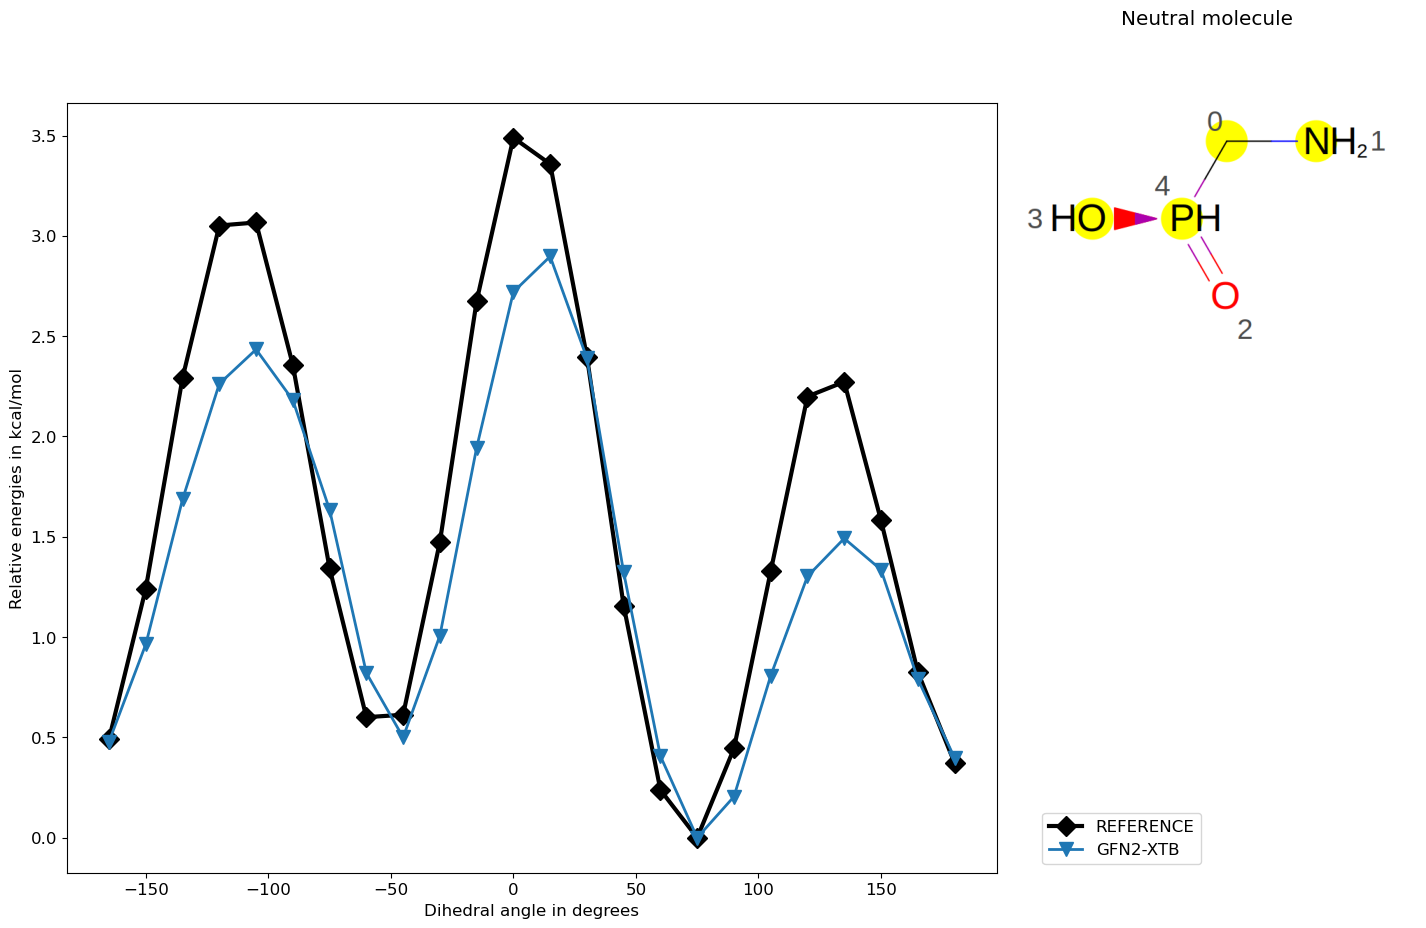

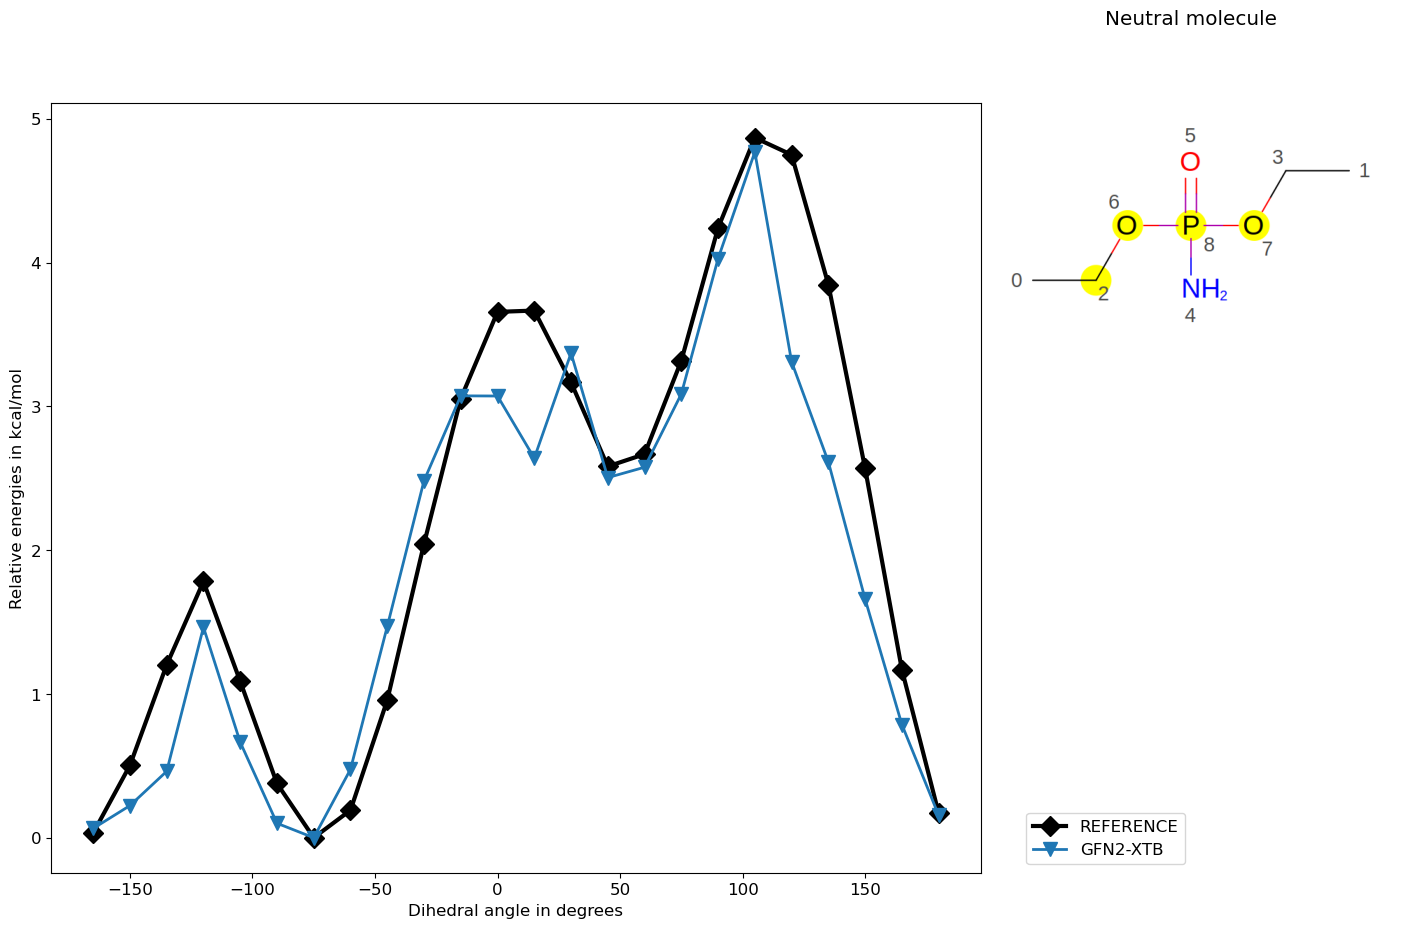

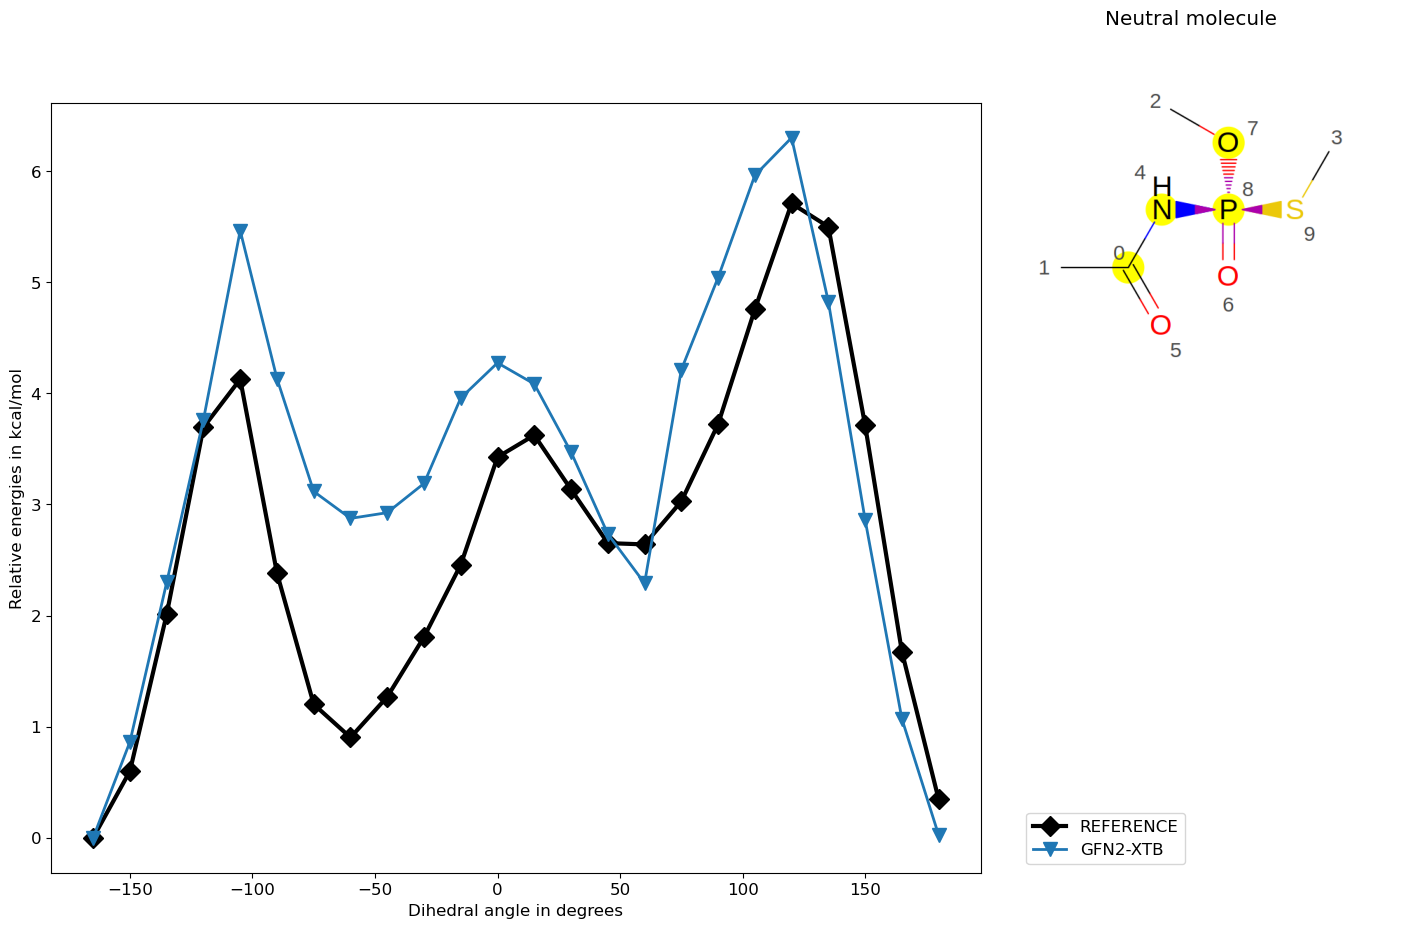

In [5]:
rmse = defaultdict(float)
mae = defaultdict(float)
all_energies = []
neutral_energies = []
charged_energies = []
neutral_ref = []
charged_ref = []
all_ref = []

for i in range(59):
    ref_energies = np.array(get_relative_energies(ref_dict[str(i)]['total energies'], HARTREE_TO_KCALMOL))
    ref_angles = ref_dict[str(i)]['angles']
    mapped_smiles = mp2_data[str(i)]['metadata']['mapped_smiles']
    dihedrals = mp2_data[str(i)]['metadata']['dihedral scanned'][0]
    mol_charge = mp2_data[str(i)]['metadata']['mol_charge']
    offmol = Molecule.from_mapped_smiles(mapped_smiles)
    flag_neutral = True
    if mol_charge != 0:
        flag_neutral = False
    elif mol_charge == 0  and mapped_smiles.find('+') != -1:
        flag_neutral = False
    
    all_ref.extend(ref_energies)
    if flag_neutral:
        neutral_ref.extend(ref_energies)
    else:
        charged_ref.extend(ref_energies)
        
    fig, ax = plt.subplots(figsize=[12, 10])
    ax.plot(
            ref_angles,
            ref_energies,
            "-D",
            label="REFERENCE",
            linewidth=3.0,
            c="k",
            markersize=10,
        )
    xtb_energies = []
    numbers = [atom.atomic_number for atom in offmol.atoms]
    for j in range(24):
        coord = np.array(mp2_data[str(i)]['final_geometries'][j]) * 0.529177
        atoms = ase.Atoms(positions=coord, numbers=numbers)
        initial_charges = get_atom_charges(mapped_smiles, len(atoms))        
        atoms.set_initial_charges(initial_charges)
        atoms.calc = XTB(method="GFN2-xTB")
        atoms.calc.reset()
        atoms.calc.set(electronic_temperature=2000.0)
        xtb_energies.append(atoms.get_potential_energy())

    energies = np.array(get_relative_energies(xtb_energies, eV_to_kcalmol_conversion_factor))
    all_energies.extend(energies)
    if flag_neutral:
        neutral_energies.extend(energies)
    else:
        charged_energies.extend(energies)
    
    rmse_energies = np.sqrt(np.mean((energies - ref_energies) ** 2))
    mae_energies = np.mean(np.abs(energies - ref_energies))
    rmse[i] = rmse_energies
    mae[i] = mae_energies
    ax.plot(
            ref_angles,
            energies,
            "-v",
            label='GFN2-XTB',
            linewidth=2.0,
            markersize=10,
        )
        
    
    plt.xlabel(
        "Dihedral angle in degrees",
    )
    plt.ylabel("Relative energies in kcal/mol")
    
    plt.legend(loc="lower left", bbox_to_anchor=(1.04, 0), fontsize=12)
    oemol = offmol.to_openeye()
    image = show_oemol_struc(
        oemol, torsions=True, atom_indices=dihedrals, width=600, height=500
    )
    img = Image.open(io.BytesIO(image.data))
    im_arr = np.asarray(img)
    newax = fig.add_axes([0.9, 0.6, 0.35, 0.35], anchor="SW", zorder=-1)
    newax.imshow(im_arr)
    newax.axis("off")
    if flag_neutral:
        plt.title('Neutral molecule')
    else:
        plt.title('Charged molecule')
    plt.show()
    pdf.savefig(fig, dpi=600, bbox_inches="tight")

In [6]:
table = []
all_ref = np.array(all_ref)
method_energies = np.array(all_energies)
rmse_stats = bootstrap_statistic(y_true=all_ref, y_pred=method_energies, statistic='RMSE')
mue_stats = bootstrap_statistic(y_true=all_ref, y_pred=method_energies, statistic='MUE')   
neutral_stats = bootstrap_statistic(y_true=neutral_ref, y_pred=np.array(neutral_energies), statistic='RMSE')
charged_stats = bootstrap_statistic(y_true=charged_ref, y_pred=np.array(charged_energies), statistic='RMSE')
lt_five_rmse_stats = bootstrap_statistic(y_true=all_ref[np.abs(all_ref) < 5], y_pred=method_energies[np.abs(all_ref) < 5], statistic='RMSE')
lt_five_mue_stats = bootstrap_statistic(y_true=all_ref[np.abs(all_ref) < 5], y_pred=method_energies[np.abs(all_ref) < 5], statistic='MUE')
table.append(['GFN2-XTB',
              "%.4f" % rmse_stats['mle'],"%.4f" % rmse_stats['low'],"%.4f" % rmse_stats['high'],
              "%.4f" % mue_stats['mle'],"%.4f" % mue_stats['low'],"%.4f" % mue_stats['high'],
              "%.4f" % neutral_stats['mle'],"%.4f" % neutral_stats['low'],"%.4f" % neutral_stats['high'],
              "%.4f" % charged_stats['mle'],"%.4f" % charged_stats['low'],"%.4f" % charged_stats['high'],
              "%.4f" % lt_five_rmse_stats['mle'],"%.4f" % lt_five_rmse_stats['low'],"%.4f" % lt_five_rmse_stats['high']])

In [7]:
pdf.close()

print(
    tabulate(
        table,
        headers=["Specification", 
                 "RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "MAE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "Neutral RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "Charged RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "lt_five_RMSE in kcal/mol", "low 95% ci", "high 95% ci"],
        tablefmt="orgtbl",
    )
)
print("* closer to zero the better")

| Specification   |   RMSE in kcal/mol |   low 95% ci |   high 95% ci |   MAE in kcal/mol |   low 95% ci |   high 95% ci |   Neutral RMSE in kcal/mol |   low 95% ci |   high 95% ci |   Charged RMSE in kcal/mol |   low 95% ci |   high 95% ci |   lt_five_RMSE in kcal/mol |   low 95% ci |   high 95% ci |
|-----------------+--------------------+--------------+---------------+-------------------+--------------+---------------+----------------------------+--------------+---------------+----------------------------+--------------+---------------+----------------------------+--------------+---------------|
| GFN2-XTB        |             1.2437 |       1.1742 |        1.3163 |            0.8519 |       0.8059 |        0.9001 |                     1.3367 |       1.2276 |        1.4589 |                     1.1395 |       1.0604 |        1.2106 |                     1.0768 |       0.9895 |        1.1705 |
* closer to zero the better


In [8]:
# For latex table entries
print("RMSE Neutral Charged")
for item in table:
    print(
        f"{item[0].upper()} & ${{{item[1]}}}^{{{item[2]}}}_{{{item[3]}"
        f"}}$ & ${{{item[7]}}}^{{{item[8]}}}_{{{item[9]}}}$ & ${{{item[10]}}}^{{{item[11]}}}_{{{item[12]}}}$\\\\ \\vspace{{2mm}}")

RMSE Neutral Charged
GFN2-XTB & ${1.2437}^{1.1742}_{1.3163}$ & ${1.3367}^{1.2276}_{1.4589}$ & ${1.1395}^{1.0604}_{1.2106}$\\ \vspace{2mm}


In [9]:
energies_dict = defaultdict(list)
for i in range(59):
    energies_dict[i] = all_energies[i*24:(i+1)*24]
with open('../data/gfn2-xtb_single_points_data.json', 'w') as outfile:
    json.dump(energies_dict, outfile) 